# import libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.model_selection import KFold
from numpy.core.numeric import NaN
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV
from IPython.core.pylabtools import figsize
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
import pandas as pd
import numpy as np
import math, sys
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from numpy import array
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers import Activation, Dense
from math import sqrt
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# load csv from drive

In [3]:
# Code to read csv file into Colaboratory:!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
link = "https://drive.google.com/file/d/1mw8BMWFMnOSilRC3JXB_UT-H3LwezraD/view?usp=sharing"
downloaded = drive.CreateFile({'id':"1mw8BMWFMnOSilRC3JXB_UT-H3LwezraD"}) 
downloaded.GetContentFile('dublinbikes_20200101_20200401.csv')  
df = pd.read_csv('dublinbikes_20200101_20200401.csv')# Dataset is now stored in a Pandas Dataframe
df.head()

STATION ID                 TIME  ...  LATITUDE LONGITUDE
0           2  2020-01-01 06:25:02  ...  53.35677  -6.26814
1           2  2020-01-01 06:30:02  ...  53.35677  -6.26814
2           2  2020-01-01 06:35:02  ...  53.35677  -6.26814
3           2  2020-01-01 06:40:03  ...  53.35677  -6.26814
4           2  2020-01-01 06:45:02  ...  53.35677  -6.26814

[5 rows x 11 columns]

# data preprocessing

## remove unnecessary columns

In [5]:
# del df['STATION ID']
del df['ADDRESS']
del df['LATITUDE']
del df['LONGITUDE']

# time column is more better organized
del df['LAST UPDATED']

# removing status, as from the data, only custom house and georges quay were 
# closed only on 1/1/2020
del df['STATUS']

In [6]:
df.head()

STATION ID                 TIME  ... AVAILABLE BIKE STANDS  AVAILABLE BIKES
0           2  2020-01-01 06:25:02  ...                    18                2
1           2  2020-01-01 06:30:02  ...                    18                2
2           2  2020-01-01 06:35:02  ...                    18                2
3           2  2020-01-01 06:40:03  ...                    20                0
4           2  2020-01-01 06:45:02  ...                    20                0

[5 rows x 6 columns]

## set datatypes

In [7]:
df = df.astype({"TIME": 'datetime64[ns]', "NAME": str})
df.dtypes

STATION ID                        int64
TIME                     datetime64[ns]
NAME                             object
BIKE STANDS                       int64
AVAILABLE BIKE STANDS             int64
AVAILABLE BIKES                   int64
dtype: object

## select stations
 selected stations 
 1. TOWNSEND STREET - personal use sometimes
 2. HEUSTON BRIDGE (NORTH) - near to pheonix park

In [8]:
print(df.NAME.unique())

['BLESSINGTON STREET' 'BOLTON STREET' 'GREEK STREET' 'CHARLEMONT PLACE'
 'CHRISTCHURCH PLACE' 'HIGH STREET' 'CUSTOM HOUSE QUAY' 'EXCHEQUER STREET'
 'DAME STREET' 'EARLSFORT TERRACE' 'ECCLES STREET'
 'FITZWILLIAM SQUARE WEST' 'HARDWICKE STREET' 'GEORGES QUAY' 'GOLDEN LANE'
 'GRANTHAM STREET' 'HERBERT PLACE' 'LEINSTER STREET SOUTH'
 'TOWNSEND STREET' 'CUSTOM HOUSE' 'CATHAL BRUGHA STREET'
 'MERRION SQUARE EAST' 'MERRION SQUARE WEST' 'MOLESWORTH STREET'
 'MOUNTJOY SQUARE WEST' 'ORMOND QUAY UPPER' 'PARNELL SQUARE NORTH'
 'PARNELL STREET' 'PEARSE STREET' "PRINCES STREET / O'CONNELL STREET"
 'PORTOBELLO HARBOUR' "ST. STEPHEN'S GREEN EAST"
 "ST. STEPHEN'S GREEN SOUTH" 'TALBOT STREET' 'WILTON TERRACE'
 'JERVIS STREET' 'HARCOURT TERRACE' 'SMITHFIELD NORTH' 'PORTOBELLO ROAD'
 'UPPER SHERRARD STREET' 'DEVERELL PLACE' 'HERBERT STREET' 'EXCISE WALK'
 'GUILD STREET' 'GEORGES LANE' 'YORK STREET WEST' 'YORK STREET EAST'
 'NEWMAN HOUSE' 'CLONMEL STREET' 'HATCH STREET' 'MOUNT STREET LOWER'
 'GRATTAN STRE

## townsend street

In [9]:
df_townsend = df[df.NAME == "TOWNSEND STREET"]
df_townsend = df_townsend.reset_index()

# name not required anymore 
del df_townsend["NAME"]
del df_townsend["STATION ID"]
# remove earlier indexes
del df_townsend["index"]

df_townsend.head()

TIME  BIKE STANDS  AVAILABLE BIKE STANDS  AVAILABLE BIKES
0 2020-01-01 06:25:02           20                     12                8
1 2020-01-01 06:30:02           20                     12                8
2 2020-01-01 06:35:02           20                     12                8
3 2020-01-01 06:40:03           20                     11                9
4 2020-01-01 06:45:02           20                     11                9

### populate missing data

In [10]:

#min hour to max hour with freq 5 mins
def createMissingData(df):
  df["DATE"] = df["TIME"].dt.date
  all_days = pd.date_range(df["DATE"].min(), df["DATE"].max(), freq='D')
  dates_in_train = df["DATE"].unique()
  flat_list = []

  missing_dates = []

  for date in all_days:
    if (date.date() not in dates_in_train):
      tmp_df = pd.DataFrame({'DATE' : date.date()},index=pd.date_range(str(date.date()) + " 00:00:02",freq='5T',periods=288))
      missing_dates.append(tmp_df.index)

  # print(missing_dates)
  flat_list = [str(item) for sublist in missing_dates for item in sublist]

  print(df_townsend.columns)  
  for i in range(0, len(flat_list)):
    df.loc[df.index.max() + 1] = [flat_list[i], NaN, NaN, NaN, NaN]
  
  return df

# df_townsend = createMissingData(df_townsend)

In [11]:
# sort and reset index
df_townsend = df_townsend.astype({"TIME": 'datetime64[ns]'})
df_townsend = df_townsend.sort_values(by=['TIME'])
df_townsend.reset_index()
df_townsend.to_csv("df_townsend.csv")

In [12]:
df_townsend.shape[0]

20370

### add time related columns

In [13]:
df_townsend = df_townsend.astype({"TIME": 'datetime64[ns]'})
df_townsend.dtypes

TIME                     datetime64[ns]
BIKE STANDS                       int64
AVAILABLE BIKE STANDS             int64
AVAILABLE BIKES                   int64
dtype: object

In [14]:
def add_time_cols(df):
  df["MONTH"] = df["TIME"].dt.month
  df["DAY_OF_WEEK"] = df["TIME"].dt.dayofweek
  df["HOUR"] = df["TIME"].dt.hour
  df["MINUTE"] = df["TIME"].dt.minute
  df["DAY"] = df["TIME"].dt.day

  return df

In [15]:
df_townsend = add_time_cols(df_townsend)
df_townsend.head()

TIME  BIKE STANDS  AVAILABLE BIKE STANDS  ...  HOUR  MINUTE  DAY
0 2020-01-01 06:25:02           20                     12  ...     6      25    1
1 2020-01-01 06:30:02           20                     12  ...     6      30    1
2 2020-01-01 06:35:02           20                     12  ...     6      35    1
3 2020-01-01 06:40:03           20                     11  ...     6      40    1
4 2020-01-01 06:45:02           20                     11  ...     6      45    1

[5 rows x 9 columns]

### add weekend column

In [16]:
def applyer(row):
  if row == 5 or row == 6:
    return 1
  else: 
    return 0

In [17]:
temp2 = df_townsend['DAY'].apply(applyer)
df_townsend['WEEKEND'] = temp2

### rearrange columns

In [18]:
def rearrang_cols(df):
  # to be used only with dataframes of single stations
  df = df[["TIME", "MONTH", "DAY_OF_WEEK", "WEEKEND", "HOUR", "MINUTE", "DAY", "BIKE STANDS",
                            "AVAILABLE BIKE STANDS", "AVAILABLE BIKES"]]
  return df

In [19]:
df_townsend = rearrang_cols(df_townsend)

In [20]:
df_townsend.head()

TIME  MONTH  ...  AVAILABLE BIKE STANDS  AVAILABLE BIKES
0 2020-01-01 06:25:02      1  ...                     12                8
1 2020-01-01 06:30:02      1  ...                     12                8
2 2020-01-01 06:35:02      1  ...                     12                8
3 2020-01-01 06:40:03      1  ...                     11                9
4 2020-01-01 06:45:02      1  ...                     11                9

[5 rows x 10 columns]

### generate seasonal mean

In [21]:
def seasonal_mean(np_arr, n, lr=0.7):
    """
    Compute the mean of corresponding seasonal periods
    np_arr: 1D array-like of the time series
    n: Seasonal window length of the time series
    """
    out = np.copy(np_arr)
    for i, val in enumerate(np_arr):
        if np.isnan(val):
            np_arr_seas = np_arr[i-1::-n]  # previous seasons only
            if np.isnan(np.nanmean(np_arr_seas)):
                np_arr_seas = np.concatenate([np_arr[i-1::-n], np_arr[i::n]])  # previous and forward
            out[i] = round(np.nanmean(np_arr_seas) * lr)
    return out

In [22]:
# df_townsend.loc[:, 'AVAILABLE BIKES'] = seasonal_mean(df_townsend["AVAILABLE BIKES"], n=7, lr=1.25)
# df_townsend.loc[:, 'AVAILABLE BIKE STANDS'] = seasonal_mean(df_townsend["AVAILABLE BIKE STANDS"], n=7, lr=1.25)
# df_townsend.loc[:, 'BIKE STANDS'] = seasonal_mean(df_townsend["BIKE STANDS"], n=7, lr=1.25)
df_townsend = df_townsend.reset_index()

# del df_townsend["index"]

In [23]:
df_townsend.to_csv("df_townsend.csv")

### baseline

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


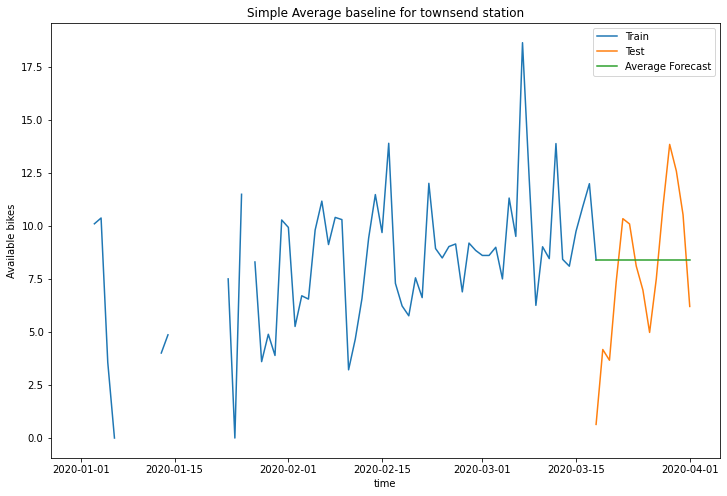

3.5205530971526646


In [24]:
# Baseline
# baseline model - Naive Approach
base_town_df = pd.read_csv("df_townsend.csv", 
                           usecols = ['TIME','AVAILABLE BIKES'],
                           parse_dates=['TIME'])

base_town_df.head()
train, valid = train_test_split(np.arange(0, len(base_town_df)), test_size=0.2,
                                shuffle=False)
train_df = base_town_df.iloc[train]
valid_df = base_town_df.iloc[valid]

#Aggregating the dataset at daily level
base_town_df.Timestamp = pd.to_datetime(base_town_df.TIME,format='%d-%m-%Y %H:%M') 
base_town_df.index = base_town_df.Timestamp 
base_town_df = base_town_df.resample('D').mean()
train_df.Timestamp = pd.to_datetime(train_df.TIME,format='%d-%m-%Y %H:%M') 
train_df.index = train_df.Timestamp 
train_df = train_df.resample('D').mean() 
valid_df.Timestamp = pd.to_datetime(valid_df.TIME,format='%d-%m-%Y %H:%M') 
valid_df.index = valid_df.Timestamp 
valid_df = valid_df.resample('D').mean()

base_town_df = valid_df.copy()
base_town_df['avg_forecast'] = train_df["AVAILABLE BIKES"].mean()
plt.figure(figsize=(12,8))
plt.plot(train_df["AVAILABLE BIKES"], label='Train')
plt.plot(valid_df["AVAILABLE BIKES"], label='Test')
plt.plot(base_town_df['avg_forecast'], label='Average Forecast')
plt.legend(loc='best')
plt.xlabel("time")
plt.ylabel("Available bikes")
plt.title("Simple Average baseline for townsend station")
plt.show()

rms = sqrt(mean_squared_error(valid_df["AVAILABLE BIKES"], base_town_df.avg_forecast))
print(rms)

## Plots

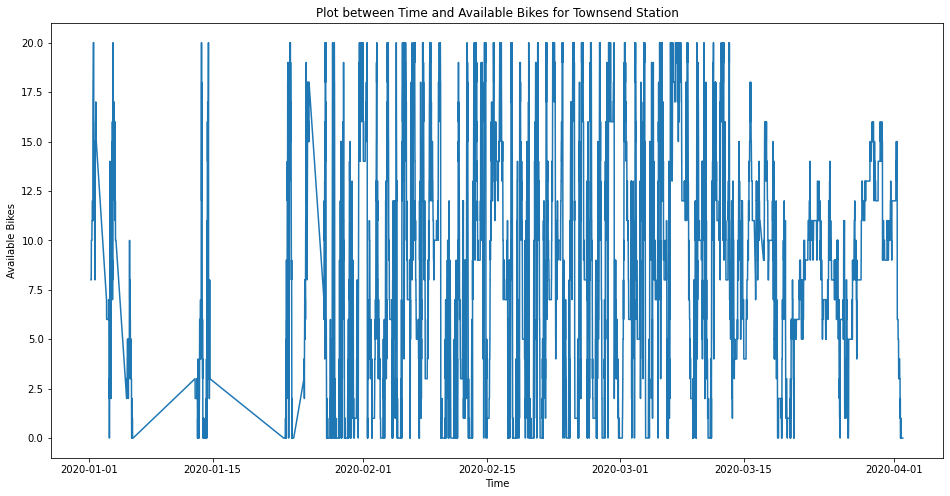

In [25]:
plt.figure(figsize=(16,8))
plt.plot(df_townsend['TIME'], df_townsend["AVAILABLE BIKES"], label='bikes')
plt.xlabel("Time")
plt.ylabel("Available Bikes")
plt.title("Plot between Time and Available Bikes for Townsend Station")
plt.show()

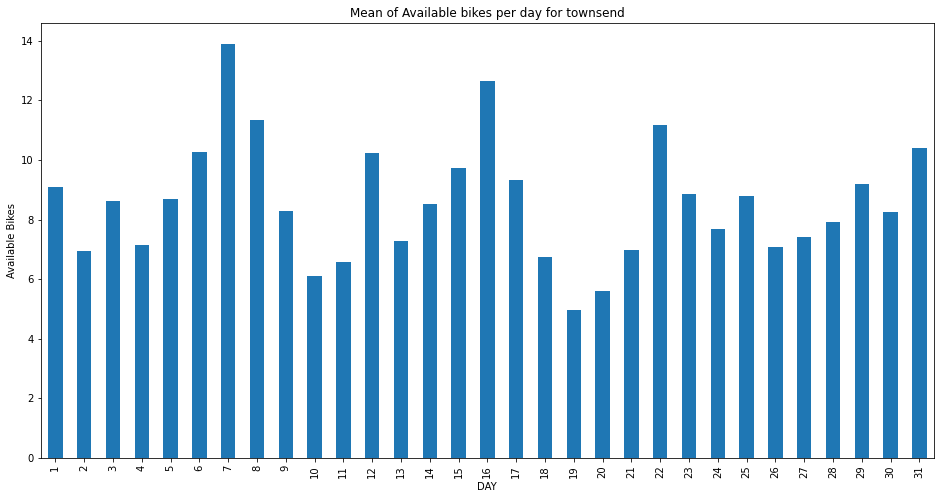

In [26]:
plt.figure(figsize=(16,8))
df_townsend.groupby("DAY")["AVAILABLE BIKES"].mean().plot.bar()
plt.ylabel("Available Bikes")
plt.title("Mean of Available bikes per day for townsend")
plt.show()

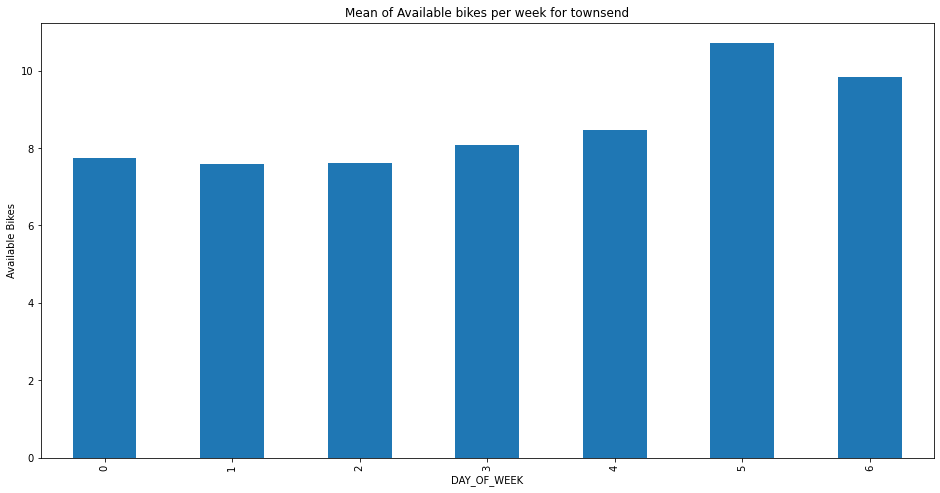

In [27]:
plt.figure(figsize=(16,8))
df_townsend.groupby("DAY_OF_WEEK")["AVAILABLE BIKES"].mean().plot.bar()
plt.ylabel("Available Bikes")
plt.title("Mean of Available bikes per week for townsend")
plt.show()

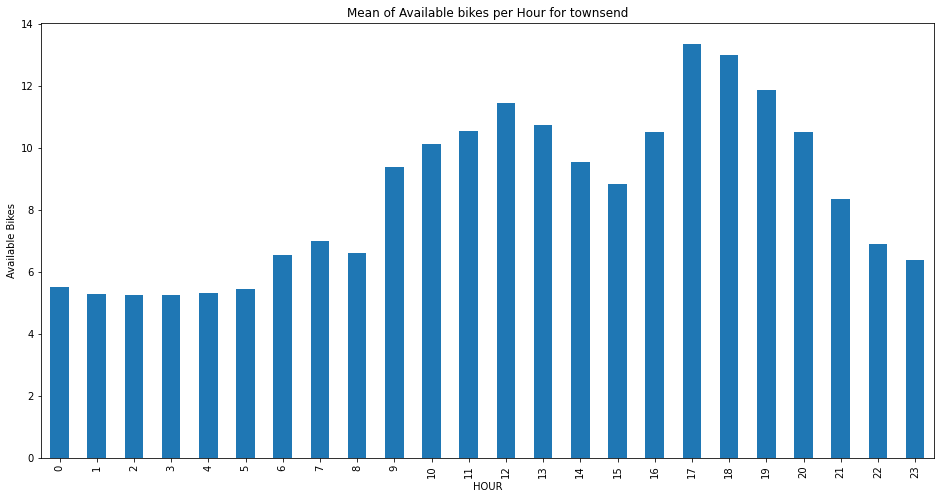

In [28]:
plt.figure(figsize=(16,8))
df_townsend.groupby("HOUR")["AVAILABLE BIKES"].mean().plot.bar()
plt.ylabel("Available Bikes")
plt.title("Mean of Available bikes per Hour for townsend")
plt.show()

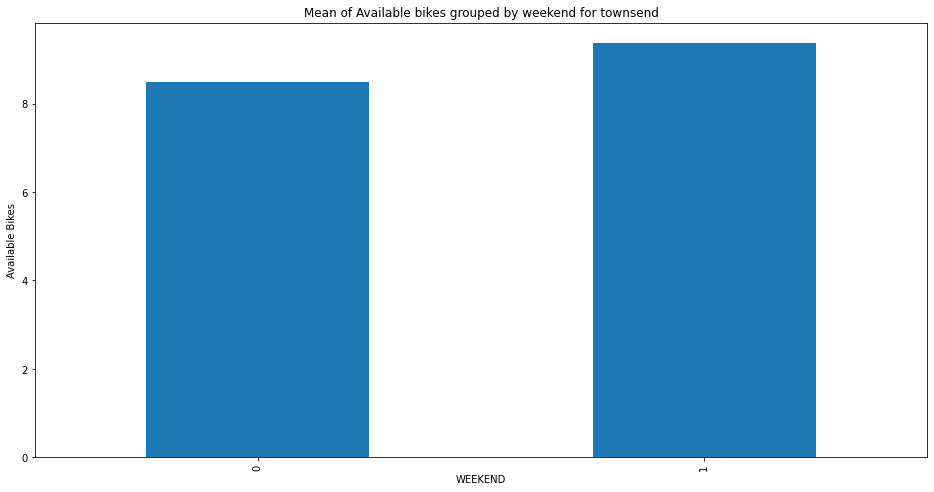

In [29]:
plt.figure(figsize=(16,8))
df_townsend.groupby('WEEKEND')['AVAILABLE BIKES'].mean().plot.bar()
plt.ylabel("Available Bikes")
plt.title("Mean of Available bikes grouped by weekend for townsend")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


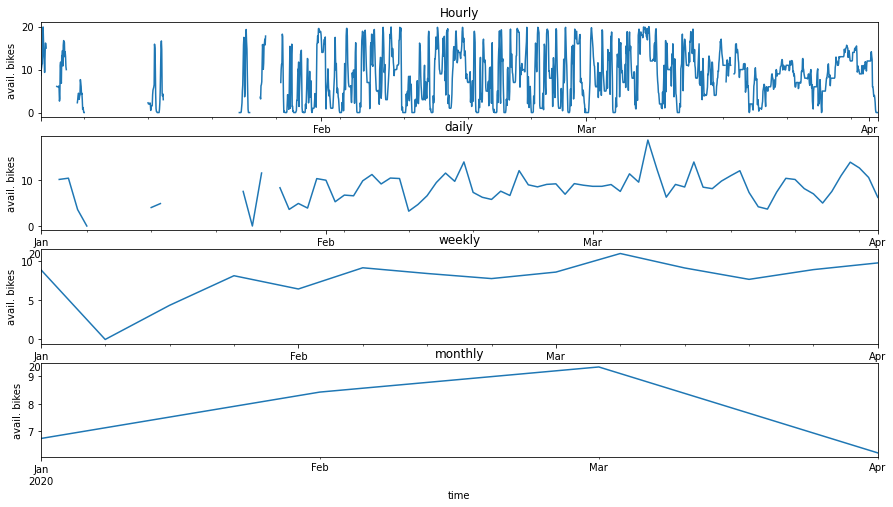

In [30]:
ts_tmp = df_townsend.copy()
ts_tmp.Timestamp = pd.to_datetime(ts_tmp.TIME,format='%d-%m-%Y %H:%M')
ts_tmp.index = ts_tmp.Timestamp 

hourly = ts_tmp.resample('H').mean()
daily = ts_tmp.resample('d').mean()
weekly = ts_tmp.resample('W').mean()
monthly = ts_tmp.resample('m').mean()

fig, axs = plt.subplots(4,1)
hourly["AVAILABLE BIKES"].plot(figsize=(15,8), title='Hourly', ax=axs[0], xlabel='time', ylabel='avail. bikes')
daily["AVAILABLE BIKES"].plot(figsize=(15,8), title='daily', ax=axs[1], xlabel='time', ylabel='avail. bikes')
weekly["AVAILABLE BIKES"].plot(figsize=(15,8), title='weekly', ax=axs[2], xlabel='time', ylabel='avail. bikes')
monthly["AVAILABLE BIKES"].plot(figsize=(15,8), title='monthly', ax=axs[3], xlabel='time', ylabel='avail. bikes')

plt.show()

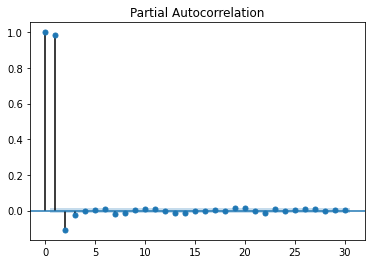

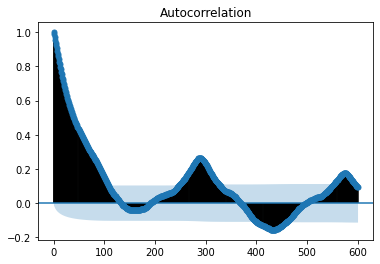

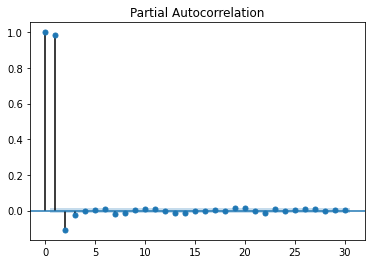

In [31]:

plot_acf(df_townsend['AVAILABLE BIKES'], lags=600)
plot_pacf(df_townsend['AVAILABLE BIKES'], lags=30)

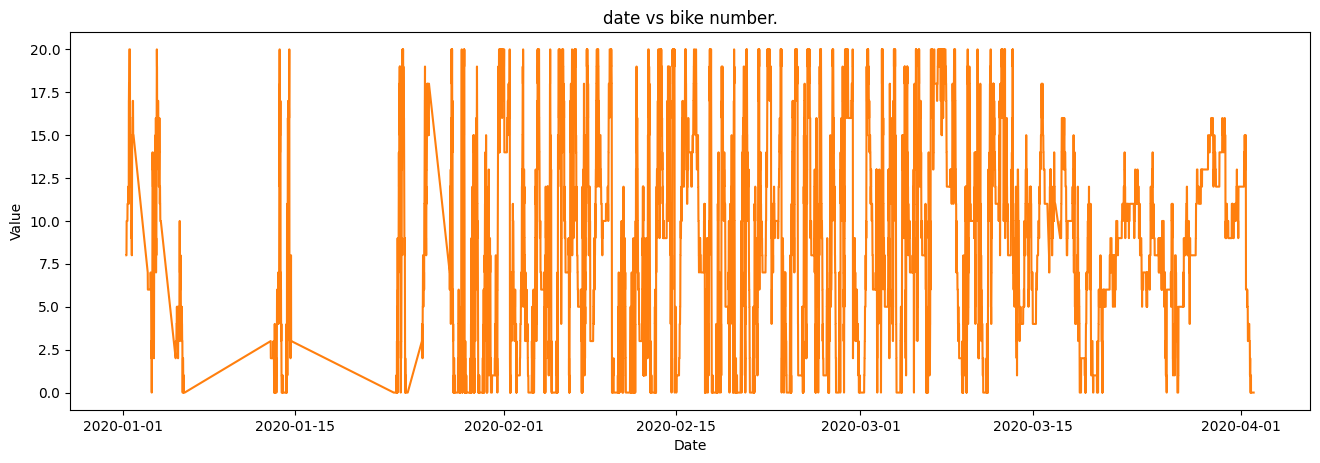

In [32]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:orange')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df_townsend, x=df_townsend['TIME'], y=df_townsend['AVAILABLE BIKES'], title='date vs bike number.')

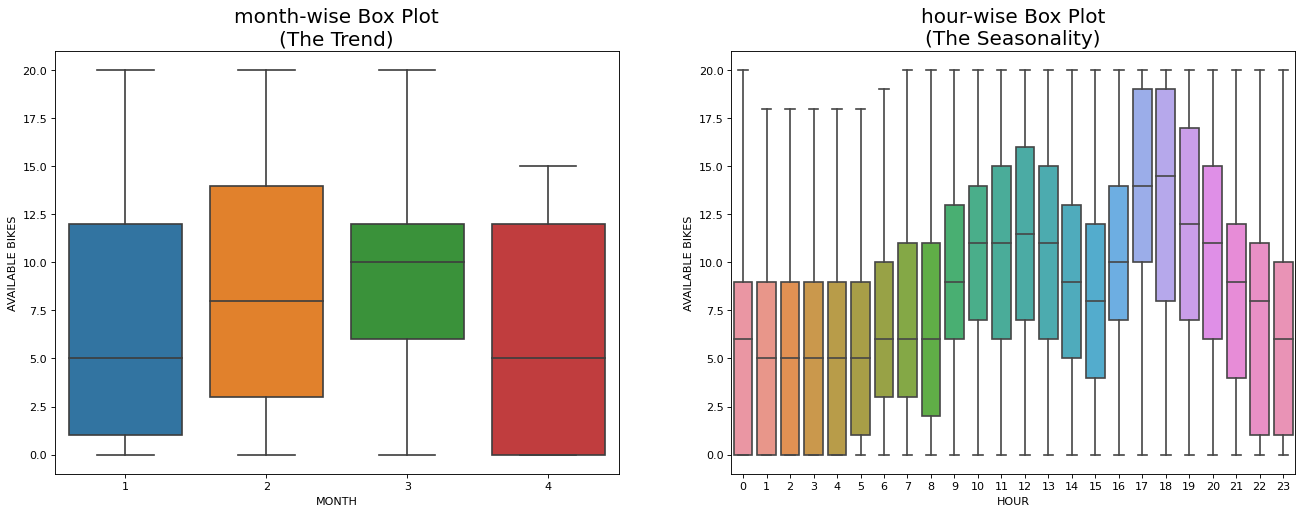

In [33]:

fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='MONTH', y='AVAILABLE BIKES', data=df_townsend, ax=axes[0])
# sns.boxplot(x='DAY', y='AVAILABLE BIKES', data=train)
sns.boxplot(x='HOUR', y='AVAILABLE BIKES', data=df_townsend)

# Set Title
axes[0].set_title('month-wise Box Plot\n(The Trend)', fontsize=18); 
# axes[1].set_title('day-wise Box Plot\n(The Seasonality)', fontsize=18)
axes[1].set_title('hour-wise Box Plot\n(The Seasonality)', fontsize=18)

plt.show()

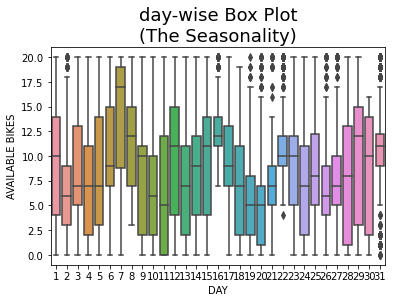

In [34]:
fig, axes = plt.subplots()
sns.boxplot(x='DAY', y='AVAILABLE BIKES', data=df_townsend)

# Set Title
axes.set_title('day-wise Box Plot\n(The Seasonality)', fontsize=18)

plt.show()

## HEUSTON BRIDGE (NORTH)

In [35]:
df_heuston = df[df.NAME == "HEUSTON BRIDGE (NORTH)"]
df_heuston = df_heuston.reset_index()

# name not required anymore 
del df_heuston["NAME"]
del df_heuston["STATION ID"]
# remove earlier indexes
del df_heuston["index"]

df_heuston.head()

TIME  BIKE STANDS  AVAILABLE BIKE STANDS  AVAILABLE BIKES
0 2020-01-01 06:25:02           40                     37                3
1 2020-01-01 06:30:02           40                     37                3
2 2020-01-01 06:35:02           40                     36                4
3 2020-01-01 06:40:03           40                     36                4
4 2020-01-01 06:45:02           40                     36                4

### populate missing data

In [36]:

#min hour to max hour with freq 5 mins
def createMissingData(df):
  df["DATE"] = df["TIME"].dt.date
  all_days = pd.date_range(df["DATE"].min(), df["DATE"].max(), freq='D')
  dates_in_train = df["DATE"].unique()
  flat_list = []

  missing_dates = []

  for date in all_days:
    if (date.date() not in dates_in_train):
      tmp_df = pd.DataFrame({'DATE' : date.date()},index=pd.date_range(str(date.date()) + " 00:00:02",freq='5T',periods=288))
      missing_dates.append(tmp_df.index)

  # print(missing_dates)
  flat_list = [str(item) for sublist in missing_dates for item in sublist]

  print(df_townsend.columns)  
  for i in range(0, len(flat_list)):
    df.loc[df.index.max() + 1] = [flat_list[i], NaN, NaN, NaN, NaN]
  
  return df

# df_heuston = createMissingData(df_heuston)

### add time related columns

In [37]:
df_heuston = df_heuston.astype({"TIME": 'datetime64[ns]'})
df_heuston.dtypes

TIME                     datetime64[ns]
BIKE STANDS                       int64
AVAILABLE BIKE STANDS             int64
AVAILABLE BIKES                   int64
dtype: object

In [38]:
def add_time_cols(df):
  df["MONTH"] = df["TIME"].dt.month
  df["DAY_OF_WEEK"] = df["TIME"].dt.dayofweek
  df["HOUR"] = df["TIME"].dt.hour
  df["MINUTE"] = df["TIME"].dt.minute
  df["DAY"] = df["TIME"].dt.day

  return df

In [39]:
df_heuston = add_time_cols(df_heuston)
df_heuston.head()

TIME  BIKE STANDS  AVAILABLE BIKE STANDS  ...  HOUR  MINUTE  DAY
0 2020-01-01 06:25:02           40                     37  ...     6      25    1
1 2020-01-01 06:30:02           40                     37  ...     6      30    1
2 2020-01-01 06:35:02           40                     36  ...     6      35    1
3 2020-01-01 06:40:03           40                     36  ...     6      40    1
4 2020-01-01 06:45:02           40                     36  ...     6      45    1

[5 rows x 9 columns]

### add weekend column

In [40]:
def applyer(row):
  if row == 5 or row == 6:
    return 1
  else: 
    return 0

In [41]:
temp2 = df_heuston['DAY'].apply(applyer)
df_heuston['WEEKEND'] = temp2

### rearrange columns

In [42]:
def rearrang_cols(df):
  # to be used only with dataframes of single stations
  df = df[["TIME", "MONTH", "DAY_OF_WEEK", "WEEKEND", "HOUR", "MINUTE", "DAY", "BIKE STANDS",
                            "AVAILABLE BIKE STANDS", "AVAILABLE BIKES"]]
  return df

In [43]:
df_heuston = rearrang_cols(df_heuston)

In [44]:
df_heuston.head()

TIME  MONTH  ...  AVAILABLE BIKE STANDS  AVAILABLE BIKES
0 2020-01-01 06:25:02      1  ...                     37                3
1 2020-01-01 06:30:02      1  ...                     37                3
2 2020-01-01 06:35:02      1  ...                     36                4
3 2020-01-01 06:40:03      1  ...                     36                4
4 2020-01-01 06:45:02      1  ...                     36                4

[5 rows x 10 columns]

### generate seasonal mean

In [45]:
def seasonal_mean(ts, n, lr=0.7):
    """
    Compute the mean of corresponding seasonal periods
    ts: 1D array-like of the time series
    n: Seasonal window length of the time series
    """
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            ts_seas = ts[i-1::-n]  # previous seasons only
            if np.isnan(np.nanmean(ts_seas)):
                ts_seas = np.concatenate([ts[i-1::-n], ts[i::n]])  # previous and forward
            out[i] = round(np.nanmean(ts_seas) * lr)
    return out

In [46]:
# df_heuston.loc[:, 'AVAILABLE BIKES'] = seasonal_mean(df_heuston["AVAILABLE BIKES"], n=7, lr=1.25)
# df_heuston.loc[:, 'AVAILABLE BIKE STANDS'] = seasonal_mean(df_heuston["AVAILABLE BIKE STANDS"], n=7, lr=1.25)
# df_heuston.loc[:, 'BIKE STANDS'] = seasonal_mean(df_heuston["BIKE STANDS"], n=7, lr=1.25)
df_heuston = df_heuston.reset_index()

# del df_townsend["index"]

In [47]:
df_heuston.to_csv("df_heuston.csv")

###baseline

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


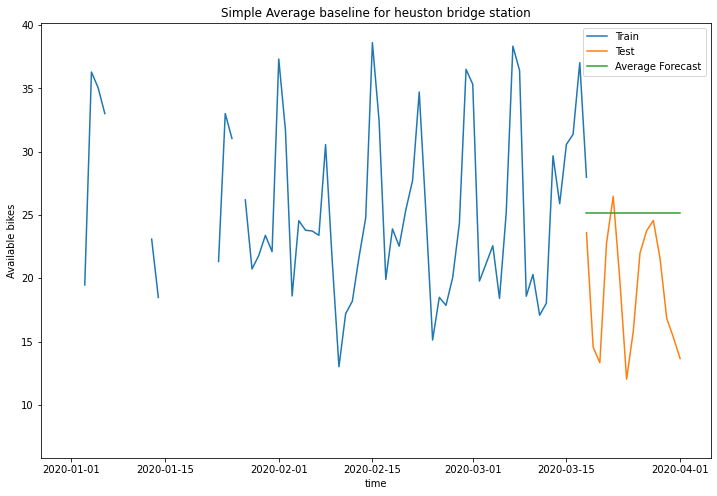

7.617264418160223


In [48]:
# Baseline
# baseline model - simple average
base_town_df = pd.read_csv("df_heuston.csv", 
                           usecols = ['TIME','AVAILABLE BIKES'],
                           parse_dates=['TIME'])

base_town_df.head()
train, valid = train_test_split(np.arange(0, len(base_town_df)), test_size=0.2,
                                shuffle=False)
train_df = base_town_df.iloc[train]
valid_df = base_town_df.iloc[valid]

#Aggregating the dataset at daily level
base_town_df.Timestamp = pd.to_datetime(base_town_df.TIME,format='%d-%m-%Y %H:%M') 
base_town_df.index = base_town_df.Timestamp 
base_town_df = base_town_df.resample('D').mean()
train_df.Timestamp = pd.to_datetime(train_df.TIME,format='%d-%m-%Y %H:%M') 
train_df.index = train_df.Timestamp 
train_df = train_df.resample('D').mean() 
valid_df.Timestamp = pd.to_datetime(valid_df.TIME,format='%d-%m-%Y %H:%M') 
valid_df.index = valid_df.Timestamp 
valid_df = valid_df.resample('D').mean()

base_town_df = valid_df.copy()
base_town_df['avg_forecast'] = train_df["AVAILABLE BIKES"].mean()
plt.figure(figsize=(12,8))
plt.plot(train_df["AVAILABLE BIKES"], label='Train')
plt.plot(valid_df["AVAILABLE BIKES"], label='Test')
plt.plot(base_town_df['avg_forecast'], label='Average Forecast')
plt.legend(loc='best')
plt.xlabel("time")
plt.ylabel("Available bikes")
plt.title("Simple Average baseline for heuston bridge station")
plt.show()

rms = sqrt(mean_squared_error(valid_df["AVAILABLE BIKES"], base_town_df.avg_forecast))
print(rms)

## Plots

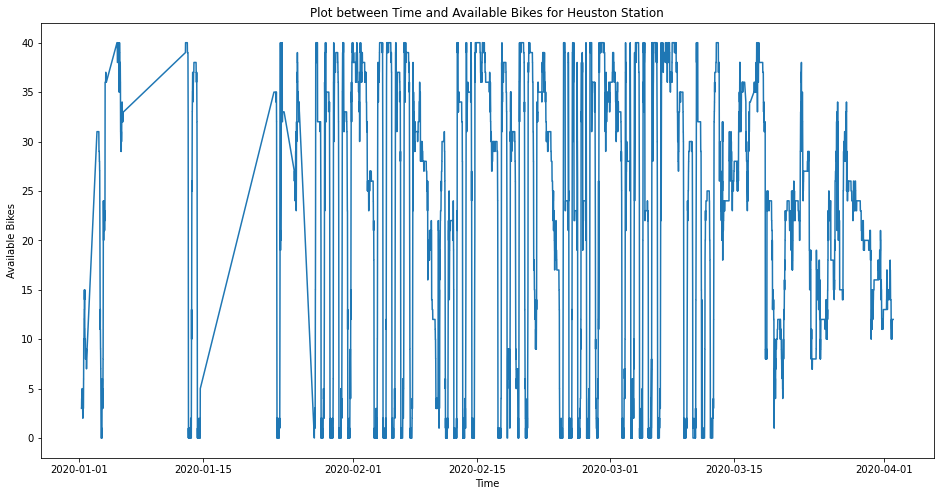

In [49]:
plt.figure(figsize=(16,8))
plt.plot(df_heuston['TIME'], df_heuston["AVAILABLE BIKES"], label='bikes')
plt.xlabel("Time")
plt.ylabel("Available Bikes")
plt.title("Plot between Time and Available Bikes for Heuston Station")
plt.show()

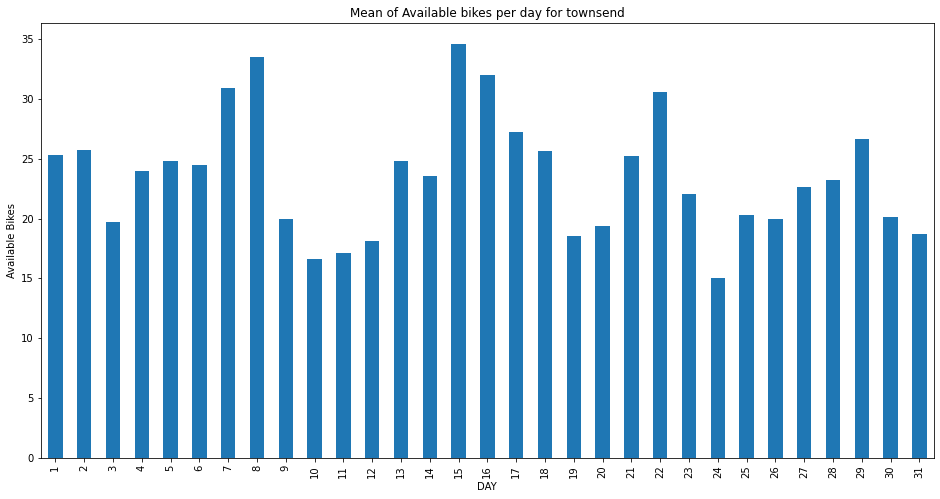

In [50]:
plt.figure(figsize=(16,8))
df_heuston.groupby("DAY")["AVAILABLE BIKES"].mean().plot.bar()
plt.ylabel("Available Bikes")
plt.title("Mean of Available bikes per day for townsend")
plt.show()

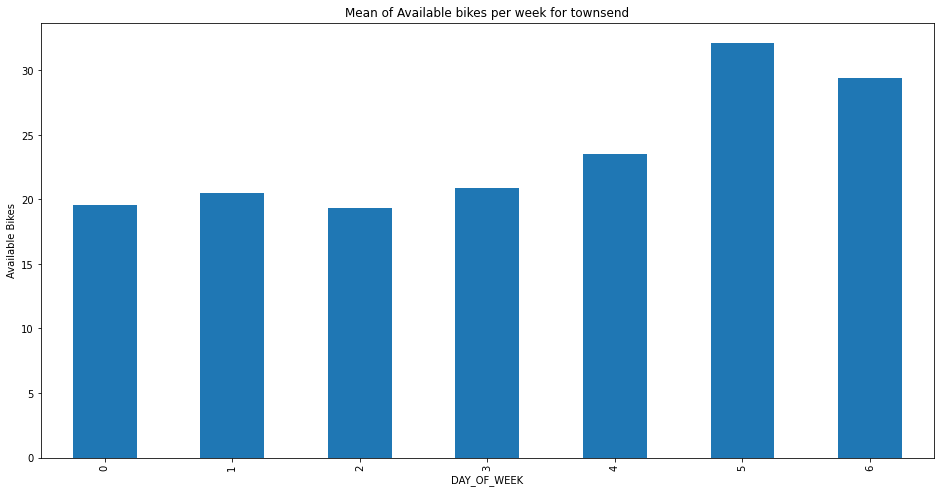

In [51]:
plt.figure(figsize=(16,8))
df_heuston.groupby("DAY_OF_WEEK")["AVAILABLE BIKES"].mean().plot.bar()
plt.ylabel("Available Bikes")
plt.title("Mean of Available bikes per week for townsend")
plt.show()

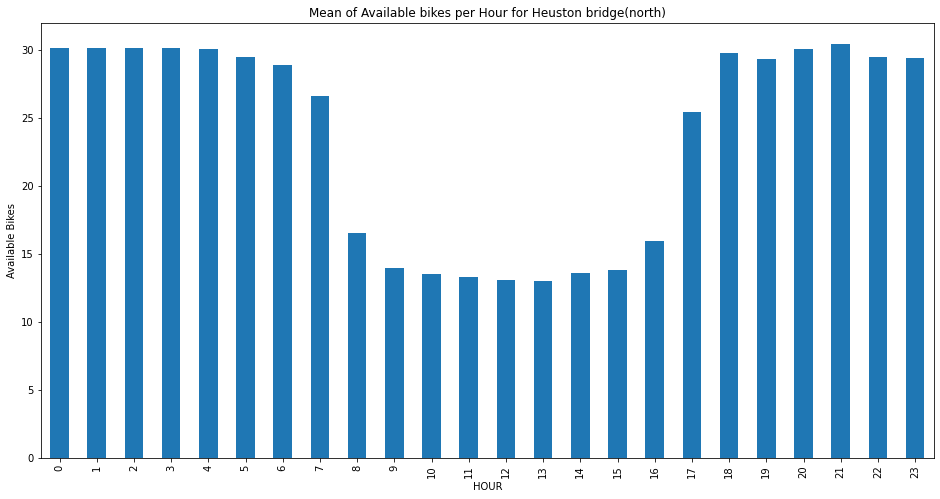

In [52]:
plt.figure(figsize=(16,8))
df_heuston.groupby("HOUR")["AVAILABLE BIKES"].mean().plot.bar()
plt.ylabel("Available Bikes")
plt.title("Mean of Available bikes per Hour for Heuston bridge(north)")
plt.show()

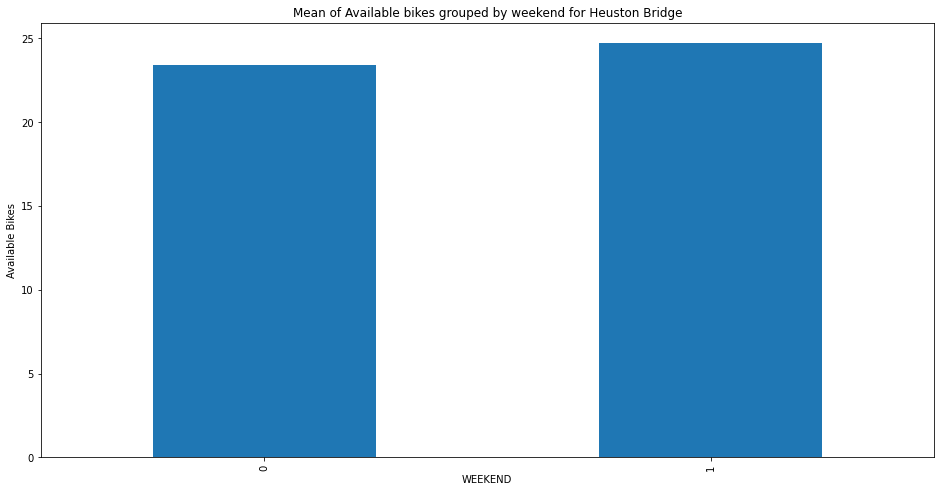

In [53]:
plt.figure(figsize=(16,8))
df_heuston.groupby('WEEKEND')['AVAILABLE BIKES'].mean().plot.bar()
plt.ylabel("Available Bikes")
plt.title("Mean of Available bikes grouped by weekend for Heuston Bridge")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


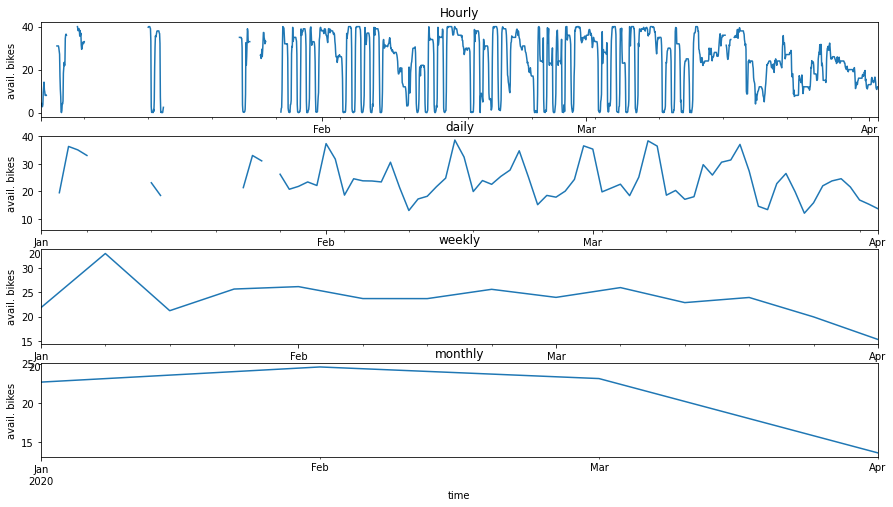

In [54]:
ts_tmp = df_heuston.copy()
ts_tmp.Timestamp = pd.to_datetime(ts_tmp.TIME,format='%d-%m-%Y %H:%M')
ts_tmp.index = ts_tmp.Timestamp 

hourly = ts_tmp.resample('H').mean()
daily = ts_tmp.resample('d').mean()
weekly = ts_tmp.resample('W').mean()
monthly = ts_tmp.resample('m').mean()

fig, axs = plt.subplots(4,1)
hourly["AVAILABLE BIKES"].plot(figsize=(15,8), title='Hourly', ax=axs[0], xlabel='time', ylabel='avail. bikes')
daily["AVAILABLE BIKES"].plot(figsize=(15,8), title='daily', ax=axs[1], xlabel='time', ylabel='avail. bikes')
weekly["AVAILABLE BIKES"].plot(figsize=(15,8), title='weekly', ax=axs[2], xlabel='time', ylabel='avail. bikes')
monthly["AVAILABLE BIKES"].plot(figsize=(15,8), title='monthly', ax=axs[3], xlabel='time', ylabel='avail. bikes')

plt.show()

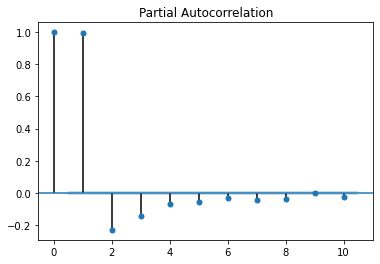

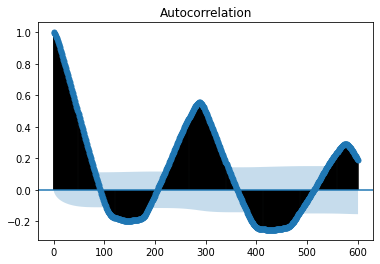

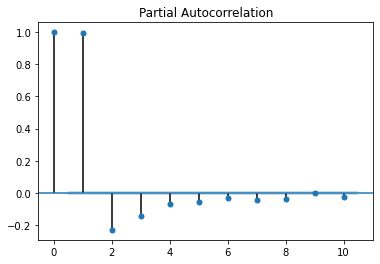

In [55]:

plot_acf(df_heuston['AVAILABLE BIKES'], lags=600)
plot_pacf(df_heuston['AVAILABLE BIKES'], lags=10)

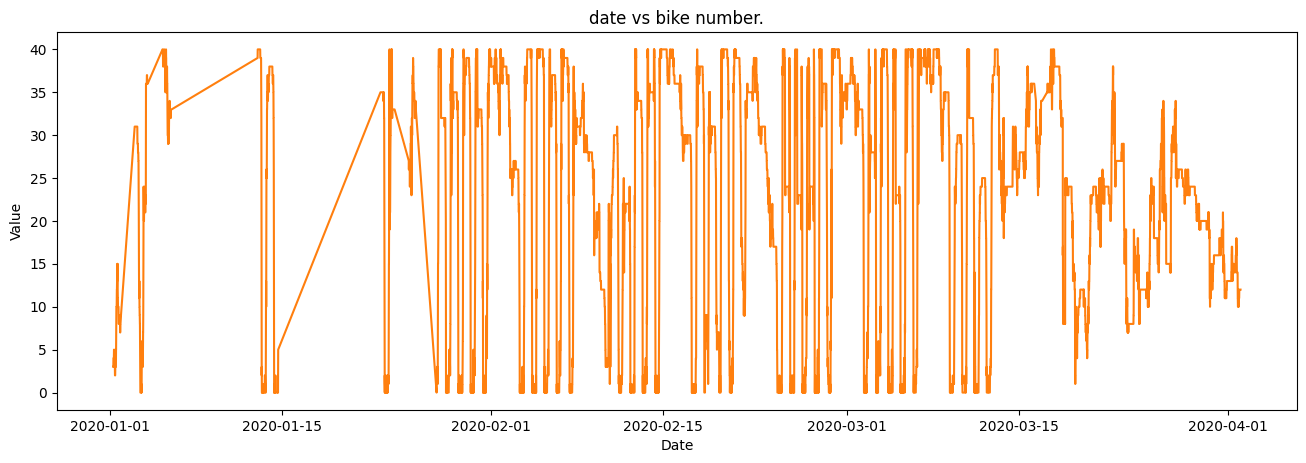

In [56]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:orange')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df_heuston, x=df_heuston['TIME'], y=df_heuston['AVAILABLE BIKES'], title='date vs bike number.')

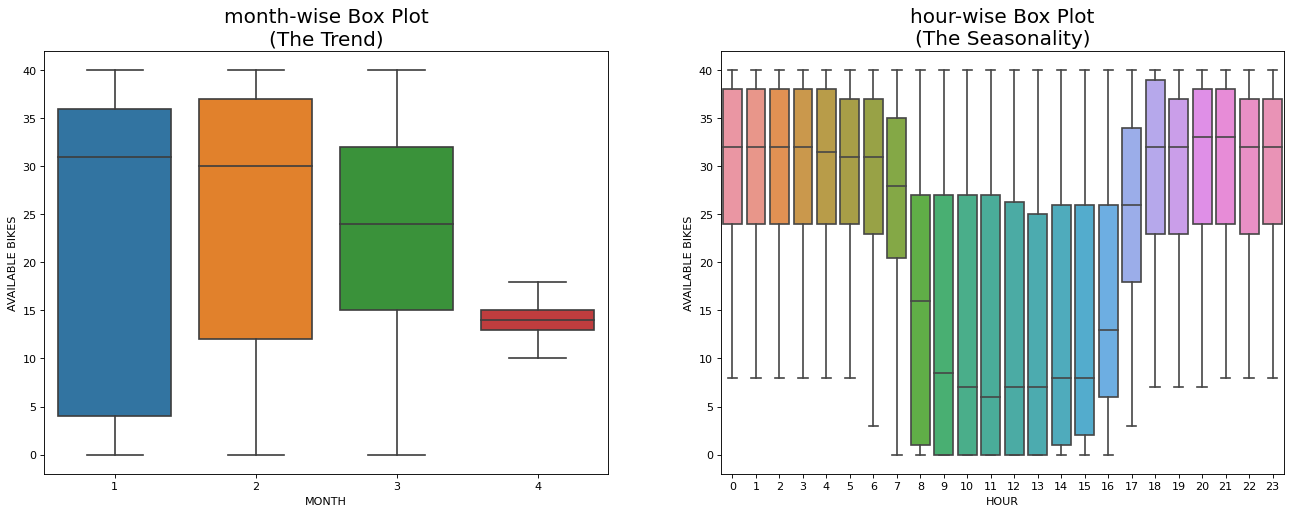

In [57]:
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='MONTH', y='AVAILABLE BIKES', data=df_heuston, ax=axes[0])
# sns.boxplot(x='DAY', y='AVAILABLE BIKES', data=train)
sns.boxplot(x='HOUR', y='AVAILABLE BIKES', data=df_heuston)

# Set Title
axes[0].set_title('month-wise Box Plot\n(The Trend)', fontsize=18); 
# axes[1].set_title('day-wise Box Plot\n(The Seasonality)', fontsize=18)
axes[1].set_title('hour-wise Box Plot\n(The Seasonality)', fontsize=18)

plt.show()

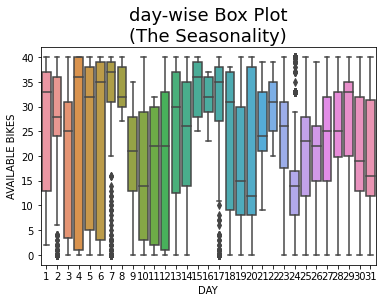

In [58]:
fig, axes = plt.subplots()
sns.boxplot(x='DAY', y='AVAILABLE BIKES', data=df_heuston)

# Set Title
axes.set_title('day-wise Box Plot\n(The Seasonality)', fontsize=18)

plt.show()

In [59]:

# ADF Test
adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(df_townsend["AVAILABLE BIKES"].values)
print('ADF test statistic:', adf)
print('ADF p-values:', pval)
print('ADF number of lags used:', usedlag)
print('ADF number of observations:', nobs)
print('ADF critical values:', crit_vals)
print('ADF best information criterion:', icbest)

# result = adfuller(df_townsend["AVAILABLE BIKES"].values, autolag='AIC')
# print(f'ADF Statistic: {result[0]}')
# print(f'p-value: {result[1]}')
# for key, value in result[4].items():
#     print('Critial Values:')
#     print(f'   {key}, {value}')

# KPSS Test
result = kpss(df_townsend["AVAILABLE BIKES"].values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(df_heuston["AVAILABLE BIKES"].values)
print('ADF test statistic:', adf)
print('ADF p-values:', pval)
print('ADF number of lags used:', usedlag)
print('ADF number of observations:', nobs)
print('ADF critical values:', crit_vals)
print('ADF best information criterion:', icbest)

ADF test statistic: -13.025582772850973
ADF p-values: 2.4034956044822547e-24
ADF number of lags used: 13
ADF number of observations: 20356
ADF critical values: {'1%': -3.430671287326264, '5%': -2.8616819978431063, '10%': -2.566845581548129}
ADF best information criterion: 54544.329626411876

KPSS Statistic: 0.947522
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


ADF test statistic: -12.484683189832197
ADF p-values: 3.0370642469266025e-23
ADF number of lags used: 35
ADF number of observations: 20333
ADF critical values: {'1%': -3.4306716508014876, '5%': -2.8616821584778327, '10%': -2.5668456670510897}
ADF best information criterion: 58480.095551973194


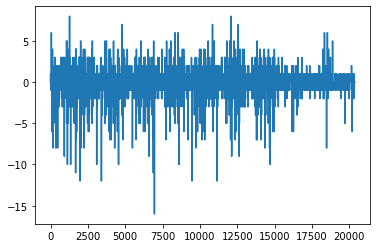

In [60]:
bvals = df_townsend["AVAILABLE BIKES"].shift()
diff_bvals = df_townsend["AVAILABLE BIKES"].values - bvals
diff_bvals.plot()

# Predictions for townsend


In [61]:
df2 = pd.read_csv("df_townsend.csv", usecols = ['TIME','AVAILABLE BIKES'], parse_dates=['TIME'])
df2.head()

TIME  AVAILABLE BIKES
0 2020-01-01 06:25:02                8
1 2020-01-01 06:30:02                8
2 2020-01-01 06:35:02                8
3 2020-01-01 06:40:03                9
4 2020-01-01 06:45:02                9

2 1 3

0 to y-5

i from 1 to 3
make columns for available bikes, i to y-2-(3-i)
1 to y-4
2 to y-3
3 to y-2

         yy
1 2 3 4  6
2 3 4 5  7
3 4 5 6  8
4 5 6 7  9
5 6 7 8  4

6
7
8
9
4

last 3 lags and q steps ahead from current

Index(['TIME', 'MONTH', 'DAY_OF_WEEK', 'WEEKEND', 'HOUR', 'MINUTE', 'DAY',
       'BIKE STANDS', 'AVAILABLE BIKE STANDS', 'AVAILABLE BIKES'],
      dtype='object')
data sampling interval is 300 secs
q=2,samples=1,lag=3
XX:
17409
y:
17414
0.0 [ 0.19658109  0.27995465  0.45859261  0.00833687  0.0500229   0.01500164
 -0.00318773  0.00672803  0.0142582 ]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.8974856063844643
rmse: 1.773299496088318


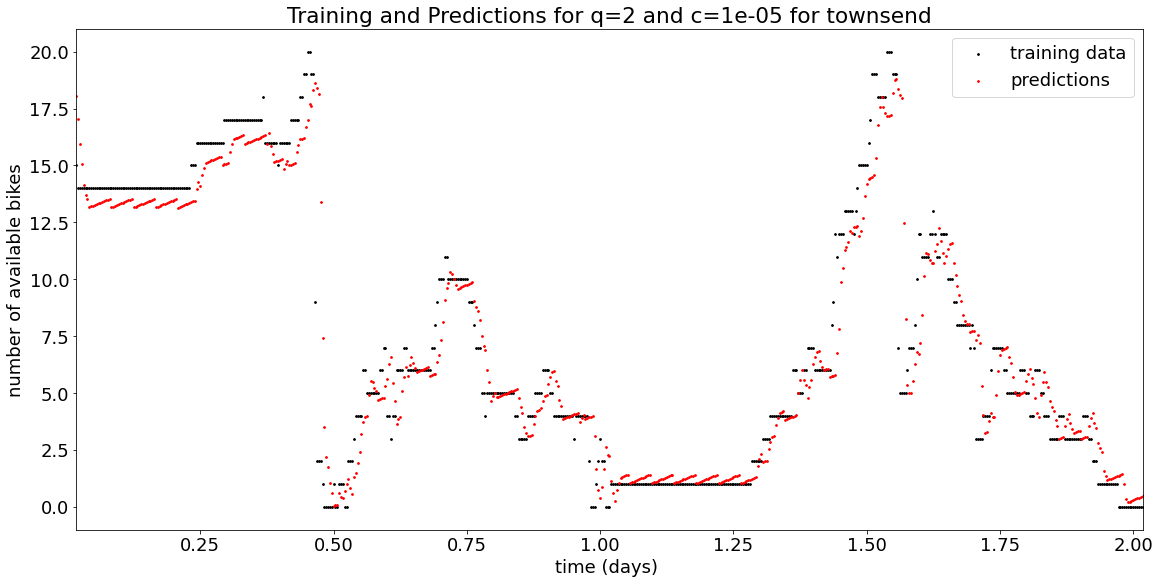

0.0 [-0.01616741  0.12377159  0.84404611  0.04167907  0.13607715  0.00220343
 -0.00897271  0.00226191  0.01080127]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.9099999945678531
rmse: 1.6618239665275971


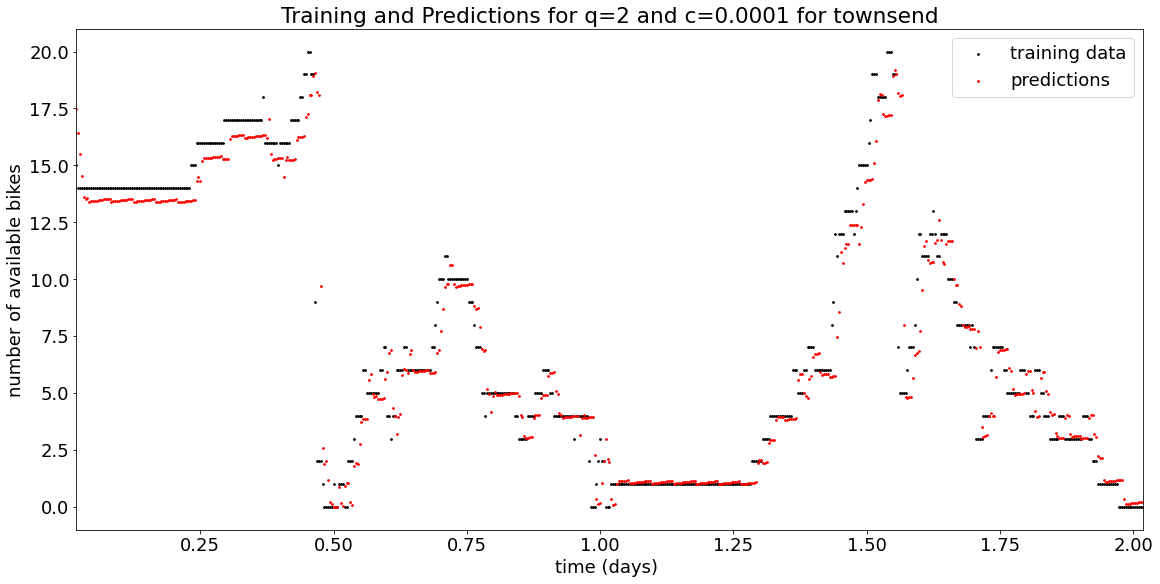

0.0 [-0.04823629 -0.0310782   1.03063453  0.10755096  0.17591766 -0.00638014
 -0.01076053  0.00114847  0.01112058]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.9118563002732759
rmse: 1.6454613446420308


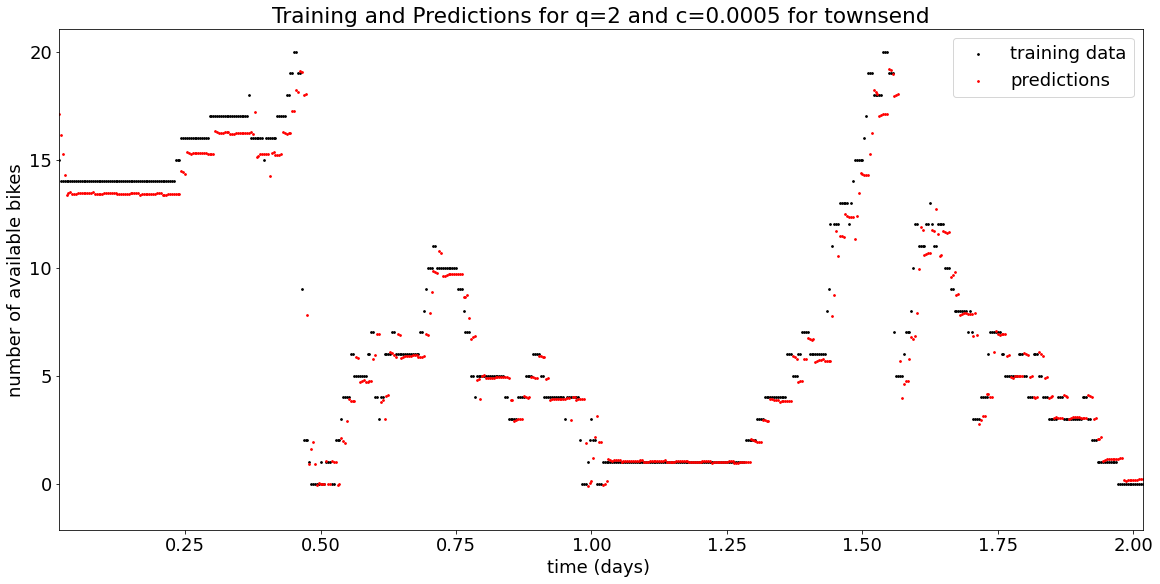

0.0 [-4.66814957e-02 -6.98032937e-02  1.06755236e+00  1.38347376e-01
  1.82304885e-01 -8.23561186e-03 -1.11275138e-02  9.63756169e-04
  1.13429902e-02]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.911988249040421
rmse: 1.6443755207516852


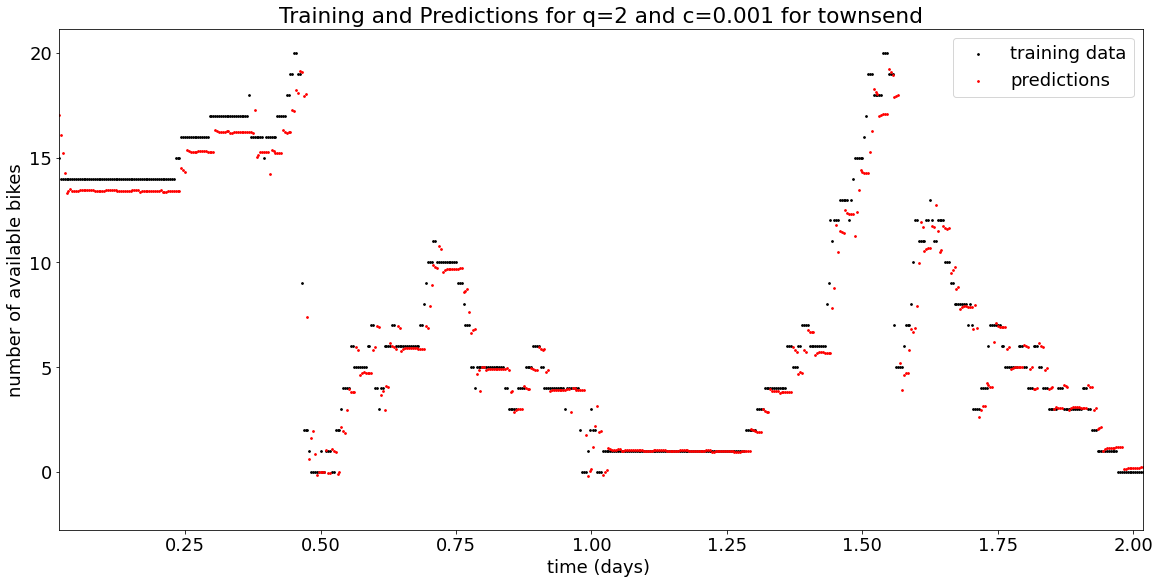

0.0 [-4.29529269e-02 -1.07572369e-01  1.10125461e+00  1.81266372e-01
  1.87326755e-01 -1.01045634e-02 -1.14919966e-02  8.02497632e-04
  1.16671855e-02]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.9120423699587078
rmse: 1.6439686018166264


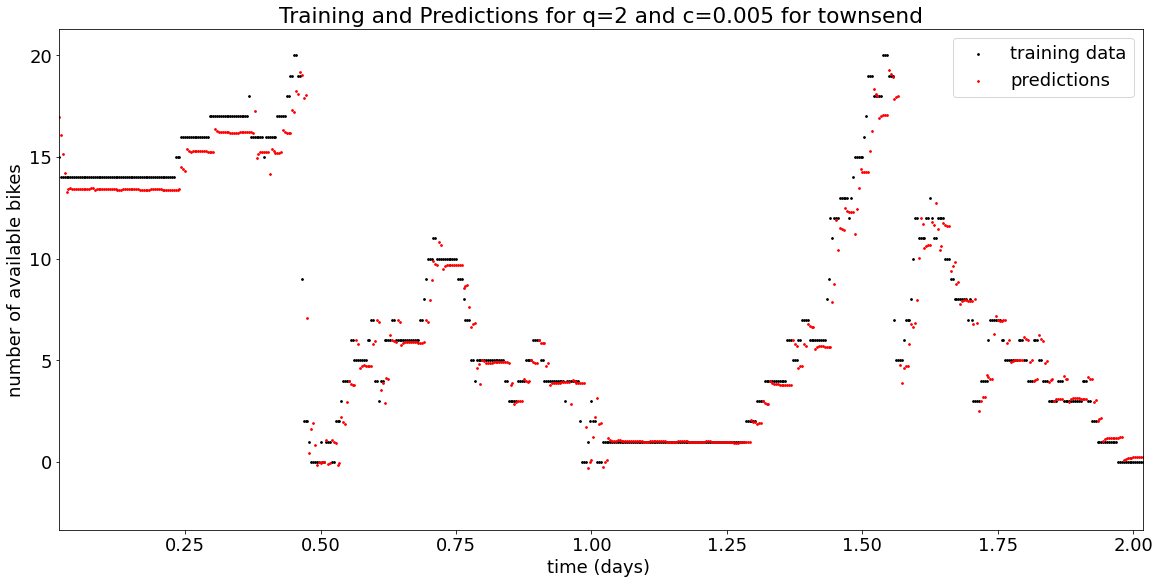

0.0 [-4.22883020e-02 -1.12816250e-01  1.10577625e+00  1.88717320e-01
  1.87923196e-01 -1.03774636e-02 -1.15447800e-02  7.81202717e-04
  1.17244578e-02]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.9120444310310516
rmse: 1.6439585800893572


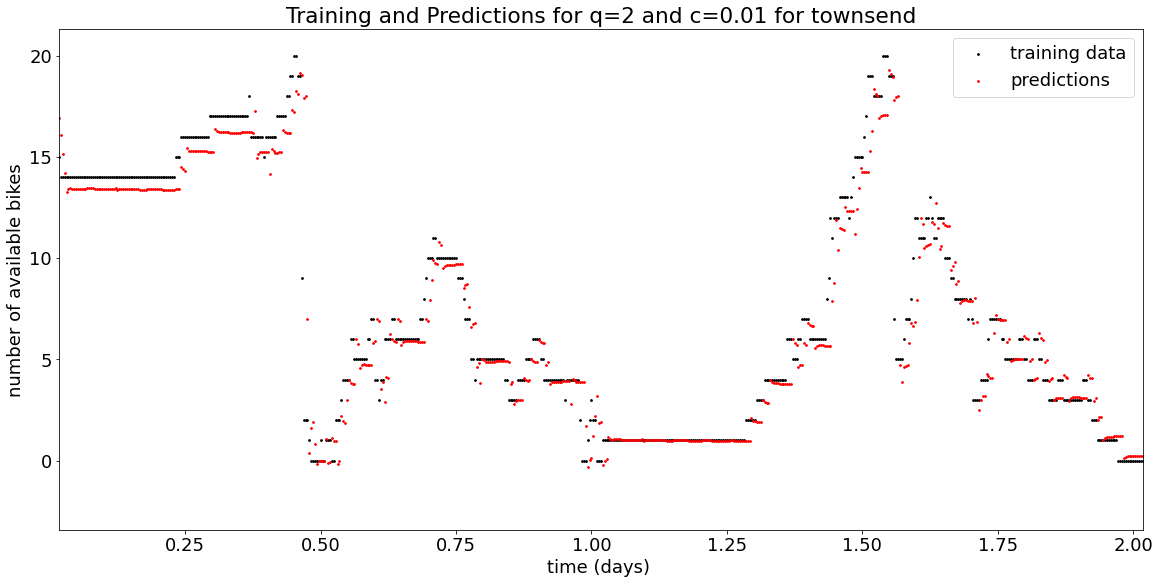

0.0 [-4.17205214e-02 -1.17105027e-01  1.10944763e+00  1.95159260e-01
  1.88391218e-01 -1.06044187e-02 -1.15885919e-02  7.63940624e-04
  1.17741477e-02]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.9120451171347291
rmse: 1.643958746172026


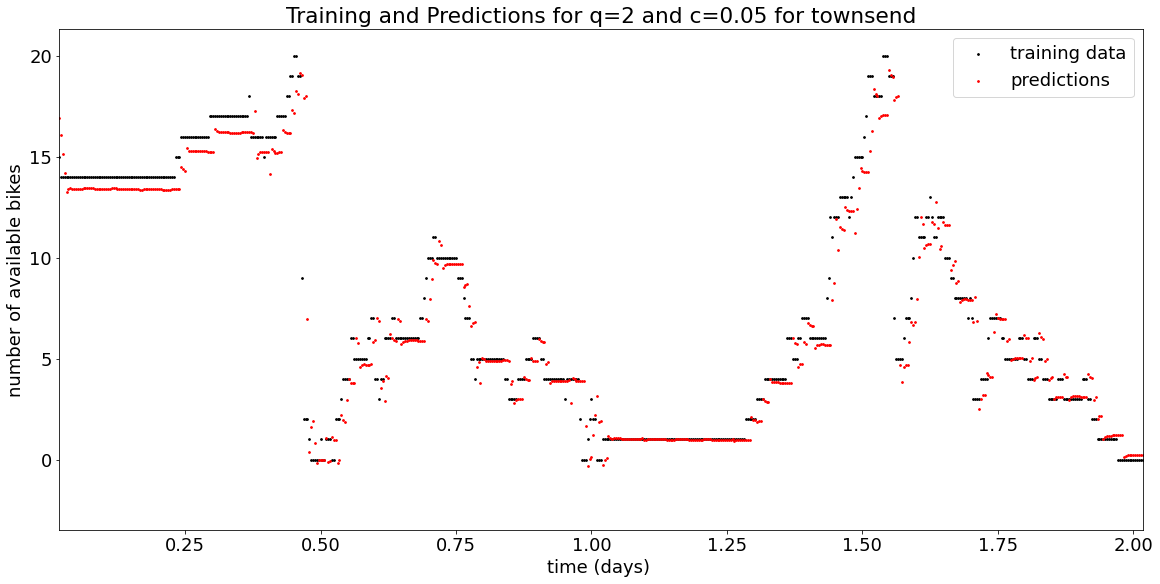

0.0 [-4.16472370e-02 -1.17647114e-01  1.10990999e+00  1.95997164e-01
  1.88449078e-01 -1.06333689e-02 -1.15941749e-02  7.61767963e-04
  1.17806220e-02]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.9120451391275778
rmse: 1.6439593064065041


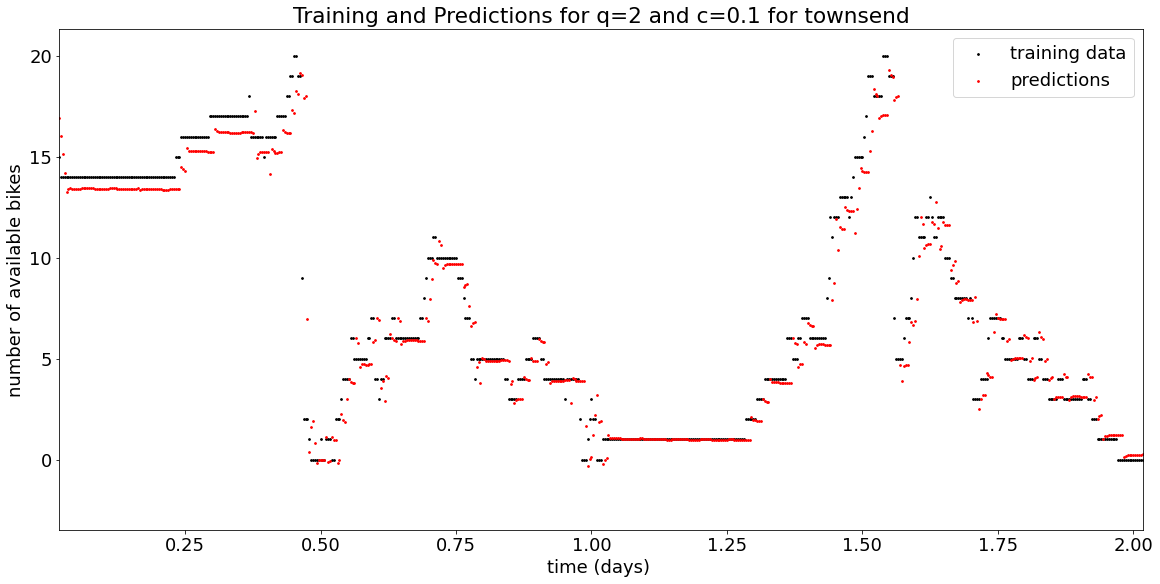

0.0 [-4.15882348e-02 -1.18081754e-01  1.11028043e+00  1.96672945e-01
  1.88495256e-01 -1.06566256e-02 -1.15986591e-02  7.60027381e-04
  1.17858453e-02]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.912045146195222
rmse: 1.6439598434255898


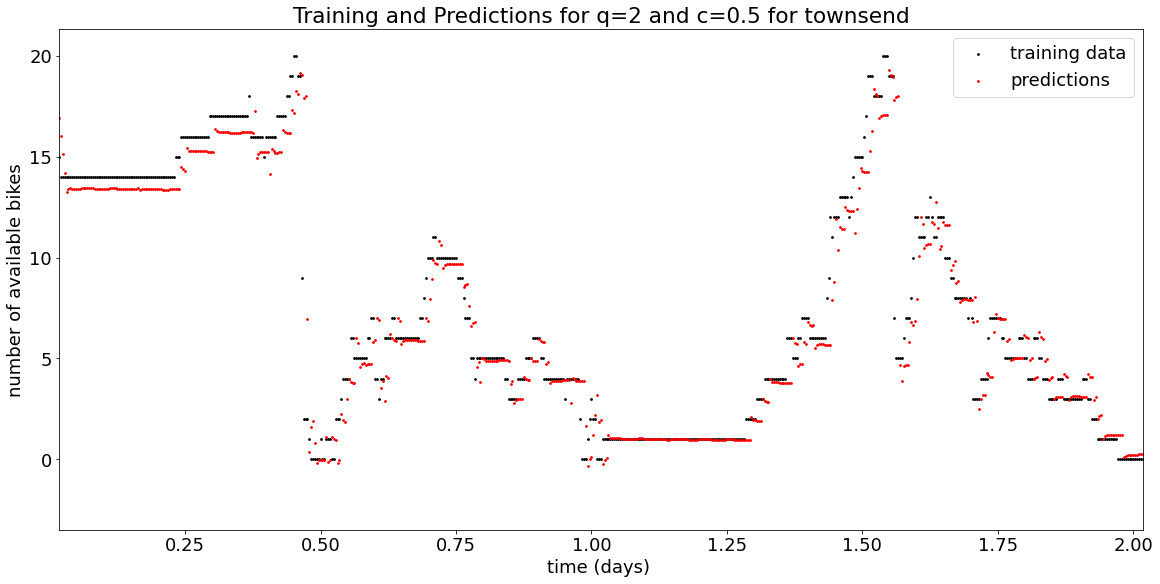

0.0 [-4.15808361e-02 -1.18136144e-01  1.11032677e+00  1.96757762e-01
  1.88501021e-01 -1.06595387e-02 -1.15992208e-02  7.59809654e-04
  1.17865010e-02]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.9120451464166663
rmse: 1.6439599161368013


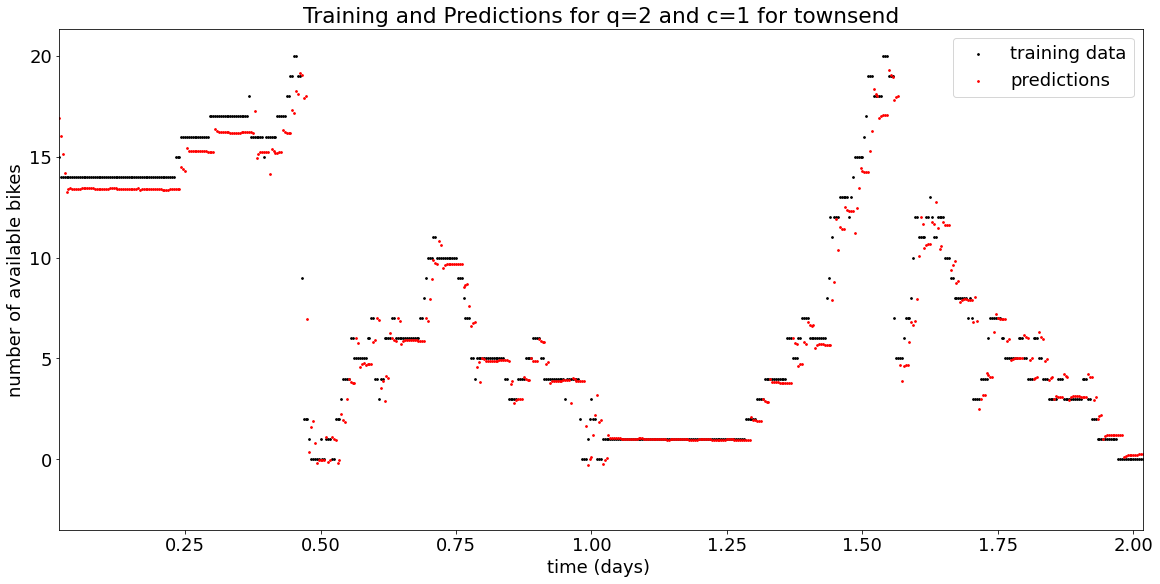

0.0 [-4.15749133e-02 -1.18179667e-01  1.11036385e+00  1.96825671e-01
  1.88505632e-01 -1.06618703e-02 -1.15996702e-02  7.59635448e-04
  1.17870260e-02]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.9120451464875589
rmse: 1.6439599752018352


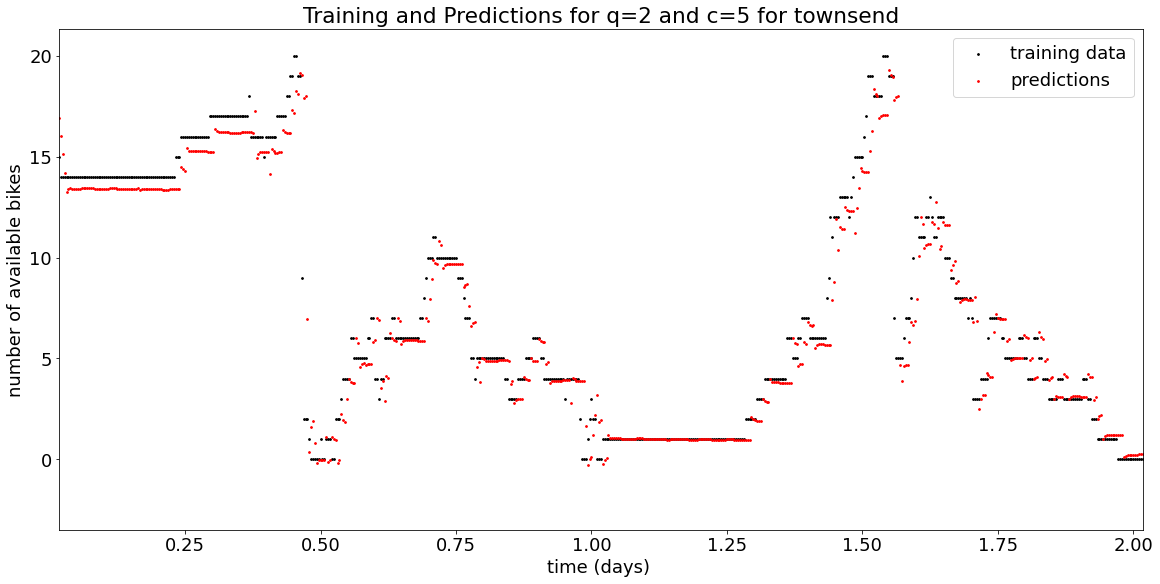

0.0 [-4.15741727e-02 -1.18185108e-01  1.11036848e+00  1.96834163e-01
  1.88506208e-01 -1.06621618e-02 -1.15997264e-02  7.59613671e-04
  1.17870916e-02]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.9120451464897749
rmse: 1.6439599826410007


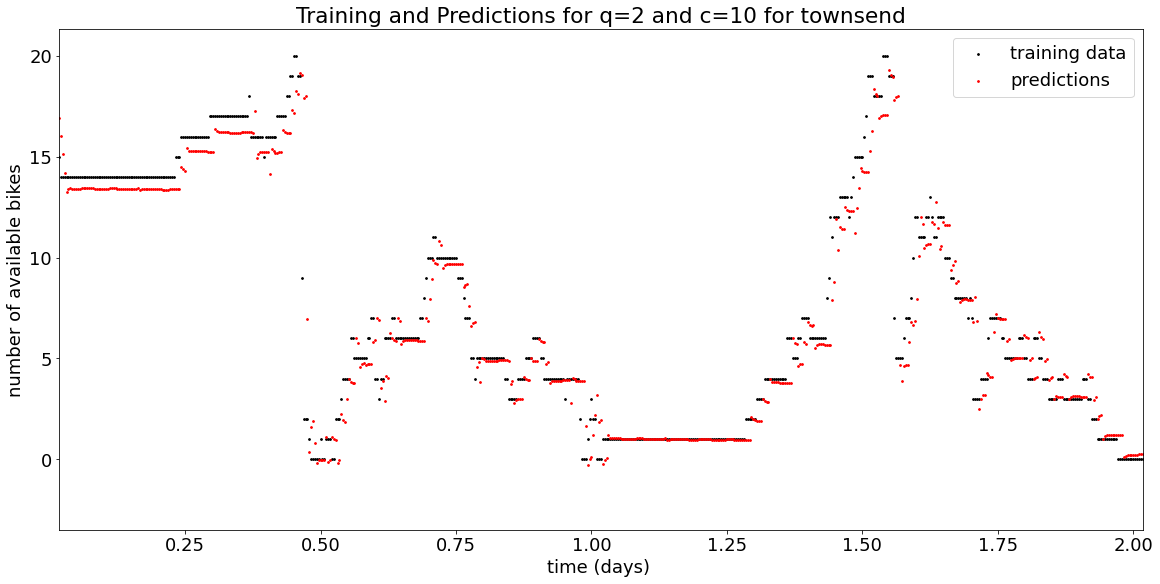

0.0 [-4.15735802e-02 -1.18189460e-01  1.11037219e+00  1.96840957e-01
  1.88506669e-01 -1.06623950e-02 -1.15997714e-02  7.59596249e-04
  1.17871442e-02]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.912045146490484
rmse: 1.6439599886013019


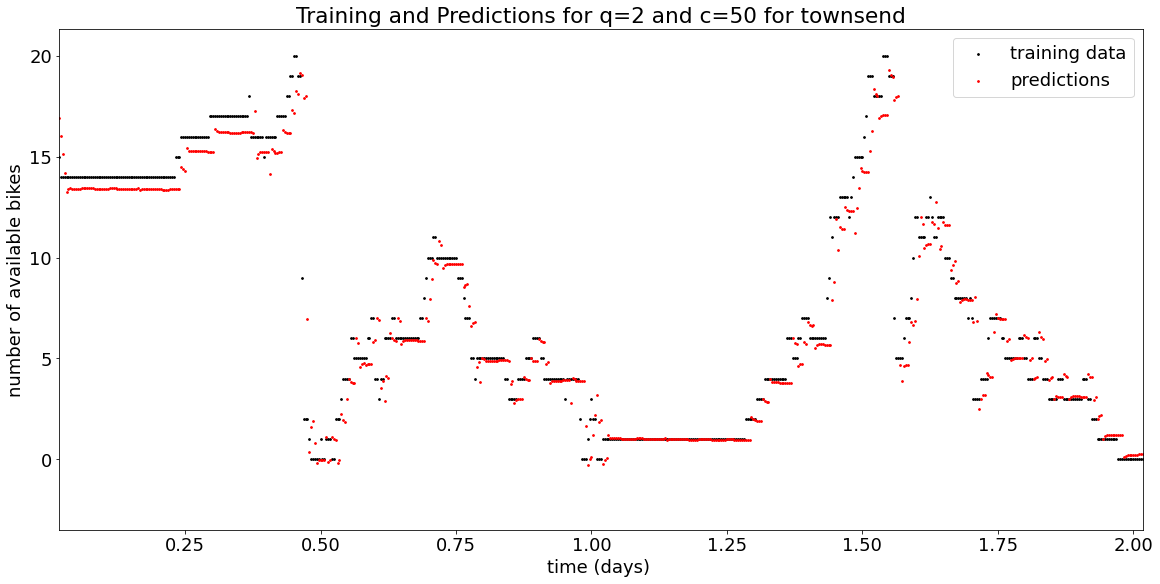

0.0 [-4.15735062e-02 -1.18190005e-01  1.11037265e+00  1.96841807e-01
  1.88506727e-01 -1.06624241e-02 -1.15997770e-02  7.59594071e-04
  1.17871507e-02]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.9120451464905062
rmse: 1.6439599893469001


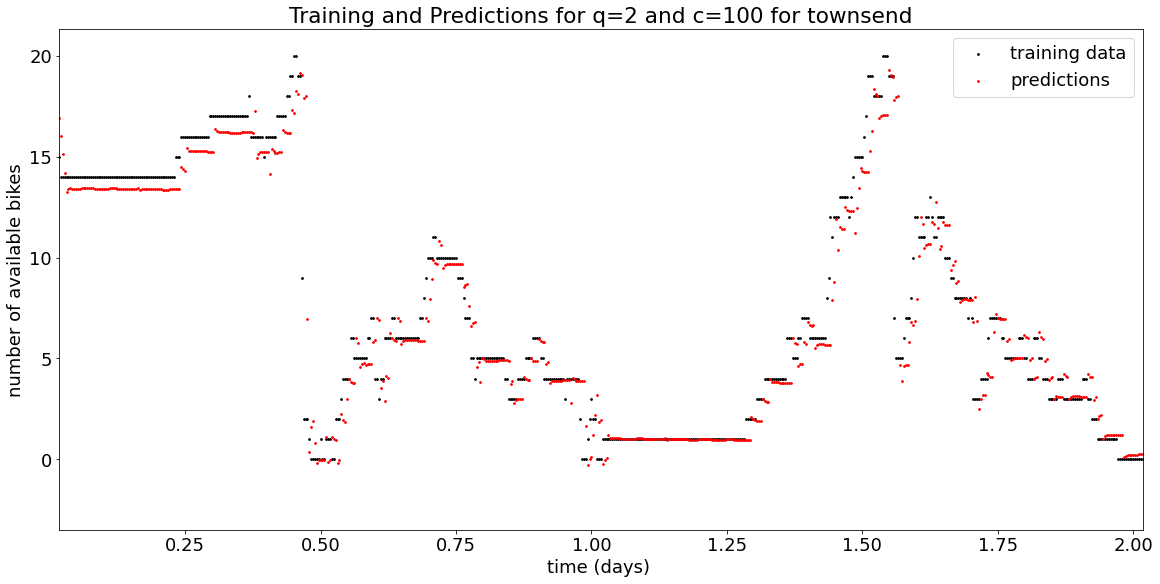

0.0 [-4.15734395e-02 -1.18190494e-01  1.11037307e+00  1.96842571e-01
  1.88506779e-01 -1.06624504e-02 -1.15997821e-02  7.59592111e-04
  1.17871566e-02]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.9120451464905135
rmse: 1.6439599900180448


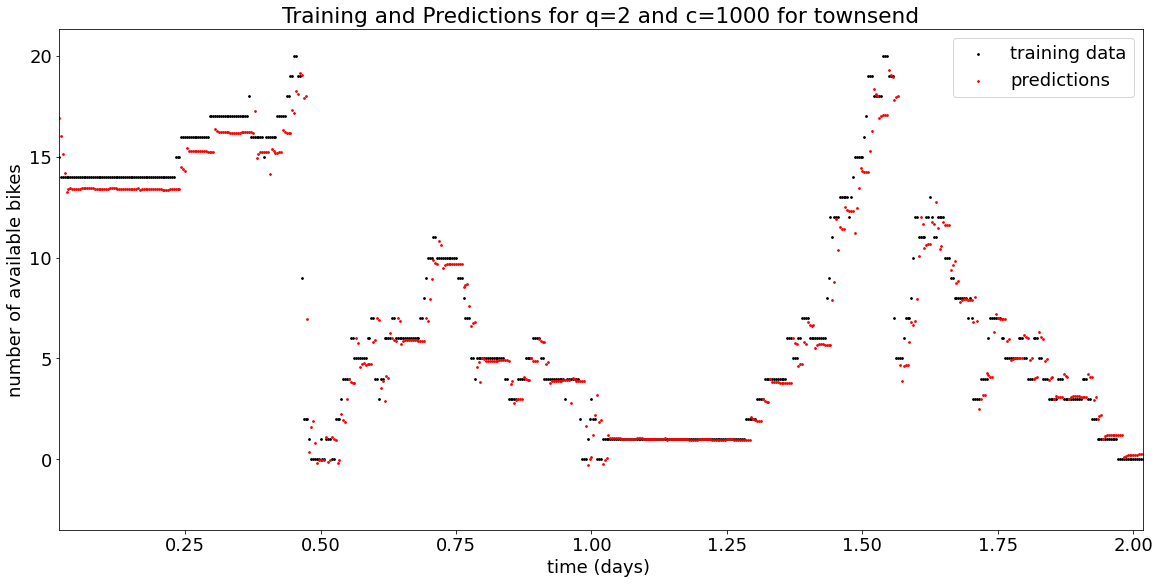

minimum c:0.01
1.6439585800893572
q=6,samples=d,lag=3
XX:
16544
y:
17414
0.0 [ 0.22132783  0.16901464  0.21994076 -0.06550689  0.12271816  0.40090623
  0.00893481  0.0263766   0.06063718]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.130154516571225
rmse: 5.334449292989965


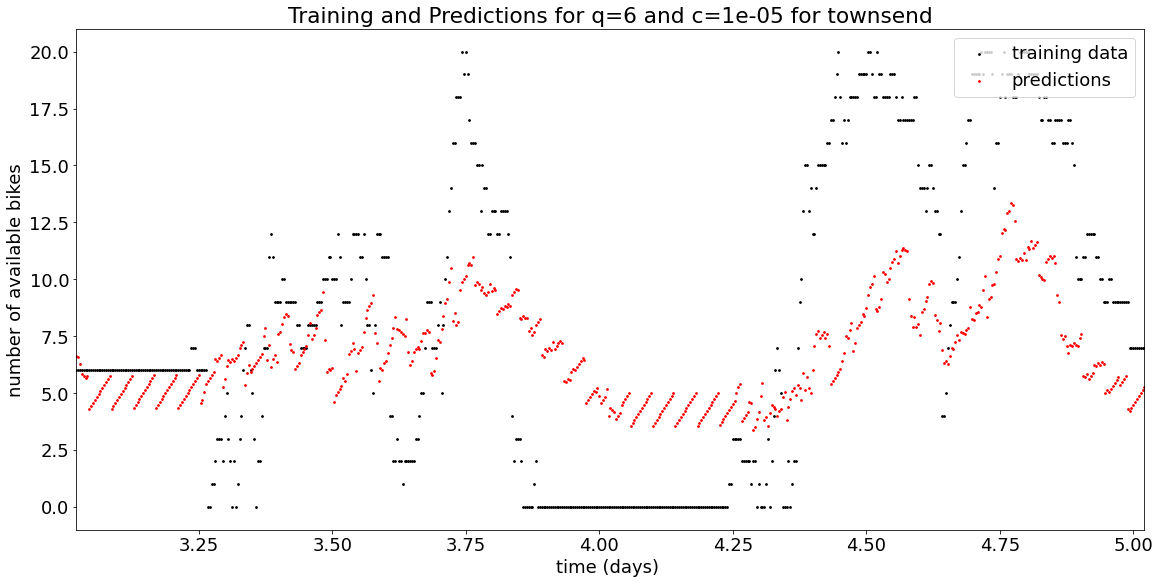

0.0 [ 0.22482482  0.15906155  0.20967861 -0.635809    0.34284343  0.64096823
 -0.02015949  0.01584724  0.04791387]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.15268949778899465
rmse: 5.267832854961508


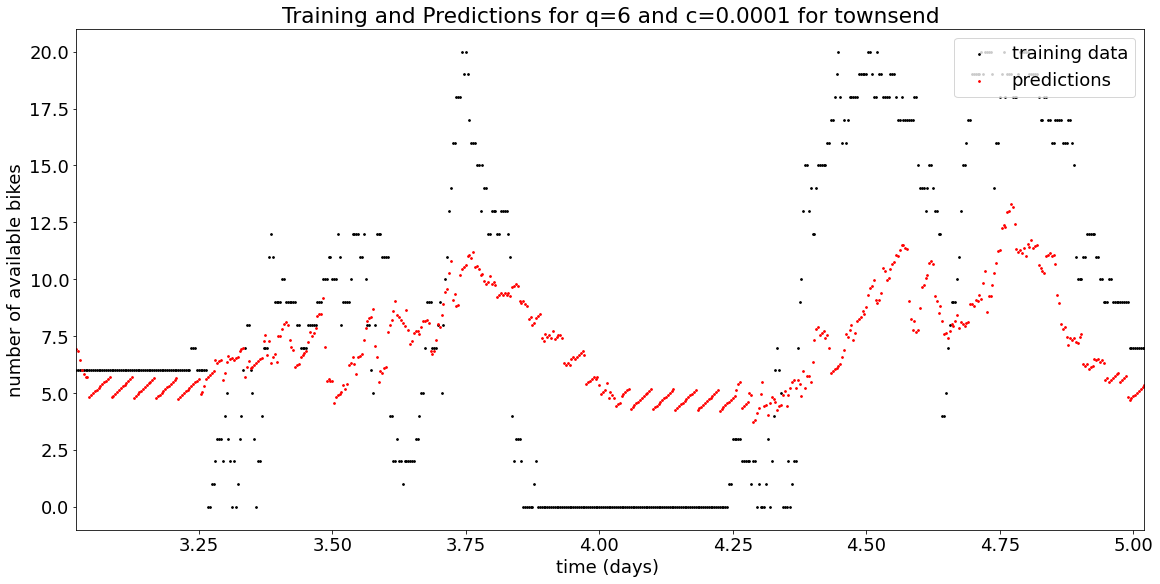

0.0 [ 0.23002237  0.15983466  0.19511863 -1.92756864  0.52220285  0.68672048
 -0.02479304  0.0139691   0.03780958]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.16770362679962247
rmse: 5.227907809428924


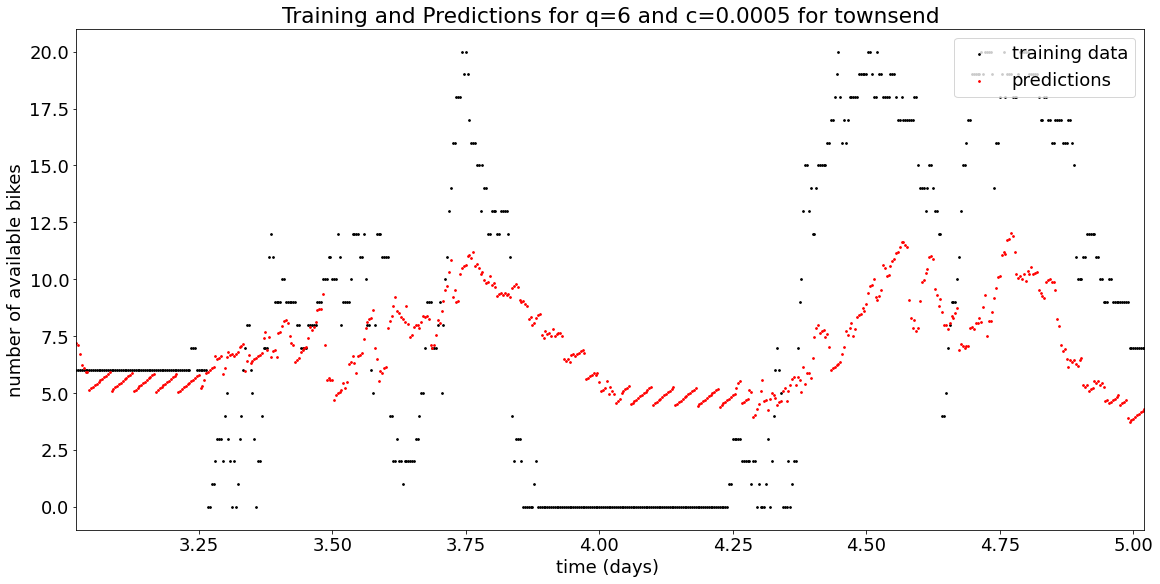

0.0 [ 0.23362639  0.16163475  0.18897689 -2.56188399  0.57906425  0.69931871
 -0.02458955  0.01377446  0.03295715]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.17209291850032682
rmse: 5.218037836870775


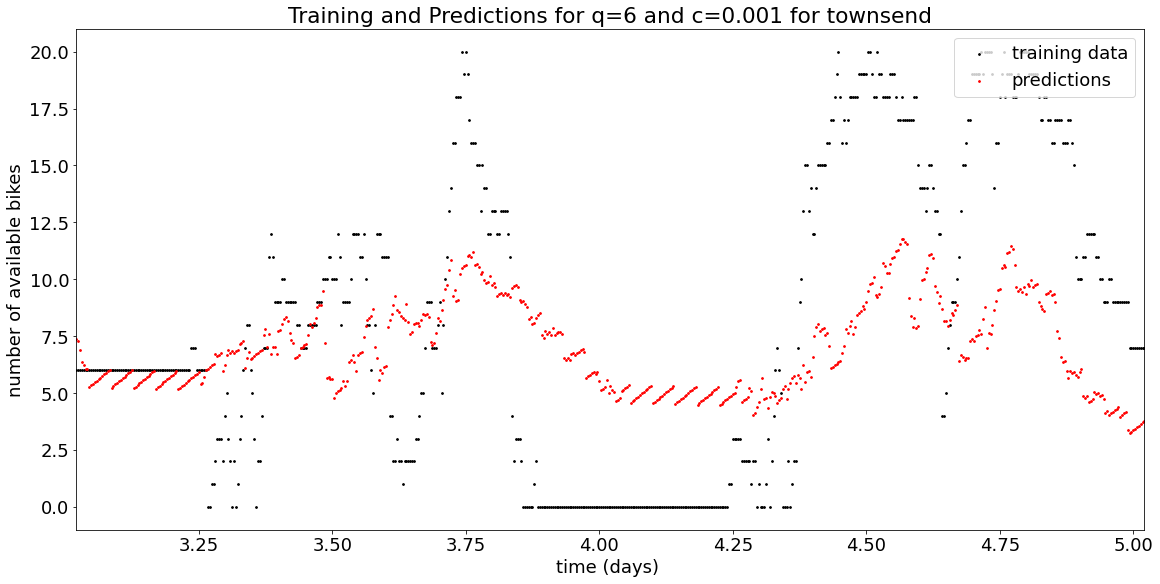

0.0 [ 0.23920471  0.16467587  0.18052811 -3.46964473  0.64897324  0.71568399
 -0.02355714  0.01370317  0.02597864]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.1752567428416374
rmse: 5.2136355005812565


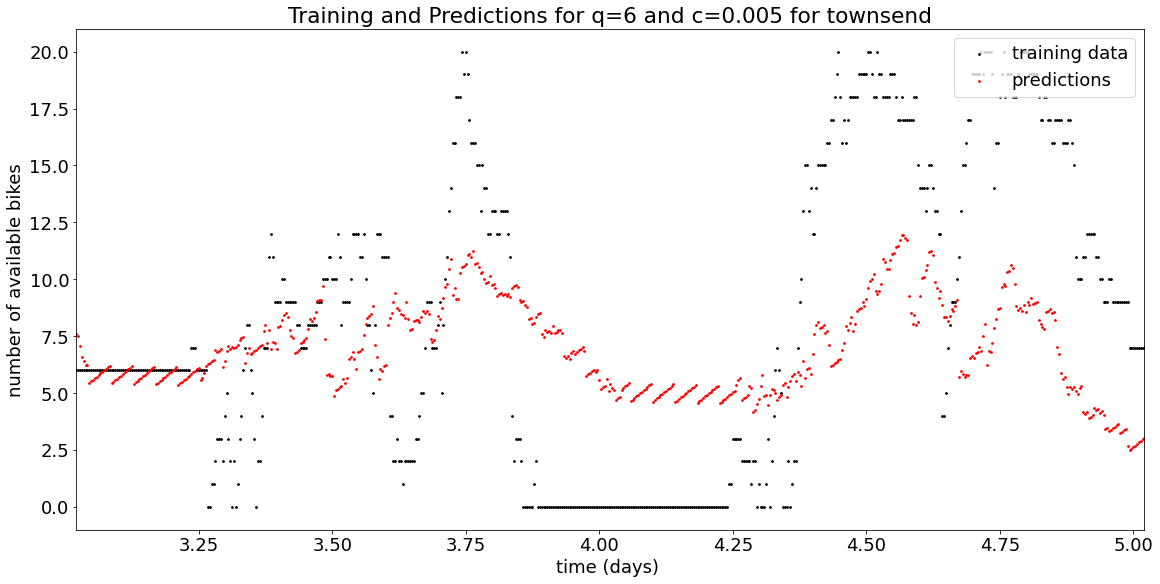

0.0 [ 0.24022123  0.16524655  0.17906157 -3.62989057  0.66045978  0.71847664
 -0.02332203  0.0137052   0.02474314]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.17543724403834438
rmse: 5.214024137368612


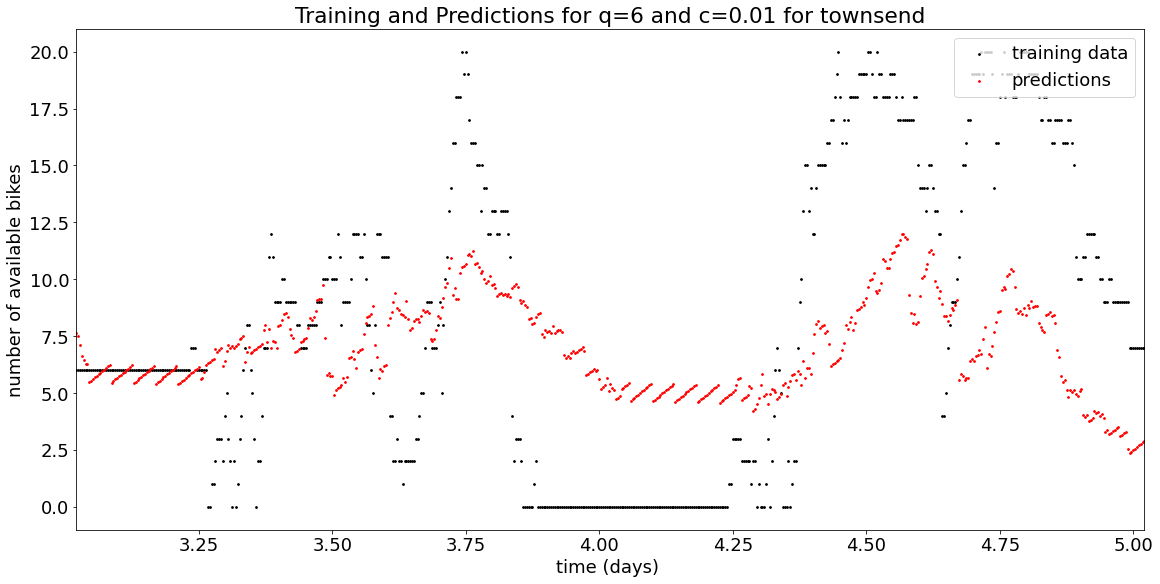

0.0 [ 0.24110973  0.16574812  0.17779235 -3.76905539  0.67028293  0.72088719
 -0.02310864  0.01370949  0.02366945]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.17550222108786373
rmse: 5.214643090387351


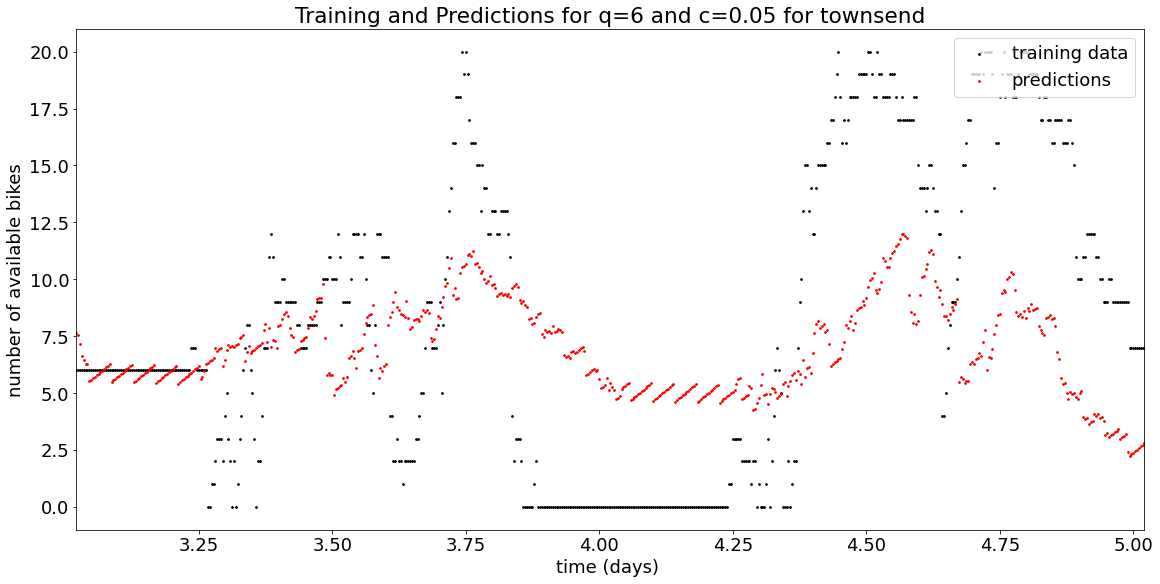

0.0 [ 0.24122593  0.16581389  0.17762716 -3.78719866  0.67155389  0.72120055
 -0.02308024  0.01371021  0.02352943]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.1755044086609736
rmse: 5.214743027989611


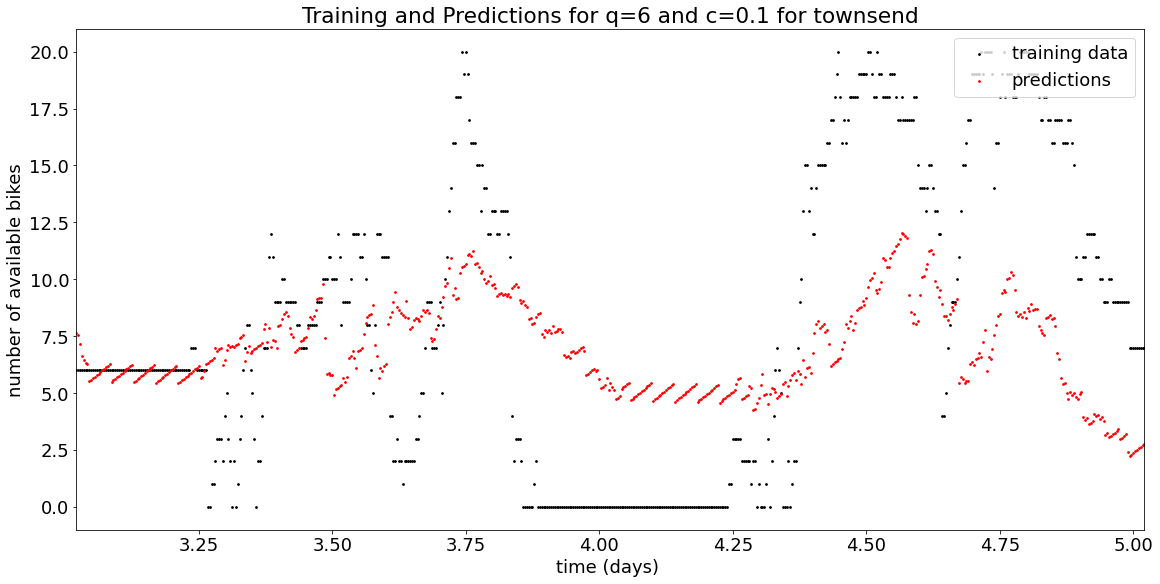

0.0 [ 0.24131975  0.16586702  0.17749391 -3.80183852  0.67257787  0.72145326
 -0.02305722  0.01371082  0.02341643]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.17550511740126162
rmse: 5.214826900787944


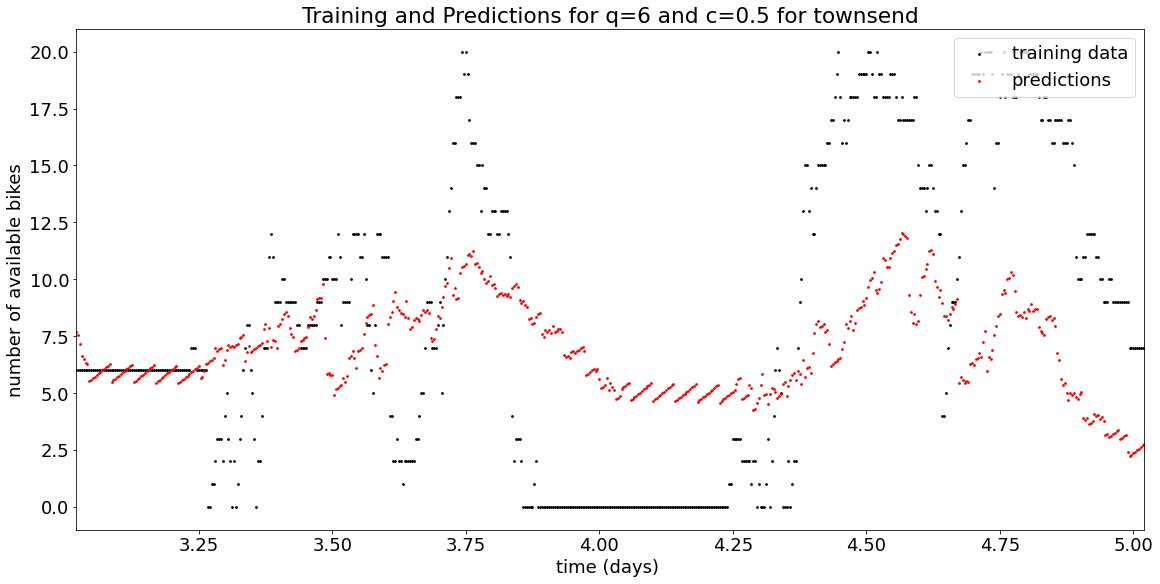

0.0 [ 0.24133153  0.16587369  0.17747719 -3.8036764   0.67270633  0.72148498
 -0.02305433  0.01371089  0.02340224]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.1755051397192111
rmse: 5.214837634095119


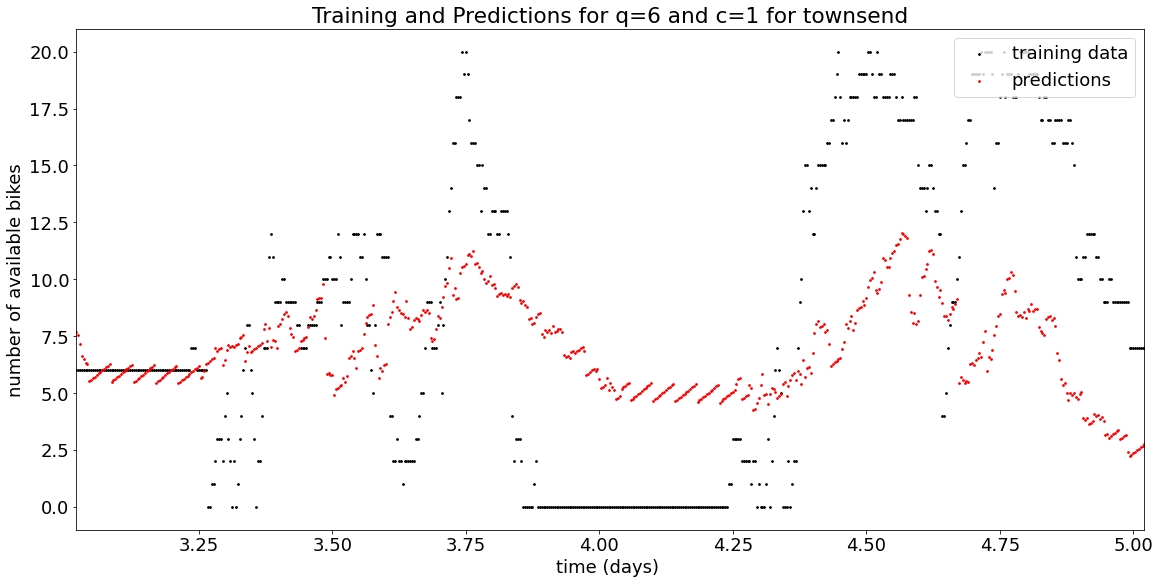

0.0 [ 0.24134097  0.16587904  0.1774638  -3.80514798  0.67280916  0.72151037
 -0.02305201  0.01371096  0.02339089]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.17550514686984453
rmse: 5.214846260951805


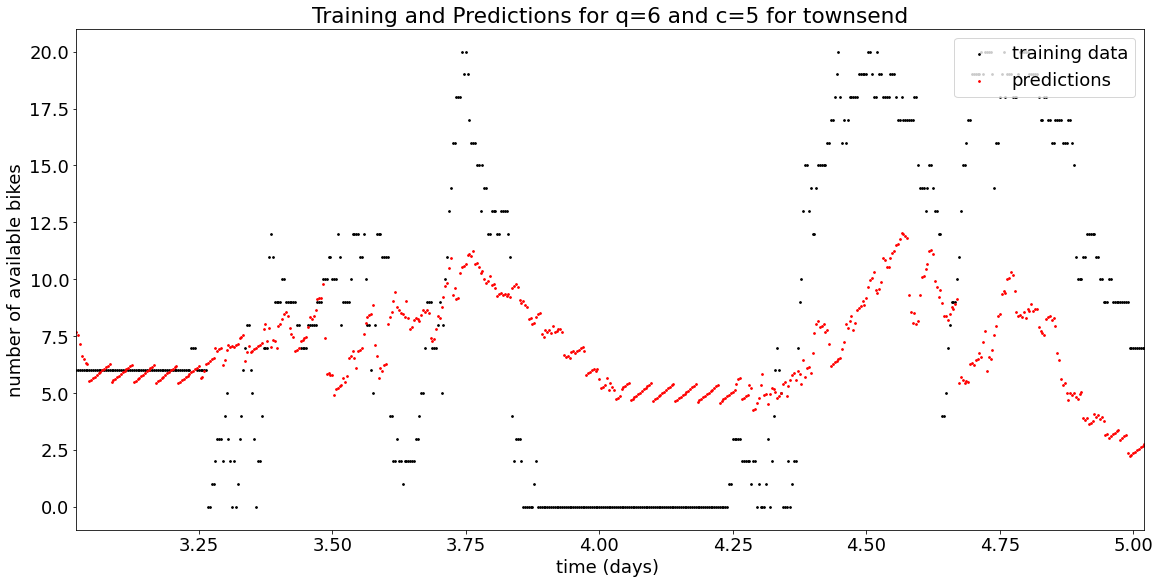

0.0 [ 0.24134215  0.16587971  0.17746212 -3.80533201  0.67282202  0.72151355
 -0.02305172  0.01371096  0.02338947]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.17550514709347298
rmse: 5.214847341826195


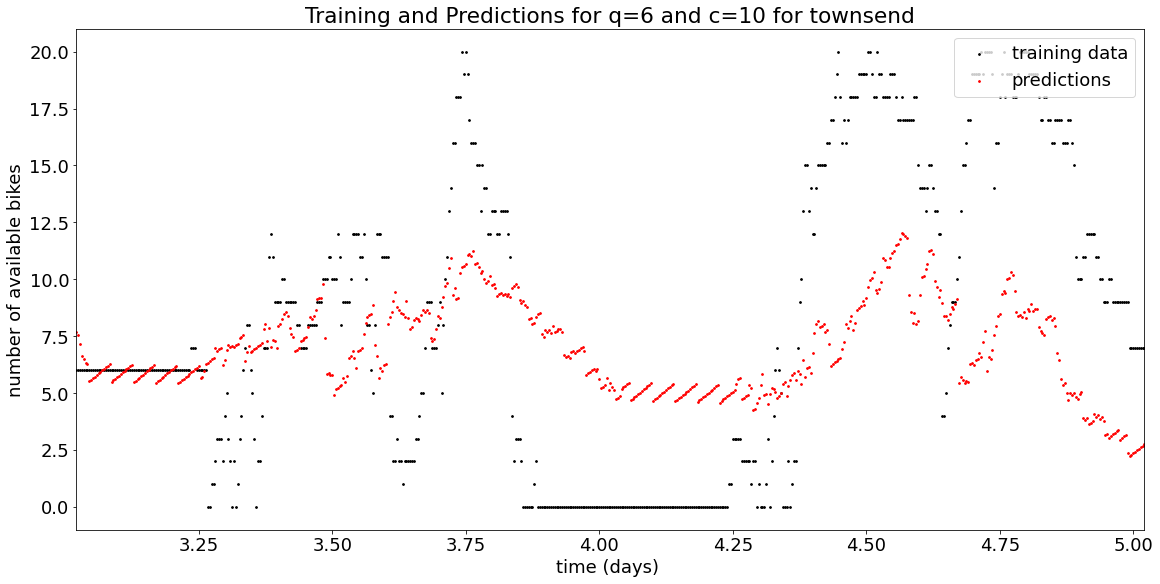

0.0 [ 0.24134309  0.16588024  0.17746078 -3.80547924  0.67283231  0.72151609
 -0.02305149  0.01371097  0.02338833]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.17550514716504295
rmse: 5.214848206928817


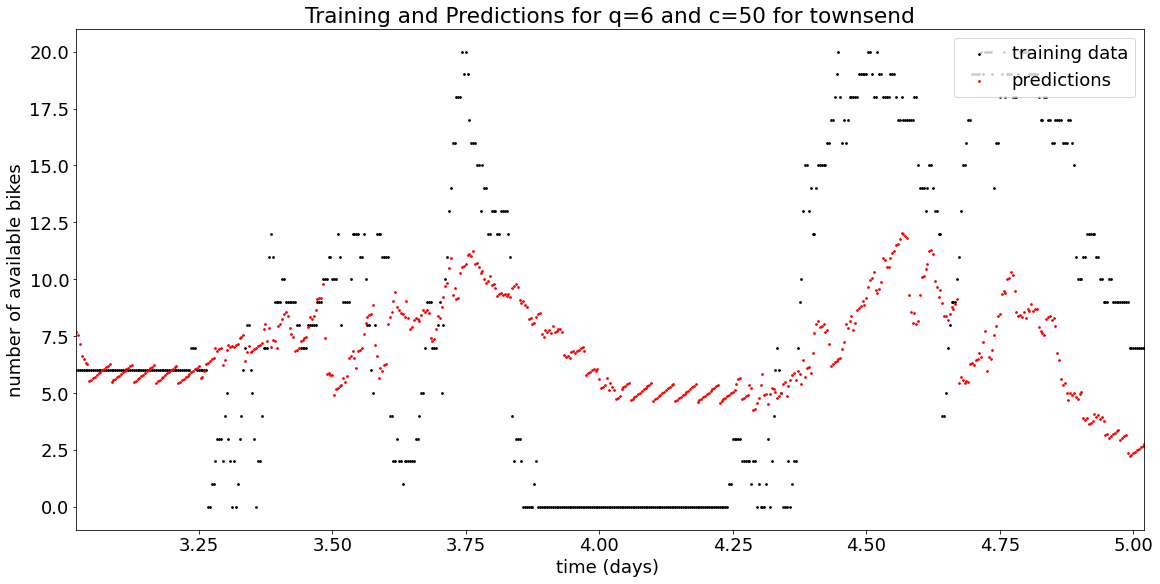

0.0 [ 0.24134321  0.16588031  0.17746061 -3.80549764  0.67283359  0.7215164
 -0.02305146  0.01371097  0.02338819]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.17550514716727972
rmse: 5.214848315091843


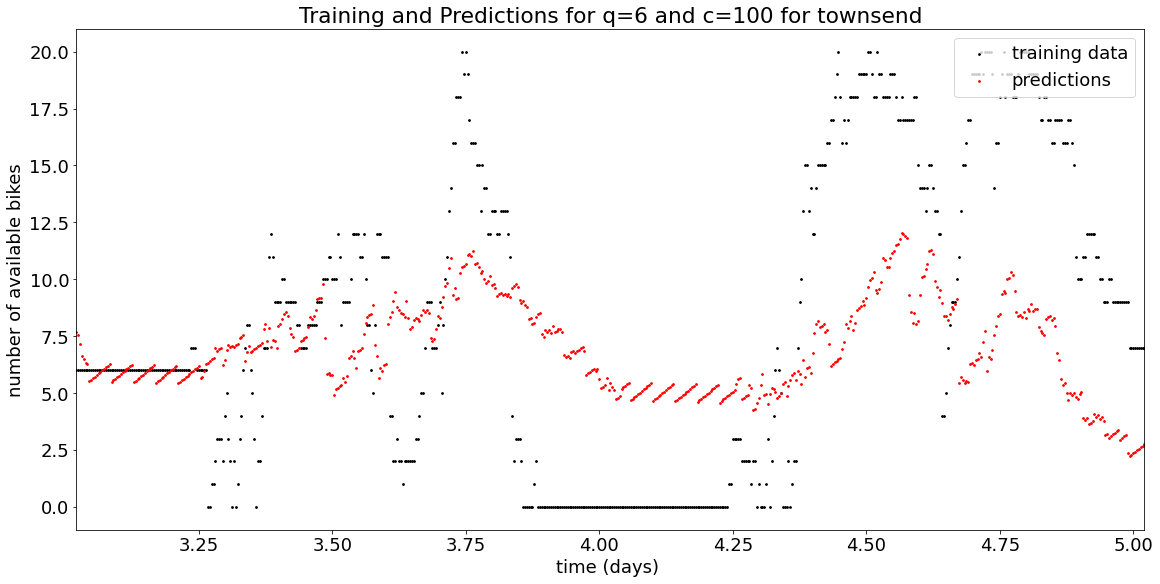

0.0 [ 0.24134332  0.16588037  0.17746046 -3.80551421  0.67283475  0.72151669
 -0.02305143  0.01371097  0.02338806]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.1755051471680179
rmse: 5.214848412443355


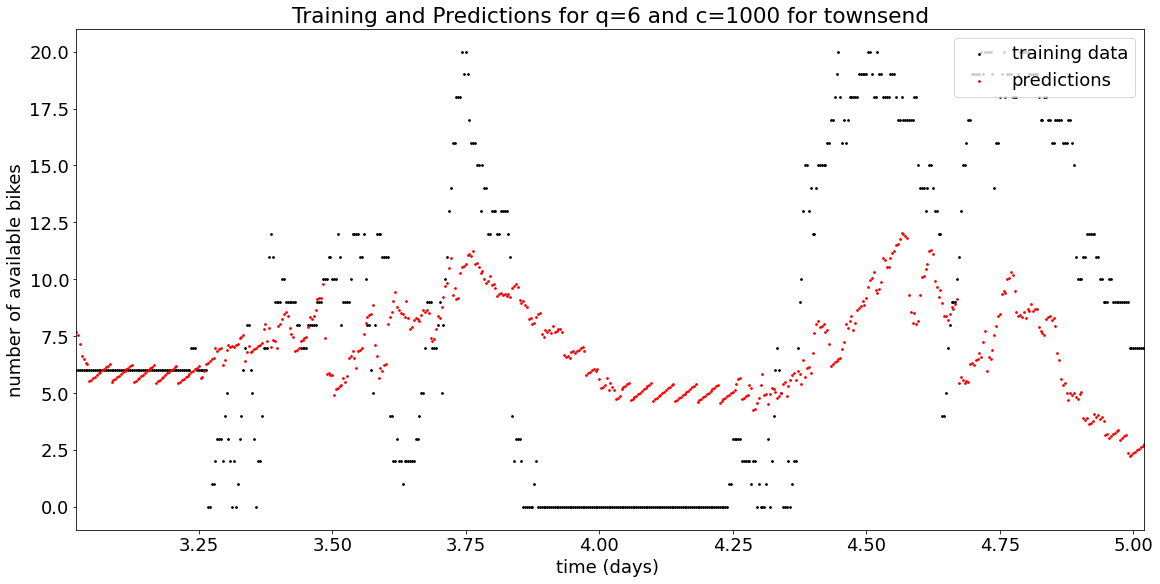

minimum c:0.005
5.2136355005812565
q=12,samples=d,lag=3
XX:
16538
y:
17414
0.0 [ 0.21370107  0.16192212  0.20030529 -0.06247749  0.14867324  0.41299054
  0.00574149  0.02988531  0.06891035]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.09646982127087189
rmse: 5.427302345435652


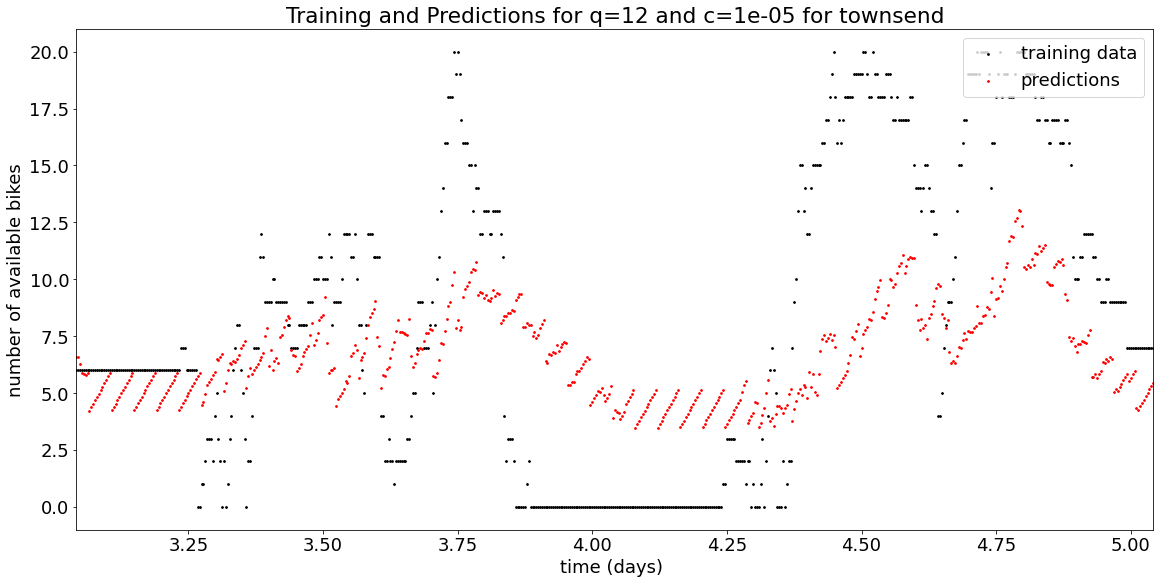

0.0 [ 0.21287686  0.14853044  0.1858342  -0.61733639  0.46764772  0.64931918
 -0.02821056  0.01829762  0.0578277 ]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.1213299188195569
rmse: 5.352736270290853


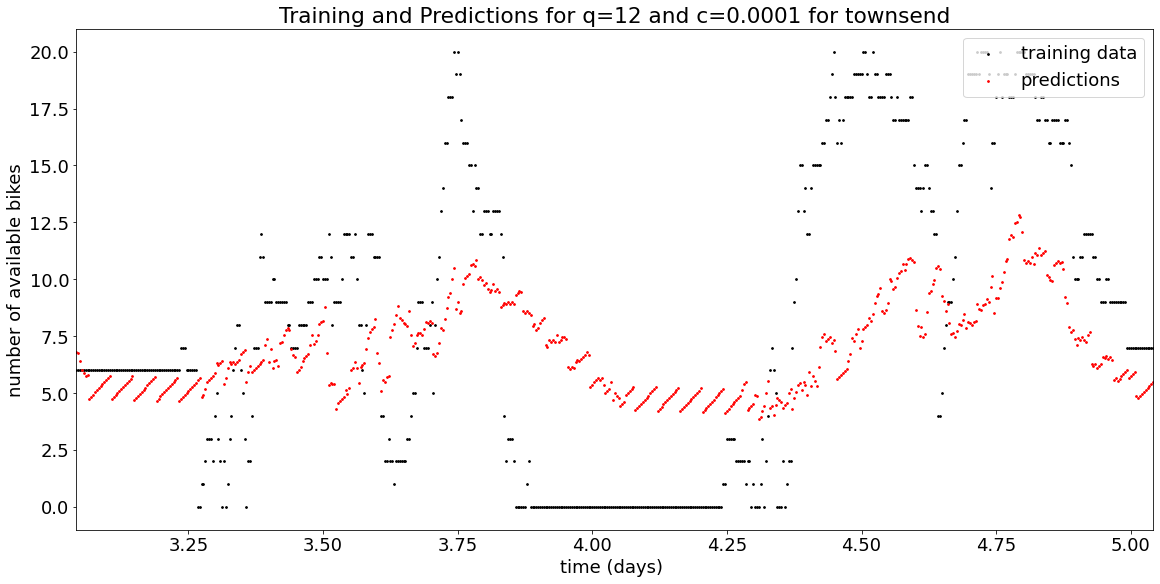

0.0 [ 0.21514386  0.14705344  0.1696663  -1.88356277  0.71238265  0.68658704
 -0.03566885  0.01575262  0.04881945]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.13635698985788747
rmse: 5.313790925610923


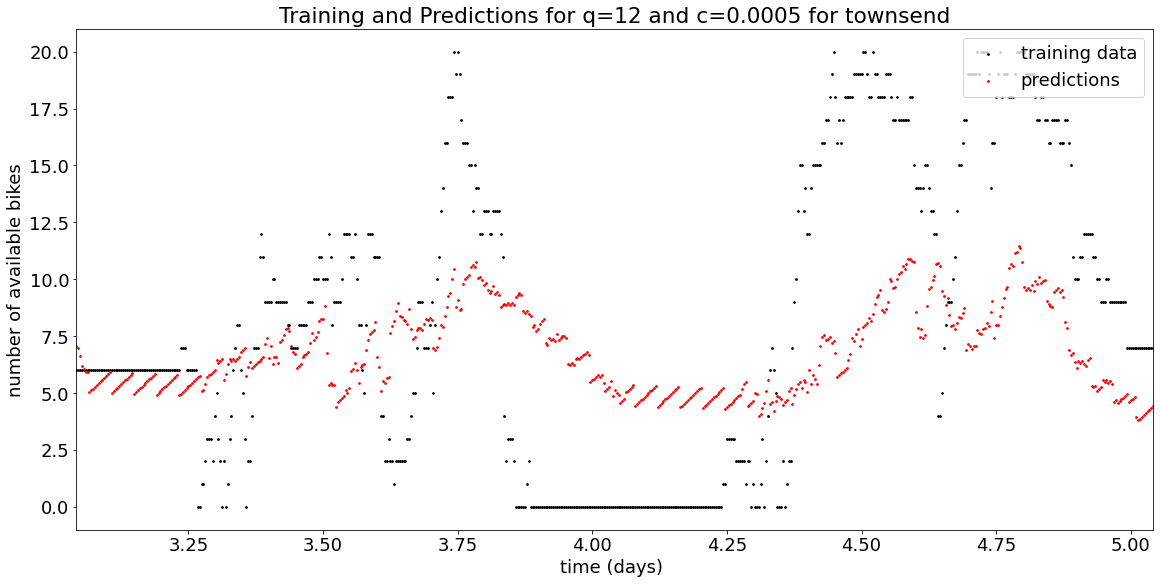

0.0 [ 0.21809672  0.14836705  0.1632605  -2.50647816  0.78244847  0.69721565
 -0.03605176  0.01541985  0.04423933]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.14063678575727412
rmse: 5.305083189424219


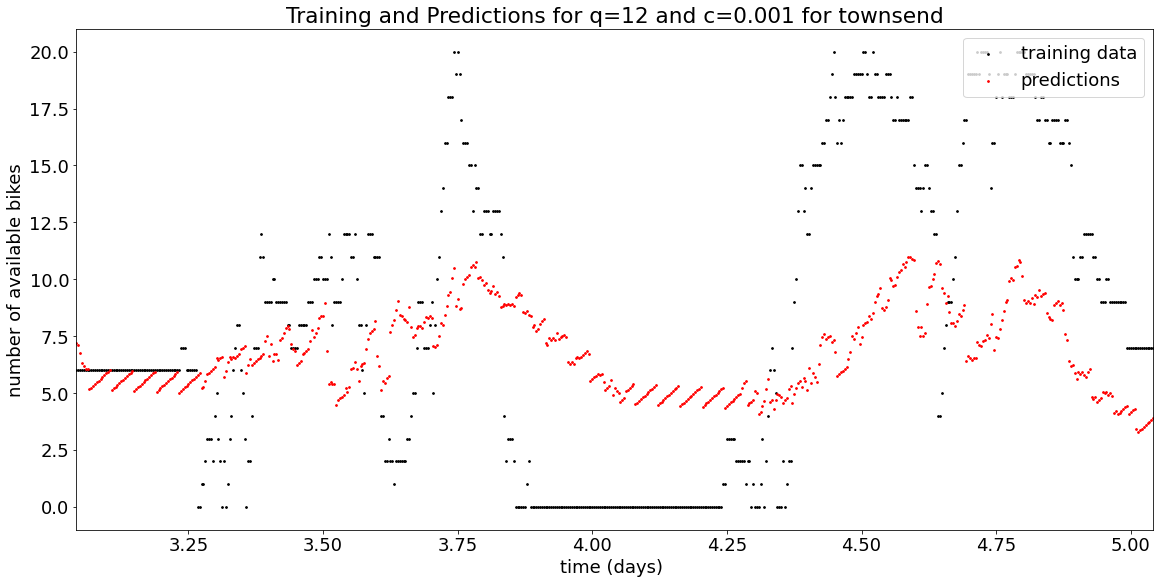

0.0 [ 0.22303942  0.15094309  0.15461877 -3.39842427  0.86414323  0.71168229
 -0.03556412  0.01522088  0.03754984]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.14370970149846662
rmse: 5.30212133156601


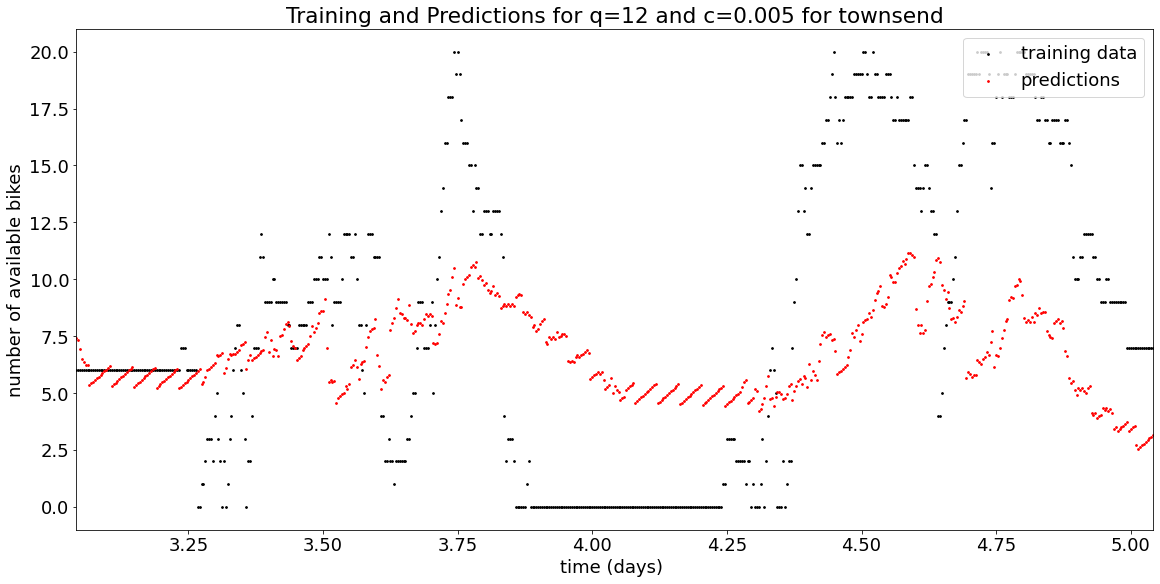

0.0 [ 0.22396595  0.15144897  0.1531318  -3.55592097  0.87717815  0.71421003
 -0.03540322  0.0152056   0.03635779]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.14388473071983598
rmse: 5.302722031880681


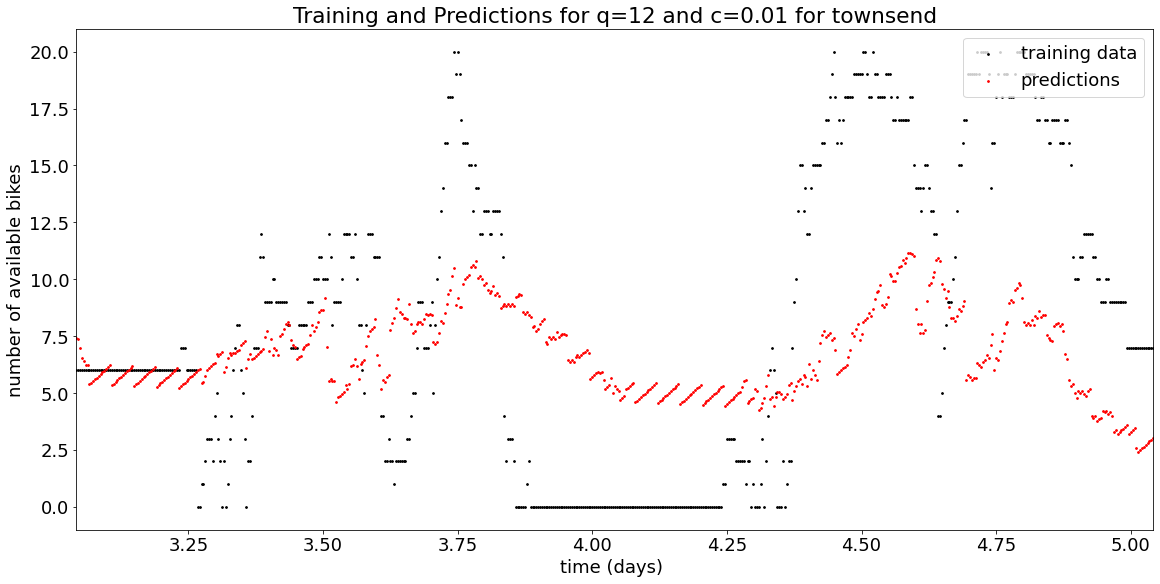

0.0 [ 0.22478026  0.15189736  0.15184727 -3.69270678  0.88825096  0.71640318
 -0.03525036  0.01519578  0.03532046]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.14394772337805617
rmse: 5.303513613595385


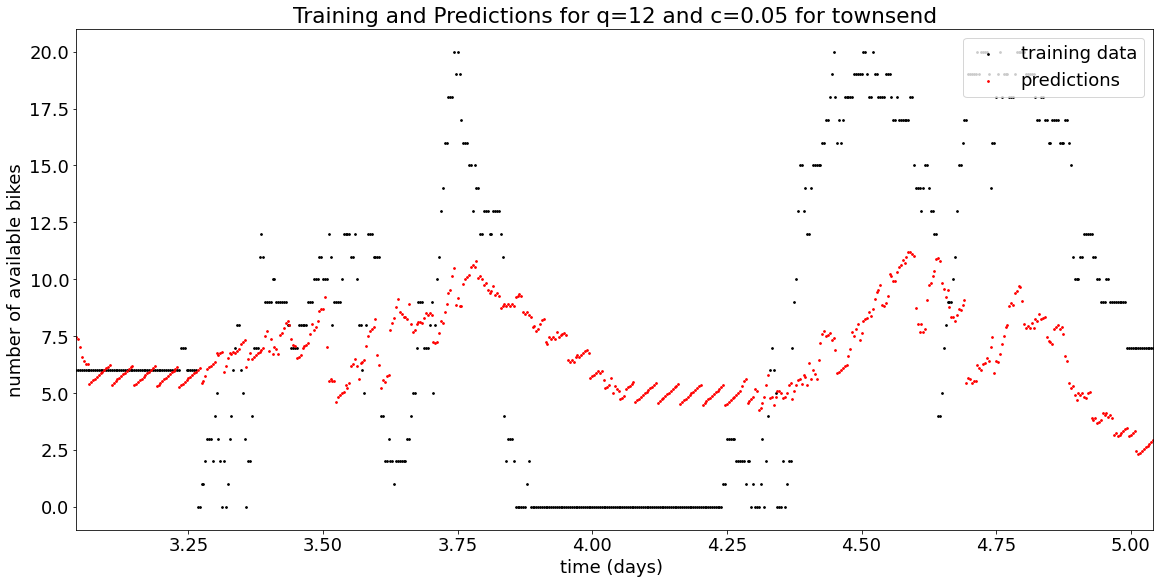

0.0 [ 0.22488704  0.15195639  0.15168024 -3.71054045  0.88967879  0.71668901
 -0.0352296   0.01519473  0.03518509]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.14394984385967713
rmse: 5.303635252667458


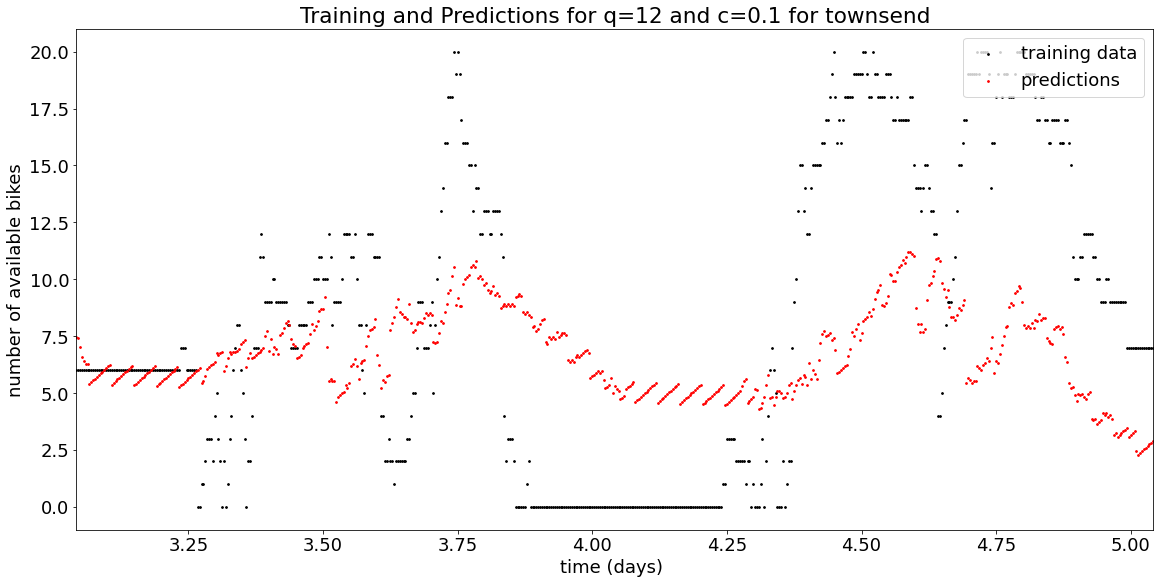

0.0 [ 0.2249733   0.15200412  0.15154553 -3.72493058  0.89082837  0.71691964
 -0.03521271  0.01519391  0.03507583]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.14395053084873577
rmse: 5.303736499986948


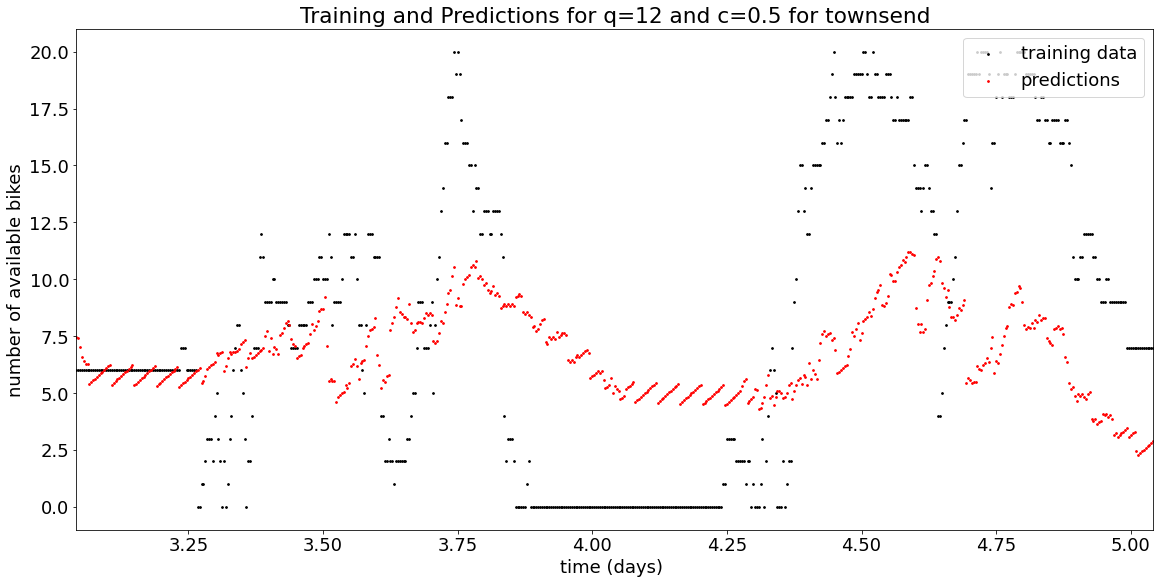

0.0 [ 0.22498414  0.15201011  0.15152862 -3.72673712  0.89097253  0.71694859
 -0.03521059  0.01519381  0.03506212]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.14395055248146627
rmse: 5.303749405859202


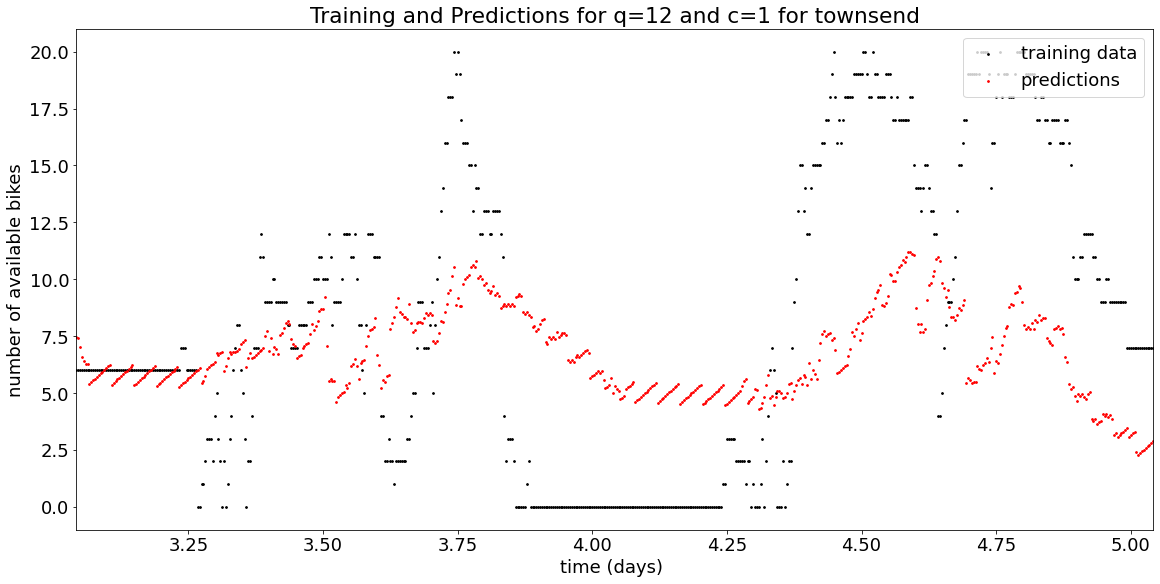

0.0 [ 0.22499282  0.15201492  0.15151508 -3.7281836   0.89108793  0.71697177
 -0.03520888  0.01519372  0.03505113]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.1439505594125423
rmse: 5.3037597708808635


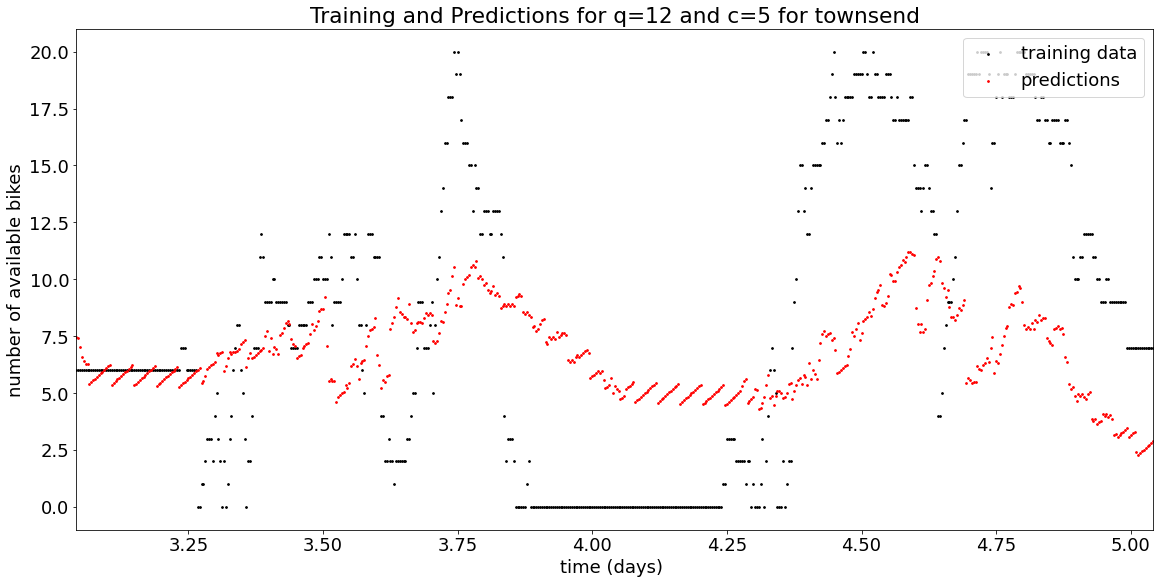

0.0 [ 0.2249939   0.15201552  0.15151339 -3.72836449  0.89110236  0.71697467
 -0.03520867  0.01519371  0.03504976]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.14395055962930414
rmse: 5.303761069032847


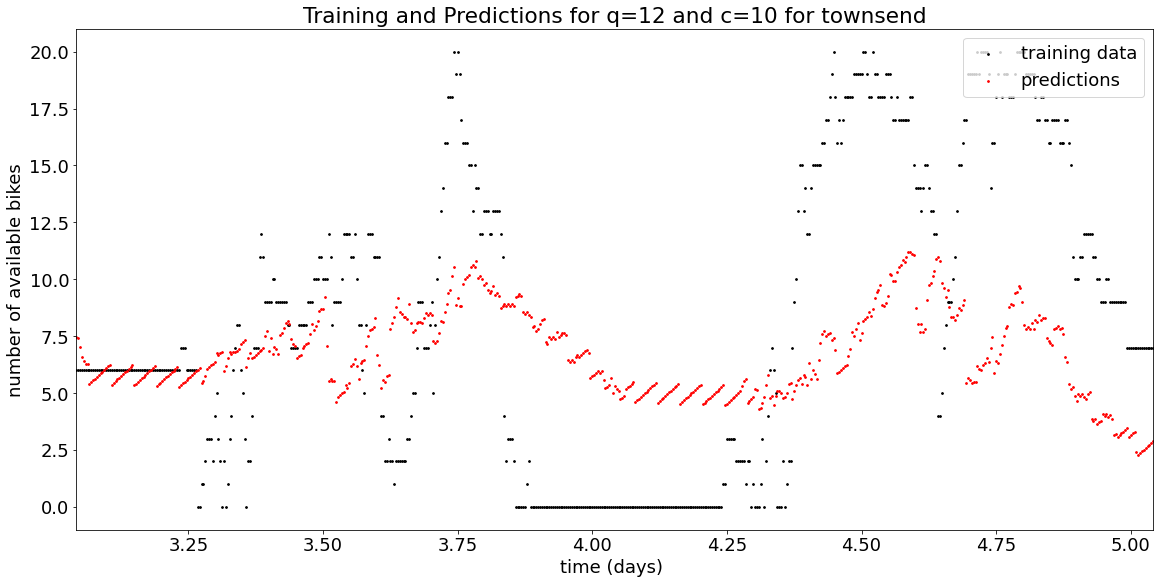

0.0 [ 0.22499477  0.152016    0.15151204 -3.72850921  0.8911139   0.71697699
 -0.0352085   0.01519371  0.03504866]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.14395055969867643
rmse: 5.30376210795865


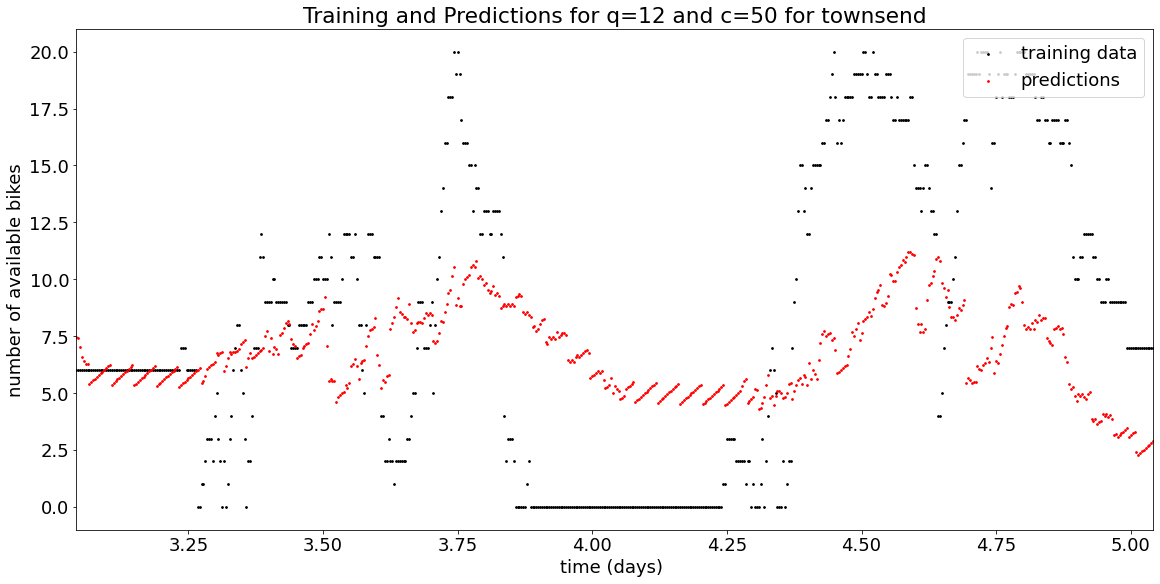

0.0 [ 0.22499488  0.15201606  0.15151187 -3.7285273   0.89111535  0.71697728
 -0.03520847  0.01519371  0.03504852]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.14395055970084447
rmse: 5.303762237849643


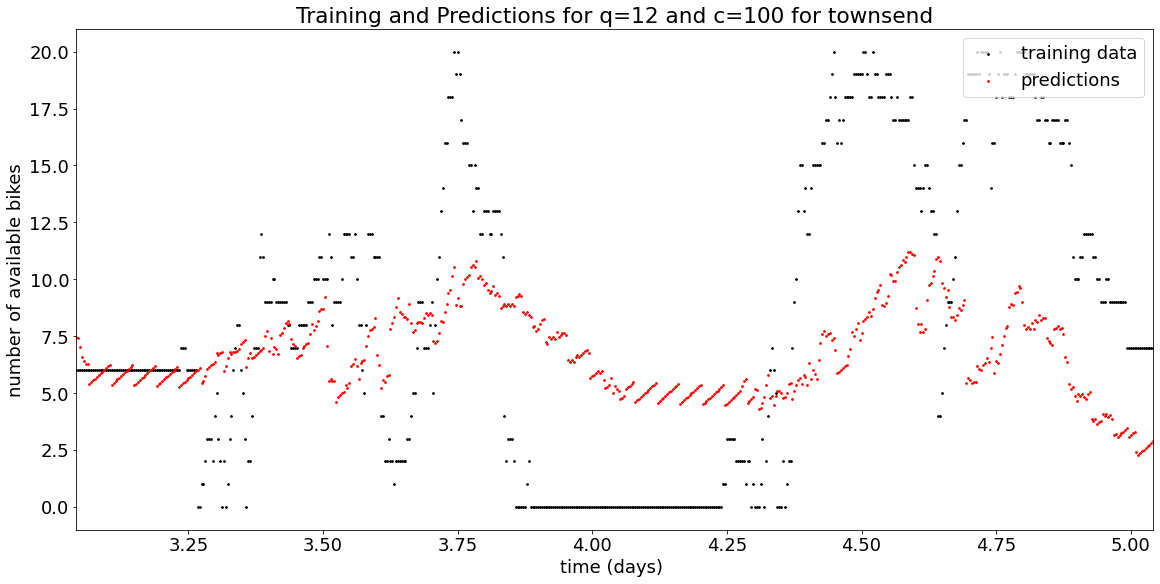

0.0 [ 0.22499498  0.15201611  0.15151172 -3.72854358  0.89111664  0.71697754
 -0.03520846  0.0151937   0.0350484 ]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.1439505597015599
rmse: 5.303762354756339


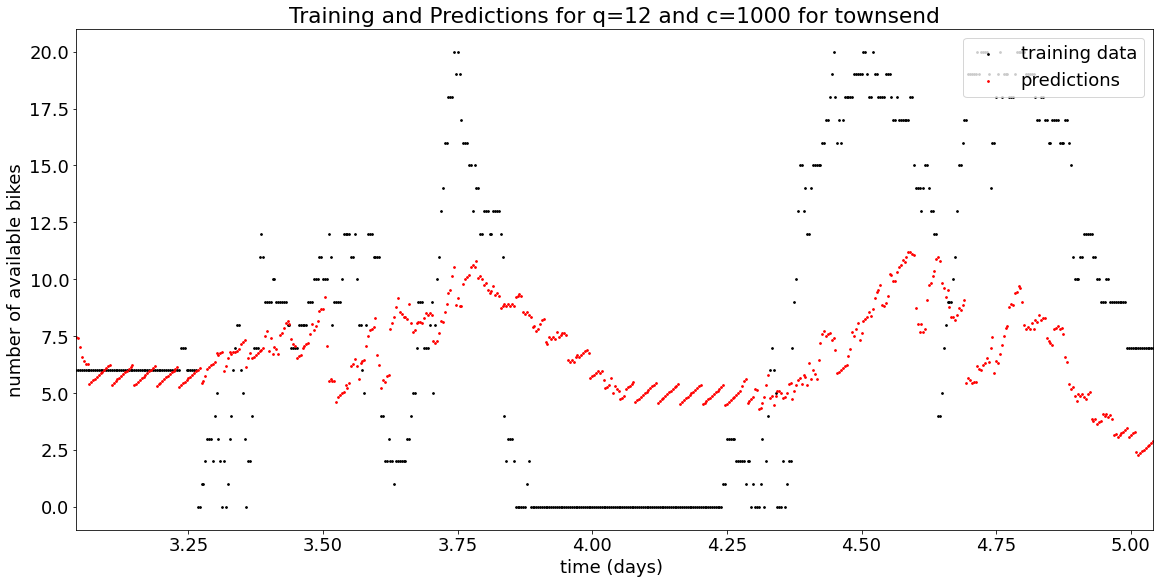

minimum c:0.005
5.30212133156601
q=6,samples=w,lag=3
XX:
11360
y:
17414
0.0 [0.14663398 0.18348093 0.24403518 0.03186193 0.16211896 0.09822928
 0.12334225 0.04997497 0.00866456]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: -0.013297754662749517
rmse: 5.220894837976189


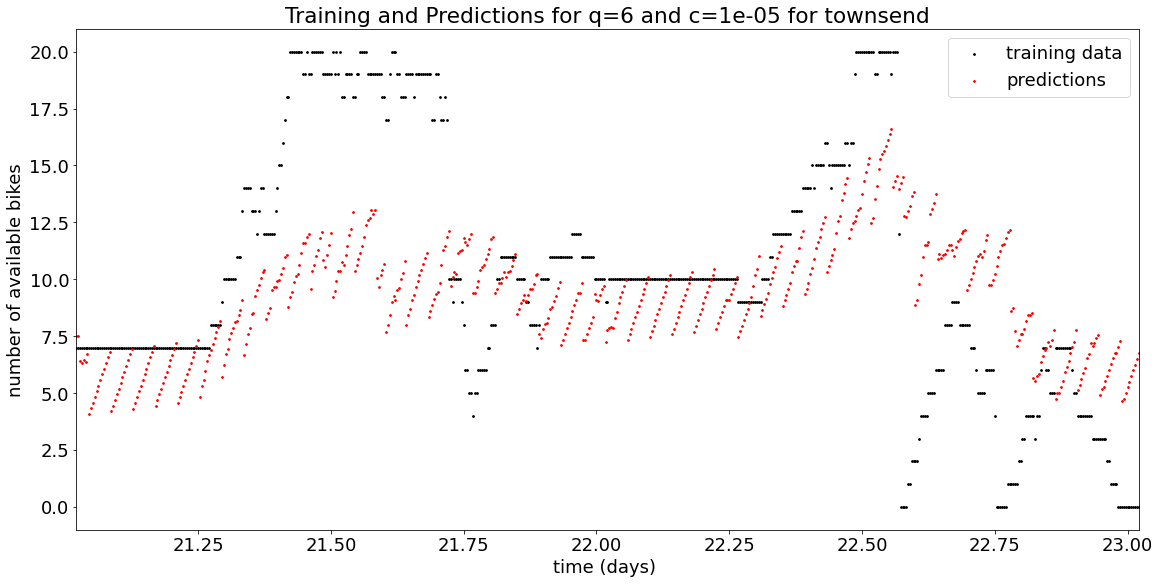

0.0 [0.12949957 0.17593185 0.23682534 0.25434237 0.87645046 0.08284824
 0.0963376  0.0373037  0.00251919]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.01904140124210829
rmse: 5.139085213193264


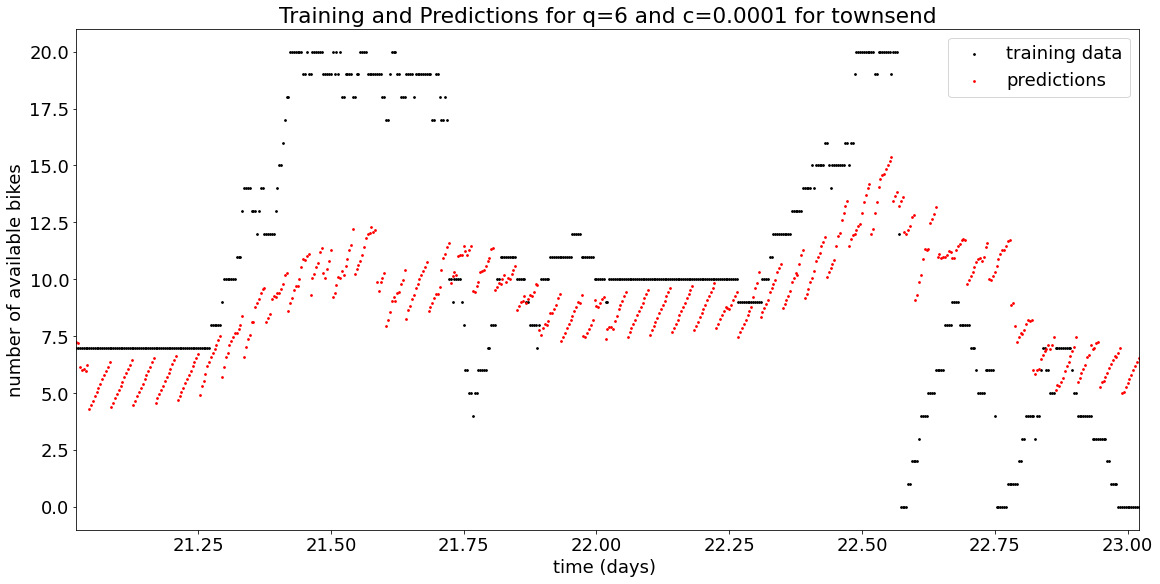

0.0 [ 0.10541255  0.16275177  0.21863764  0.83705258  1.6577829  -0.01424522
  0.06624229  0.02891211  0.00854192]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.04011860547201529
rmse: 5.08642621997253


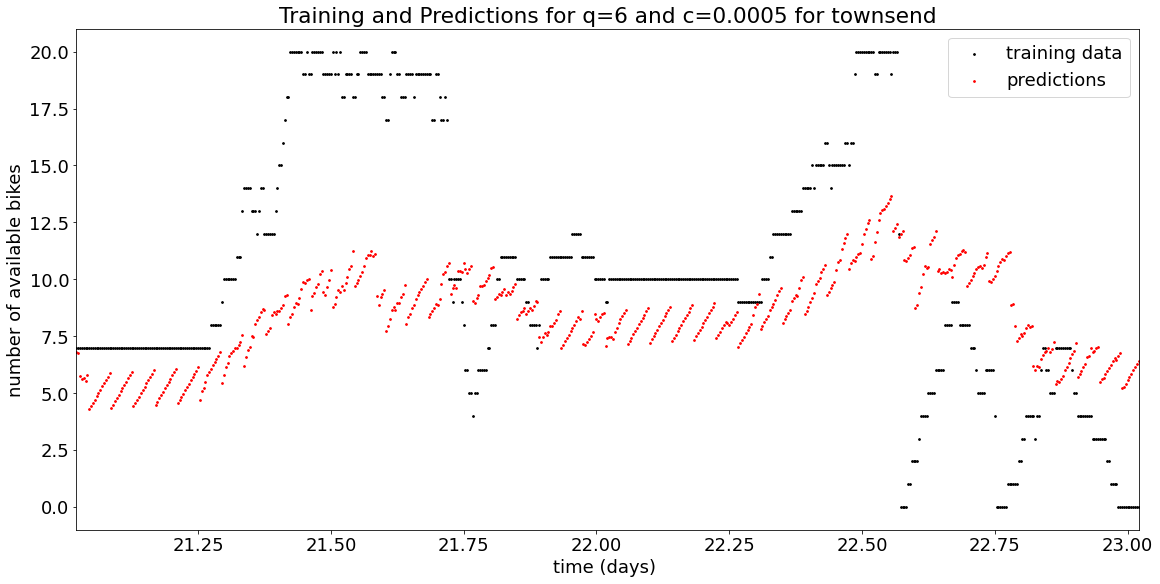

0.0 [ 0.09721388  0.15904461  0.21437817  1.1896311   1.86904069 -0.04659607
  0.05723752  0.02657129  0.01180204]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.04390956815152447
rmse: 5.077592226057442


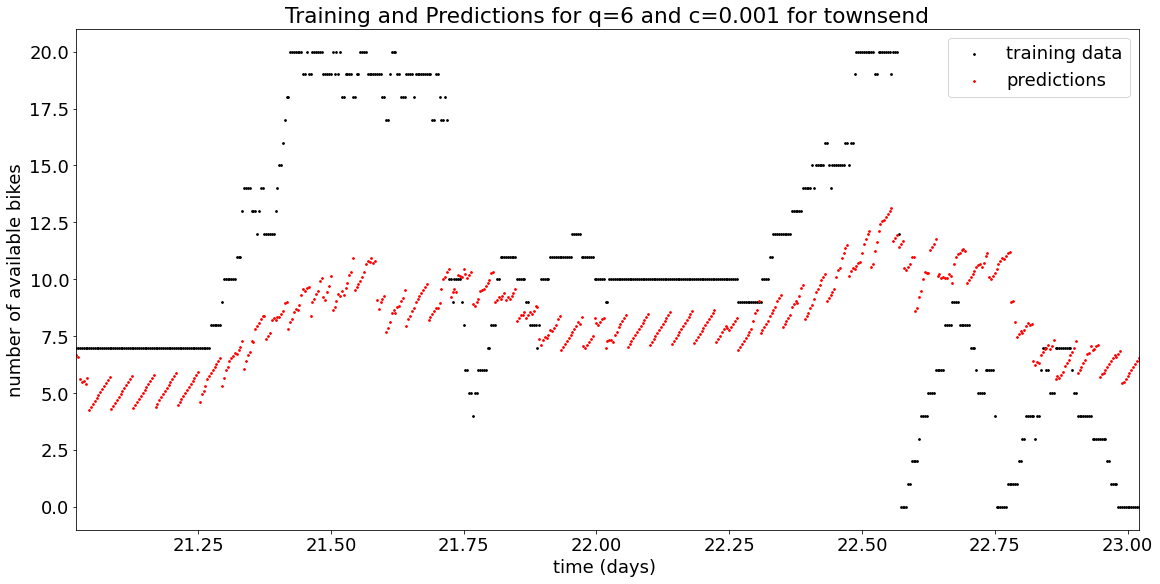

0.0 [ 0.08682388  0.15522012  0.21115921  1.80623421  2.07854781 -0.08461662
  0.04700724  0.02402915  0.01707341]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.046499991941275076
rmse: 5.071567052701707


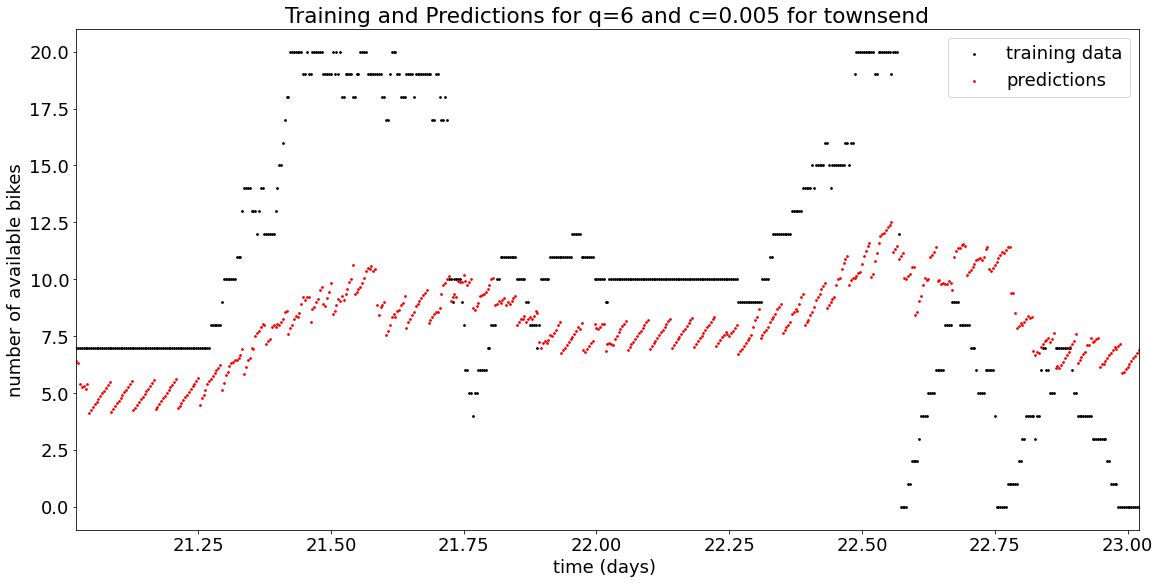

0.0 [ 0.08504013  0.1546683   0.21086803  1.93243564  2.10756834 -0.09075489
  0.04538971  0.02364158  0.01811238]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.04665933937893141
rmse: 5.071158812134383


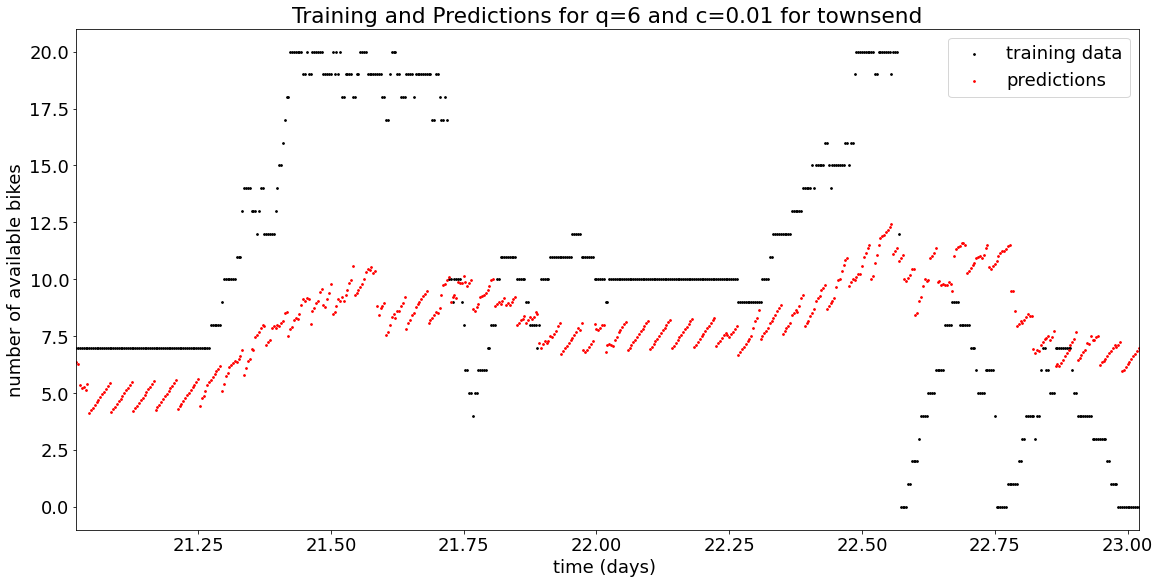

0.0 [ 0.08348708  0.1542123   0.21067555  2.04706332  2.13121657 -0.09600555
  0.04401353  0.02331537  0.01904802]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.04671869834256337
rmse: 5.070975741433883


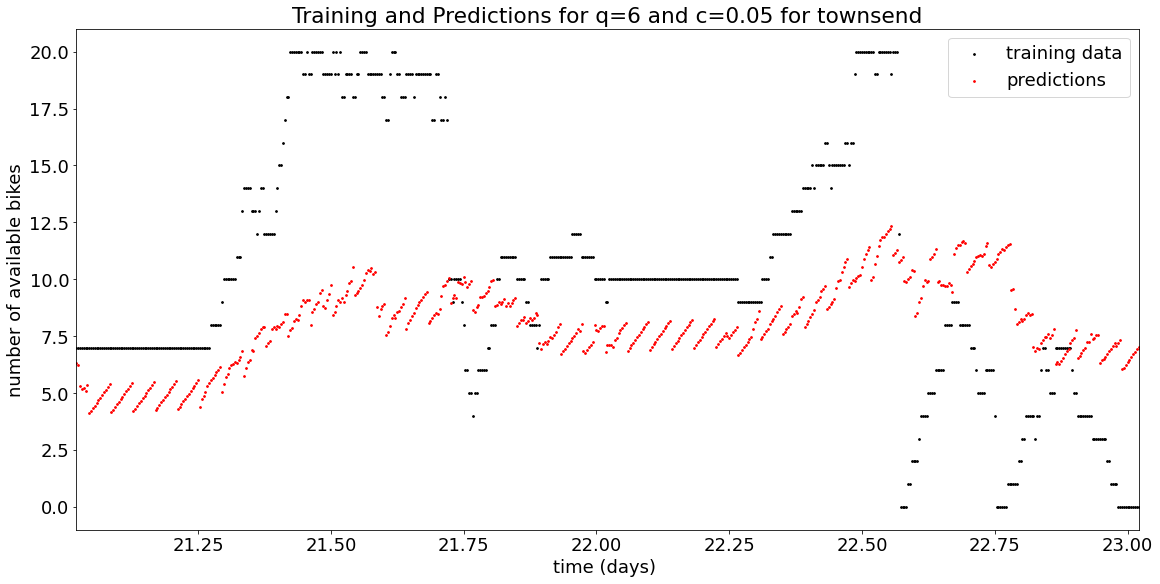

0.0 [ 0.08328406  0.15415435  0.21065452  2.06236925  2.13419847 -0.09668556
  0.04383581  0.02327348  0.01917243]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.04672074676533999
rmse: 5.070964233185935


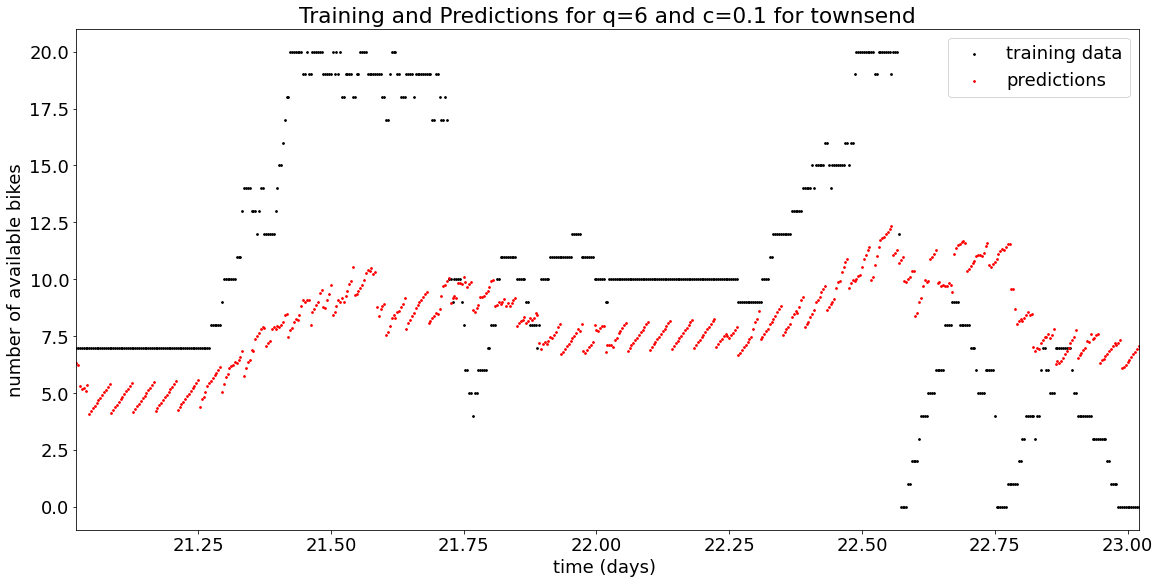

0.0 [ 0.08312012  0.15410782  0.21063823  2.0747821   2.13658801 -0.09723359
  0.04369266  0.02323979  0.01927323]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.04672141336612312
rmse: 5.070957091507134


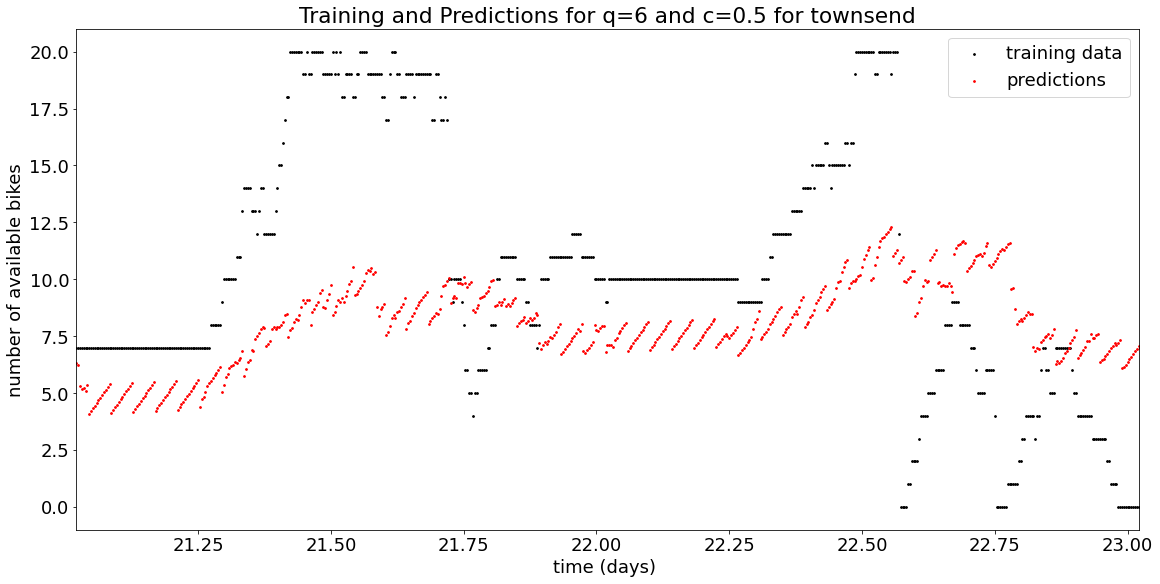

0.0 [ 0.08309953  0.154102    0.21063622  2.07634437  2.13688695 -0.09730235
  0.0436747   0.02323556  0.01928592]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.04672143441525389
rmse: 5.070956331160813


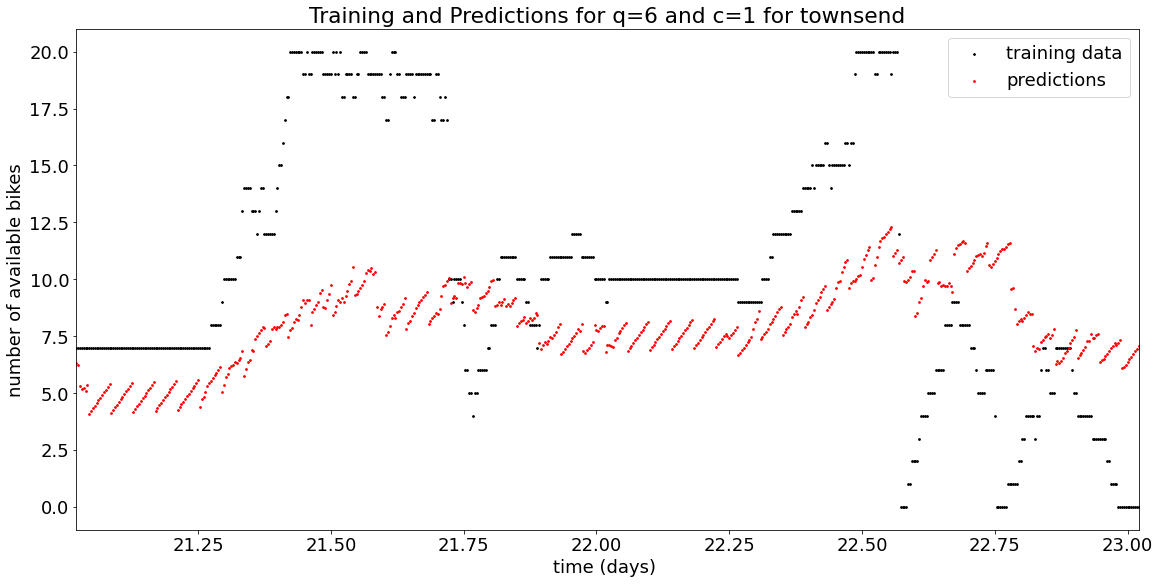

0.0 [ 0.08308305  0.15409734  0.21063463  2.0775959   2.13712614 -0.09735739
  0.04366033  0.02323218  0.01929607]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.04672144116242172
rmse: 5.070955744340941


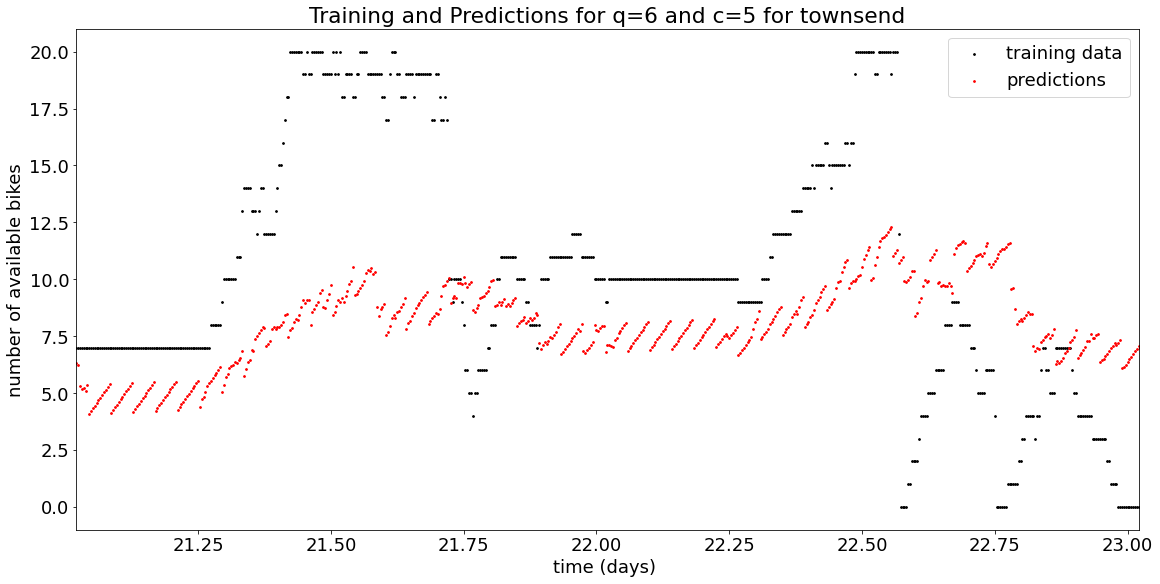

0.0 [ 0.08308098  0.15409676  0.21063443  2.07775245  2.13715605 -0.09736428
  0.04365853  0.02323176  0.01929734]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.046721441373491324
rmse: 5.070955672332951


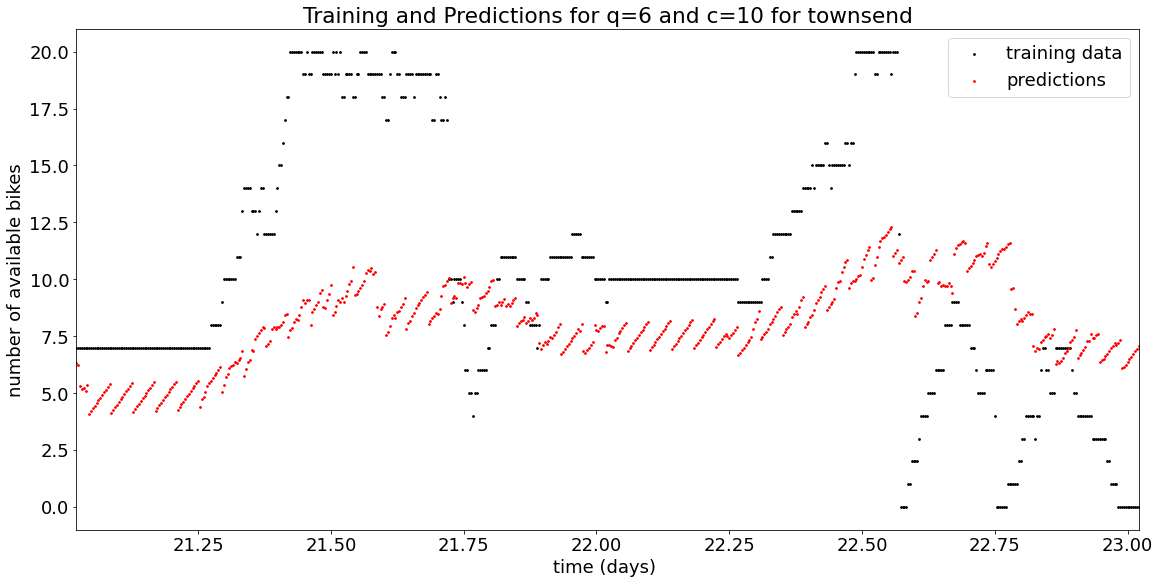

0.0 [ 0.08307933  0.15409629  0.21063427  2.0778777   2.13717997 -0.09736978
  0.04365709  0.02323142  0.01929836]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.04672144144104495
rmse: 5.07095561494196


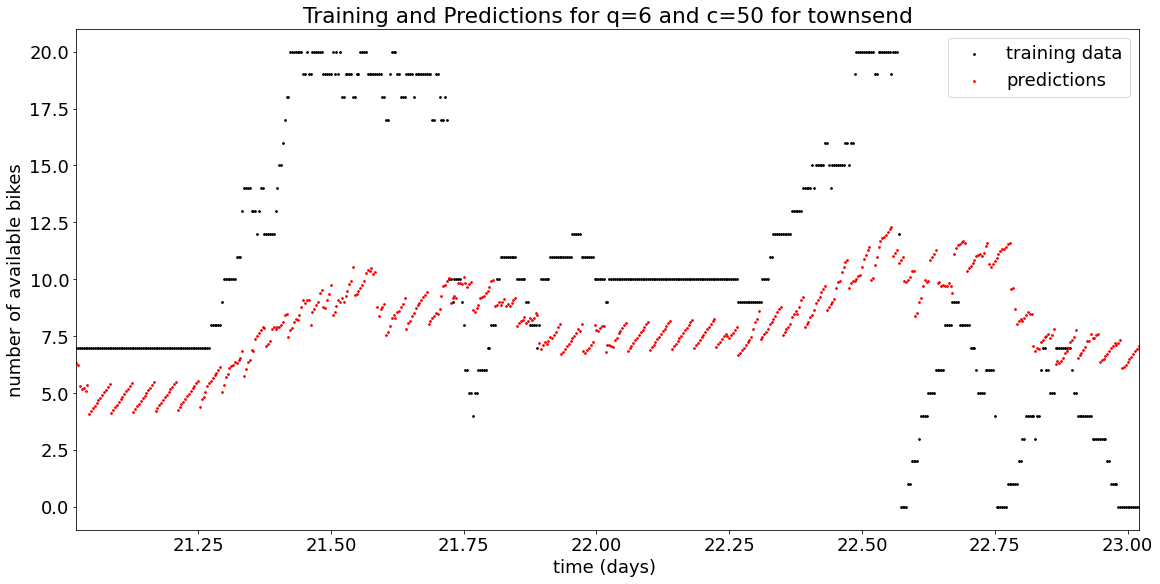

0.0 [ 0.08307913  0.15409623  0.21063425  2.07789336  2.13718296 -0.09737047
  0.04365691  0.02323138  0.01929849]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.046721441443156264
rmse: 5.070955607781553


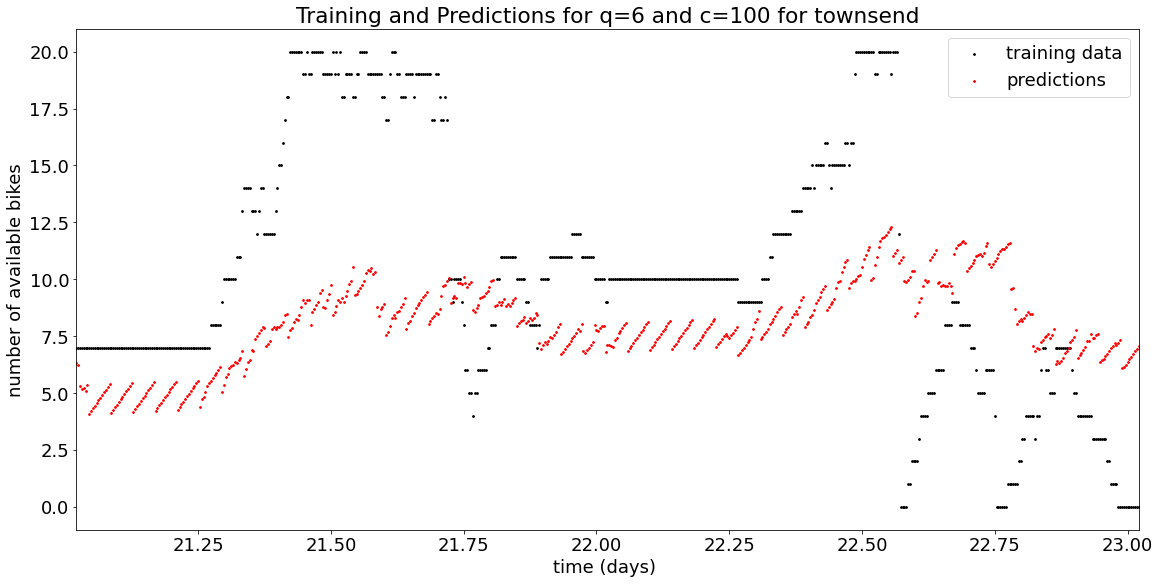

0.0 [ 0.08307894  0.15409618  0.21063423  2.07790745  2.13718565 -0.09737109
  0.04365675  0.02323134  0.0192986 ]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.04672144144385282
rmse: 5.070955601339745


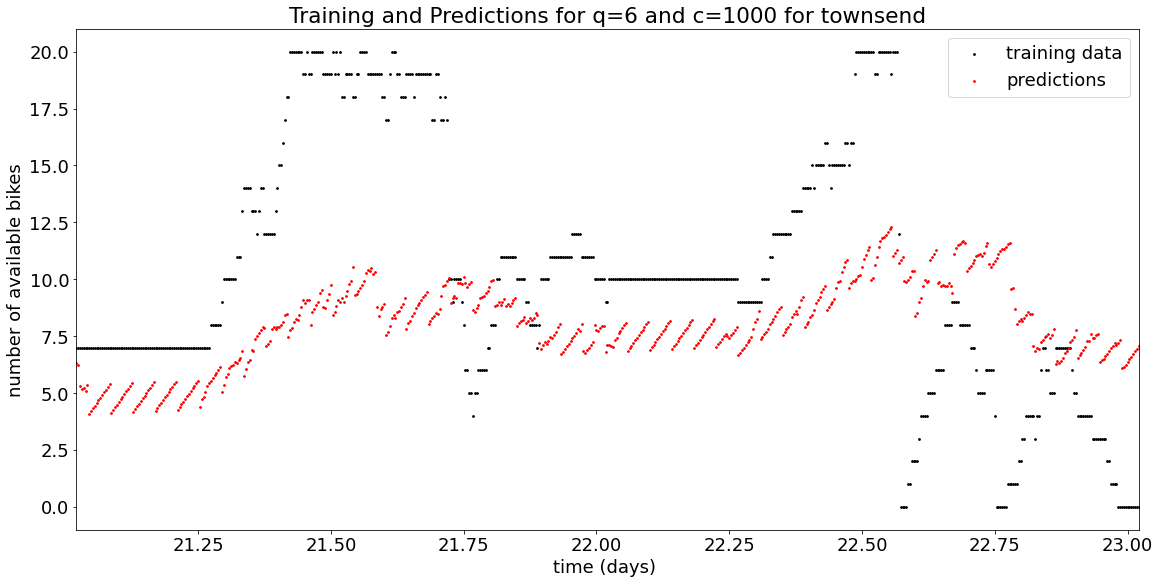

minimum c:1000
5.070955601339745
q=12,samples=w,lag=3
XX:
11354
y:
17414
0.0 [0.13947179 0.18470737 0.23593267 0.03085217 0.16977322 0.10503686
 0.12195627 0.05126802 0.01257498]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: -0.03489931107482591
rmse: 5.280693674586256


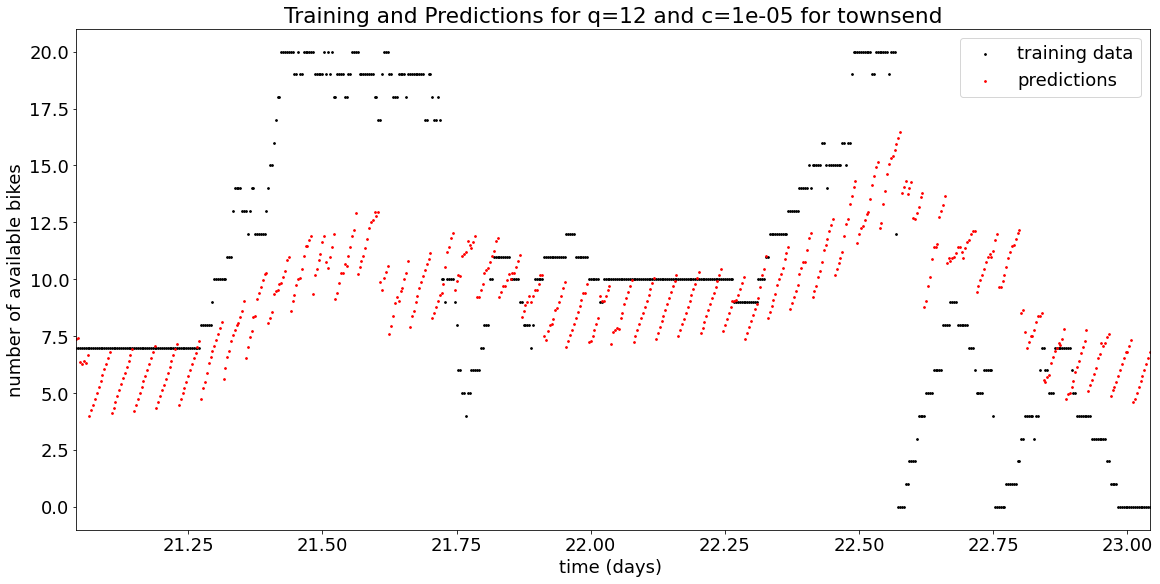

0.0 [0.120687   0.17731033 0.22602147 0.24436574 0.92374981 0.09277348
 0.09301988 0.0381479  0.00664357]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.0006113598691017685
rmse: 5.191838561674969


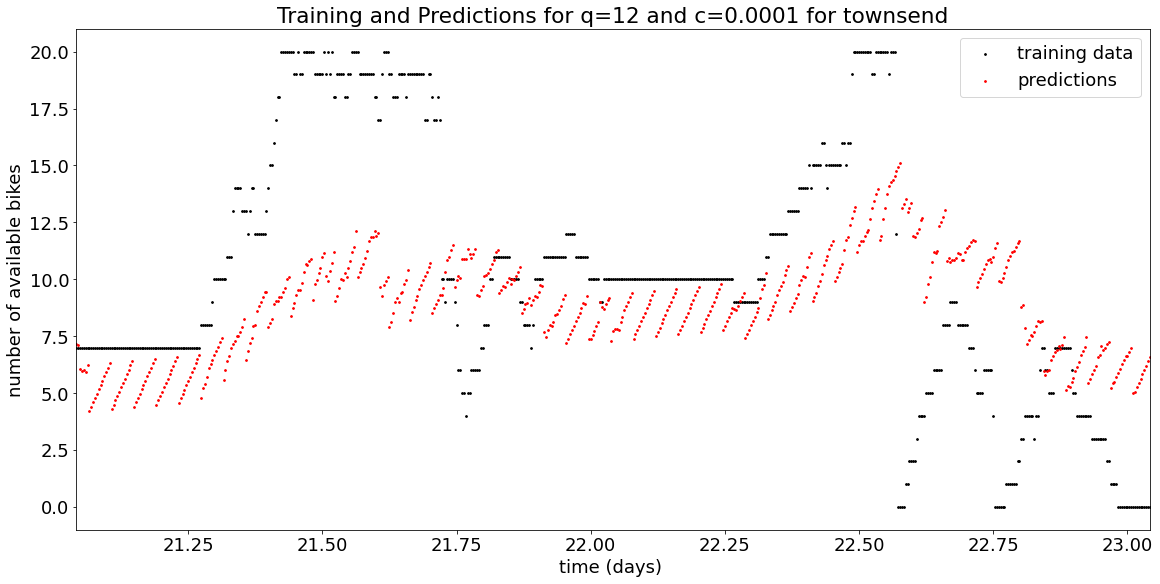

0.0 [ 0.09566095  0.16348871  0.20633987  0.80122281  1.74881996 -0.00785768
  0.06145848  0.02934867  0.01262444]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.023223047619038484
rmse: 5.135610952838846


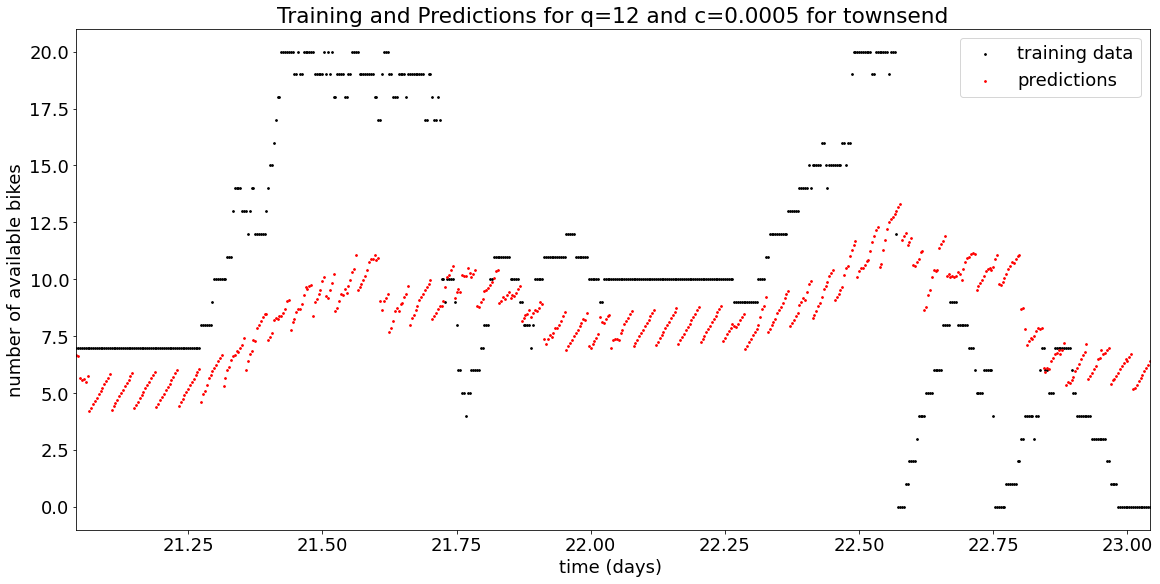

0.0 [ 0.08728401  0.15959414  0.20166503  1.13770873  1.97228165 -0.04123333
  0.05210735  0.02690545  0.01580534]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.027084718065348956
rmse: 5.126742607526745


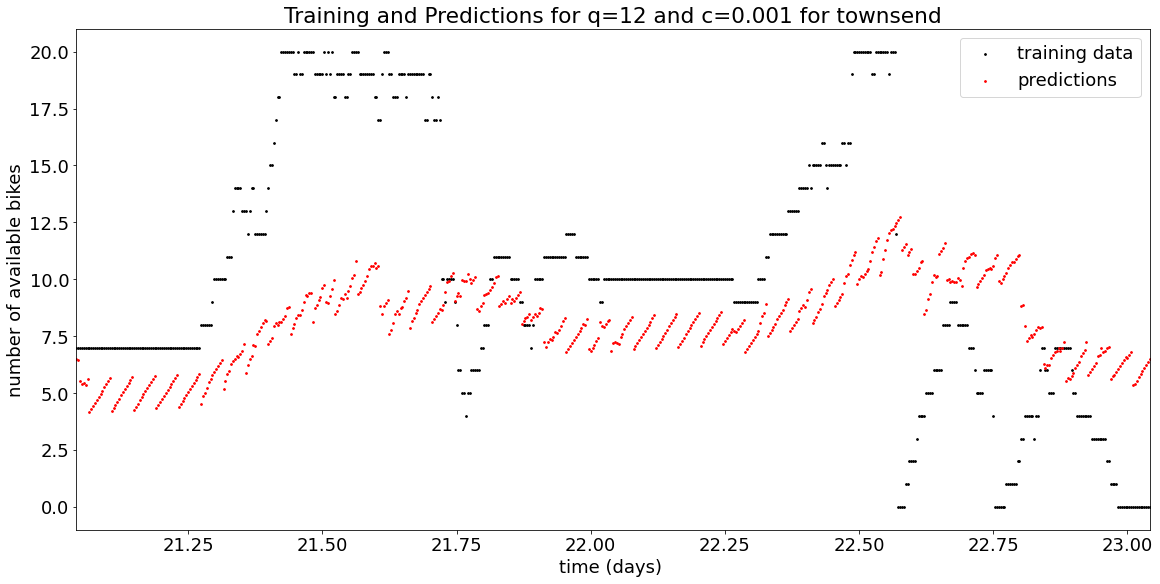

0.0 [ 0.07680882  0.15557882  0.19798034  1.72591531  2.19441662 -0.08012271
  0.04158254  0.02426839  0.02090555]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.029626245551002572
rmse: 5.121063697608891


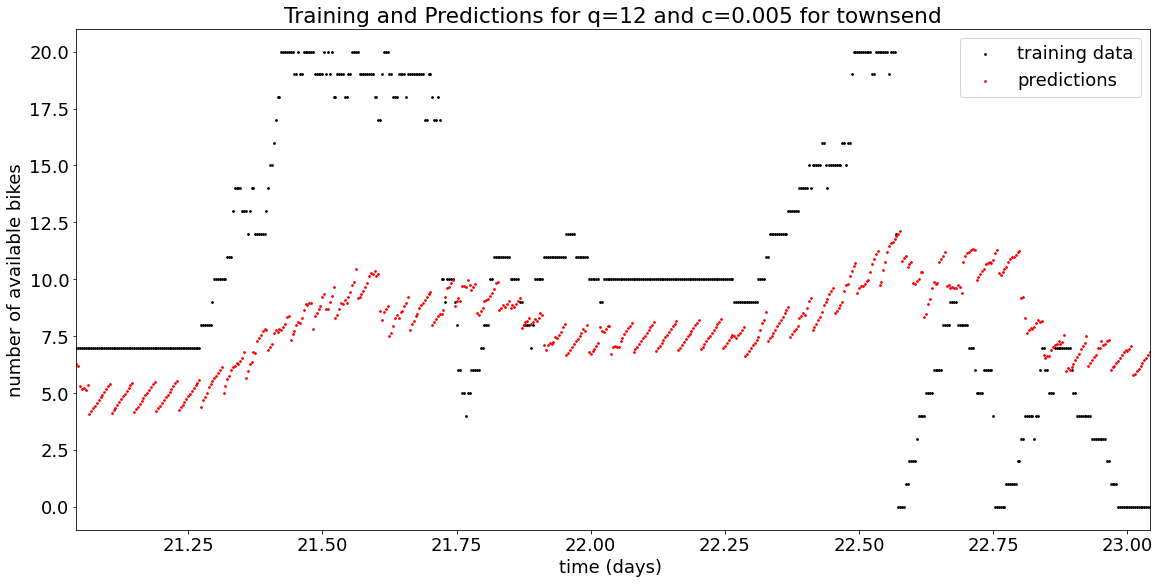

0.0 [ 0.0750271   0.15499999  0.1976159   1.84628453  2.22526659 -0.08635525
  0.0399314   0.02386863  0.02190667]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.029778414154215227
rmse: 5.12071443042876


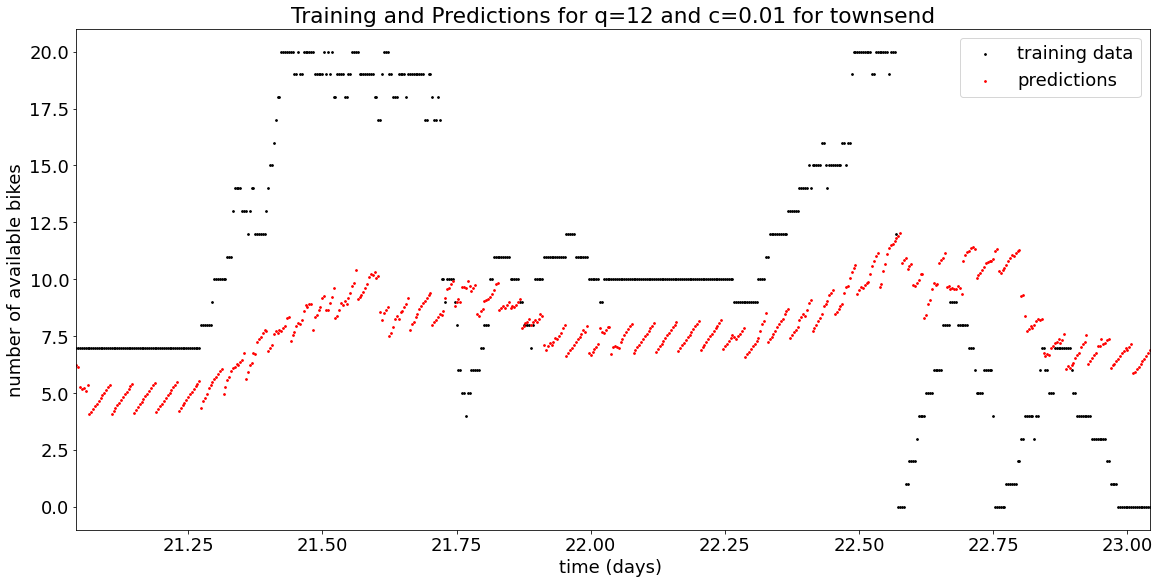

0.0 [ 0.07347969  0.15452183  0.19736114  1.95561129  2.25042877 -0.09167487
  0.03852989  0.02353275  0.02280739]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.029834808670993085
rmse: 5.120574579104103


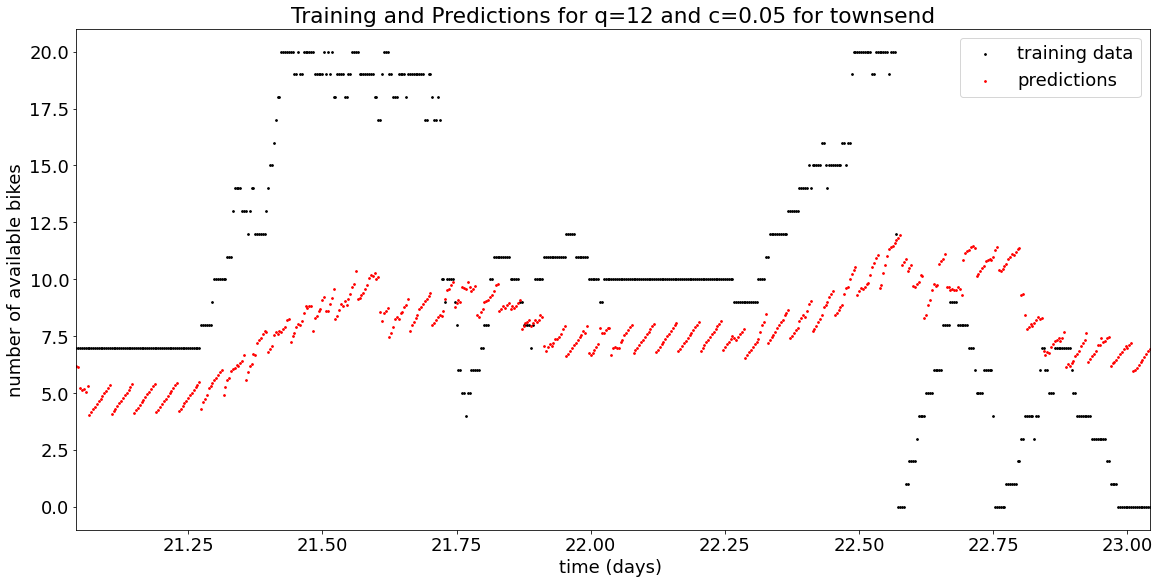

0.0 [ 0.07327766  0.15446107  0.19733207  1.97020917  2.25360325 -0.092363
  0.03834911  0.02348966  0.0229271 ]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.02983674874142872
rmse: 5.120568018659425


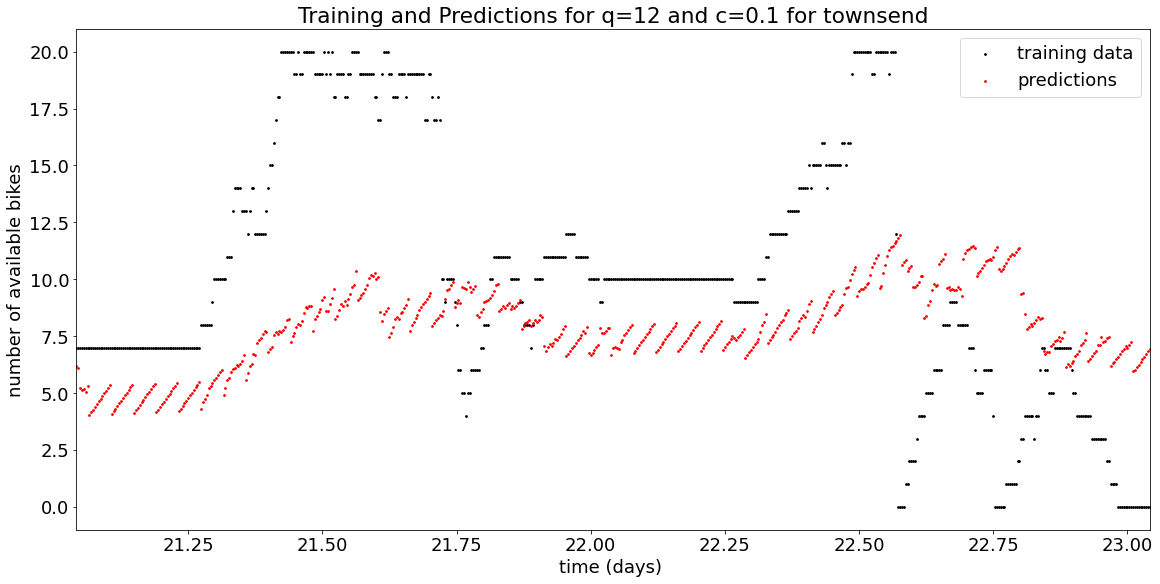

0.0 [ 0.07311458  0.1544123   0.19730931  1.98204777  2.2561474  -0.09291744
  0.03820355  0.023455    0.02302409]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.029837379759411364
rmse: 5.120564740829347


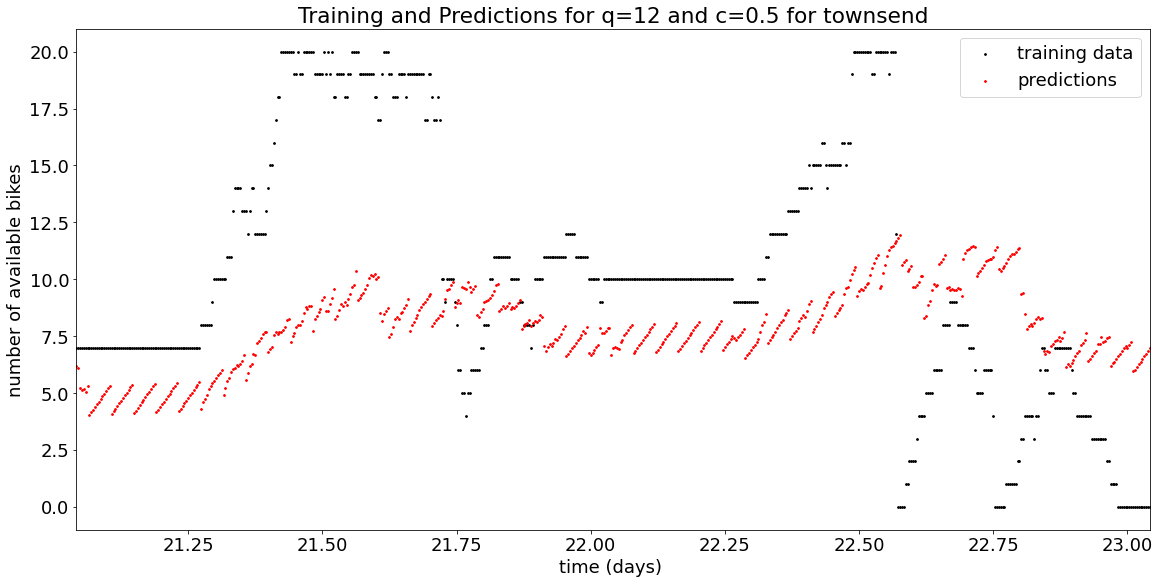

0.0 [ 0.0730941   0.1544062   0.19730649  1.98353776  2.2564657  -0.09298699
  0.03818529  0.02345066  0.02303629]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.02983739967869703
rmse: 5.120564457268569


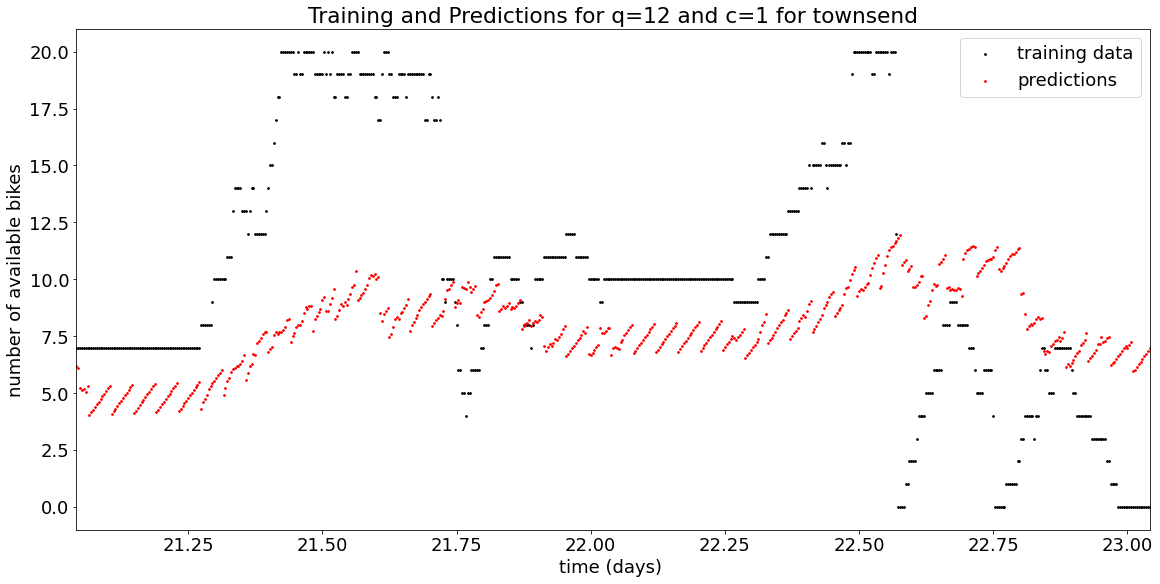

0.0 [ 0.0730777   0.15440131  0.19730424  1.98473139  2.25672039 -0.09304268
  0.03817068  0.02344718  0.02304606]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.02983740606337415
rmse: 5.120564250860812


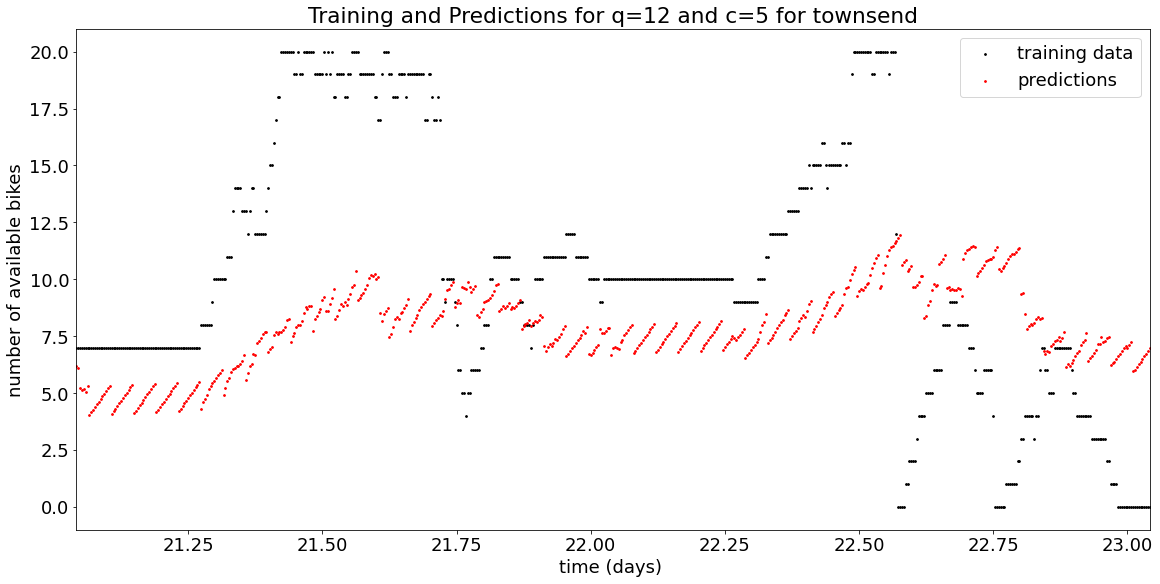

0.0 [ 0.07307565  0.1544007   0.19730396  1.9848807   2.25675223 -0.09304964
  0.03816885  0.02344675  0.02304728]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.029837406263097388
rmse: 5.120564226340509


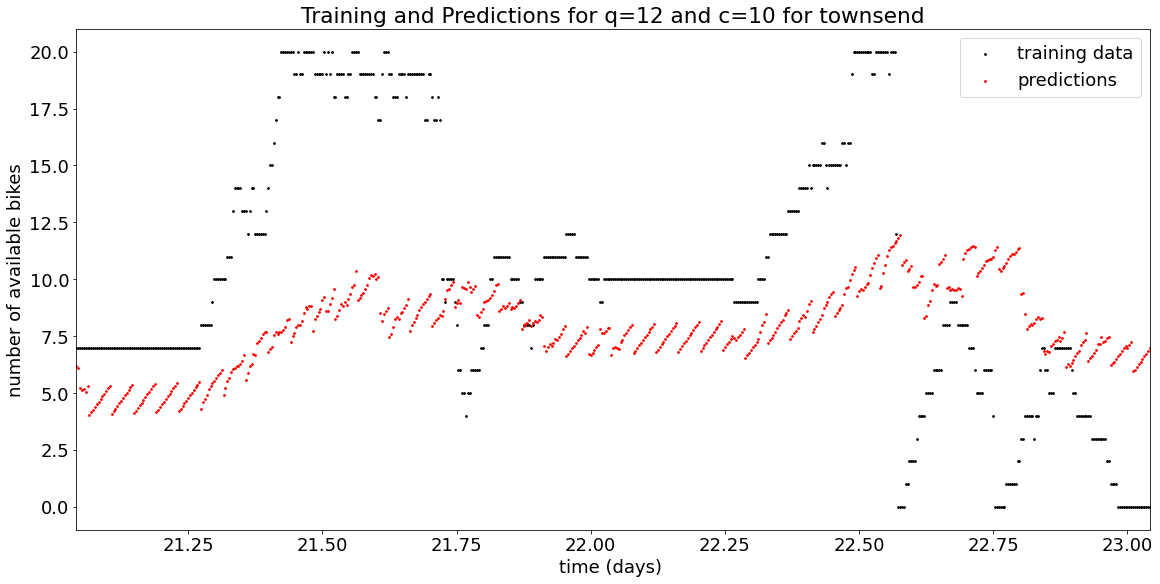

0.0 [ 0.07307401  0.15440021  0.19730374  1.98500016  2.2567777  -0.09305521
  0.03816739  0.0234464   0.02304826]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.029837406327019367
rmse: 5.120564206929431


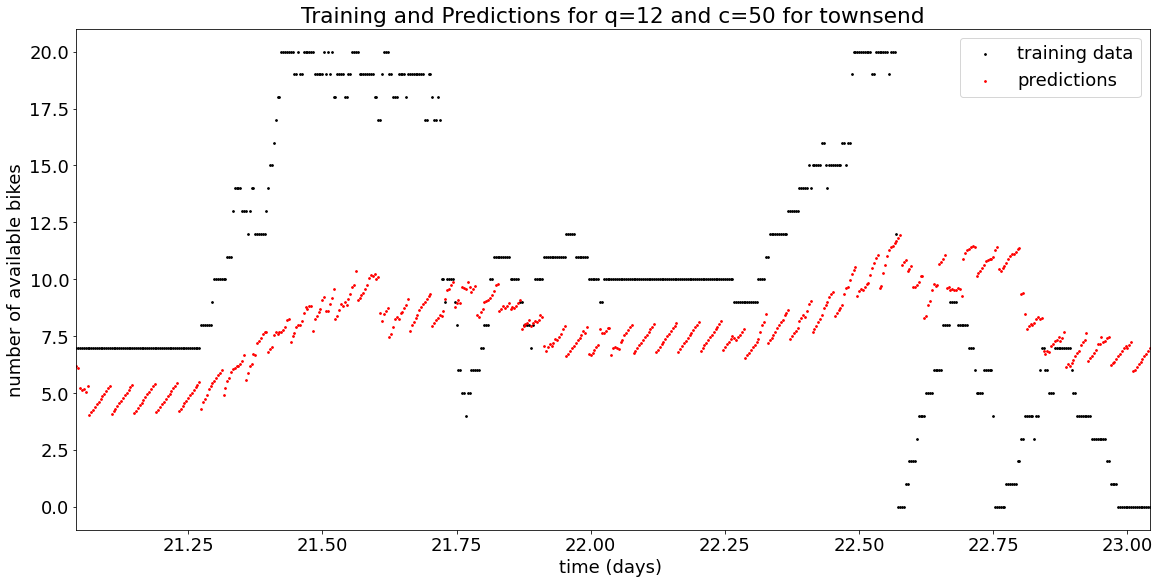

0.0 [ 0.0730738   0.15440015  0.19730371  1.98501509  2.25678088 -0.09305591
  0.03816721  0.02344636  0.02304838]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.029837406329017324
rmse: 5.120564204515872


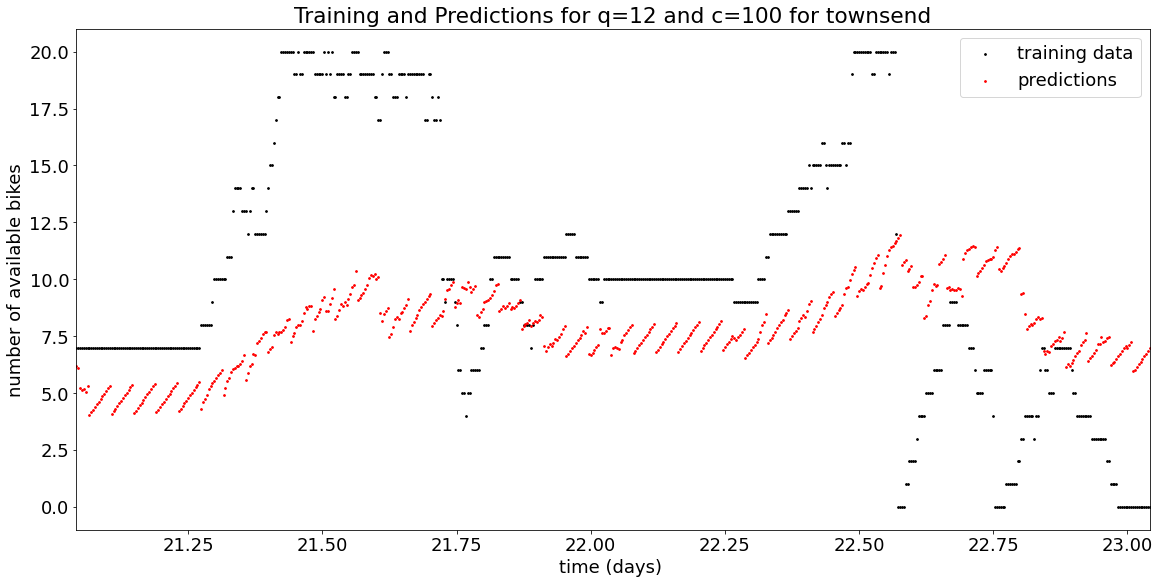

0.0 [ 0.07307362  0.15440009  0.19730369  1.98502853  2.25678375 -0.09305653
  0.03816704  0.02344632  0.02304849]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.029837406329676464
rmse: 5.120564202346106


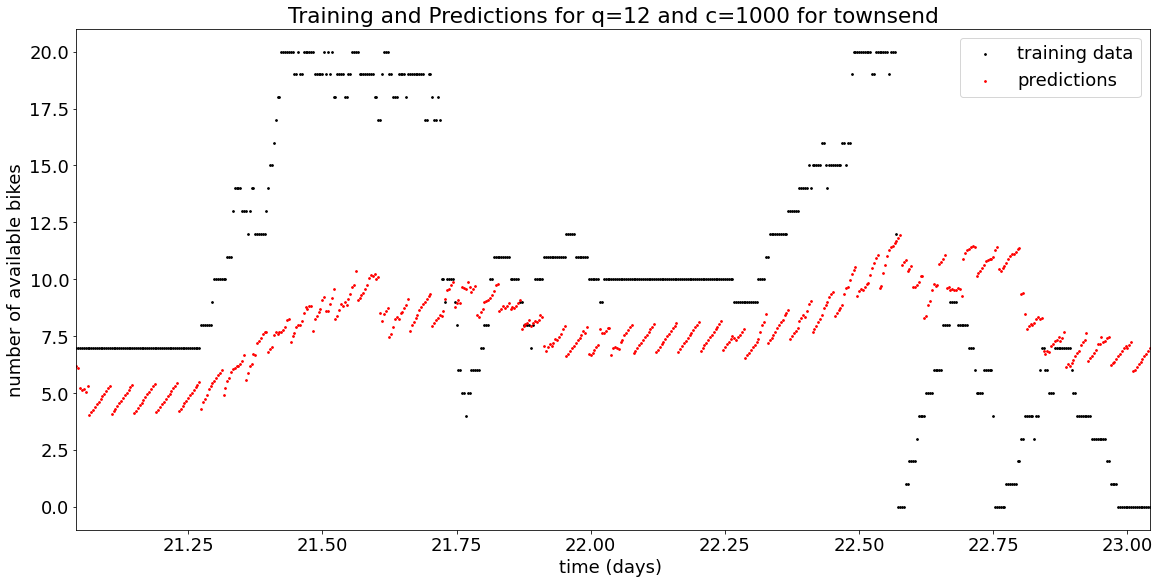

minimum c:1000
5.120564202346106
together 1
score: -0.0335206598298623
0.0 [ 0.06207437  0.05979345  0.08283105  0.06207435  0.13506004 -0.09046917
  0.17568936  0.03451463 -0.01302949  0.19201031  2.07948916  0.29674292]
rmse: 5.042767184805553


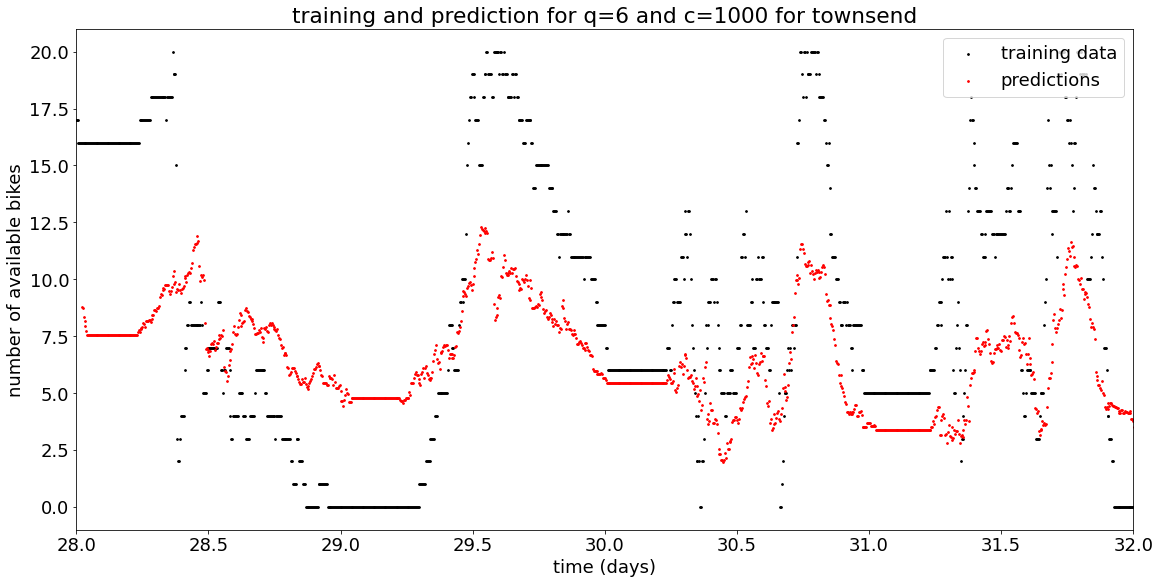

together 2
score: -0.017518556671641594
0.0 [ 0.05887344  0.05647363  0.07922568  0.05887351  0.1320087  -0.08680607
  0.22756605 -0.02885803  0.01676244  0.20888345  2.00220977  0.31753583]
rmse: 5.005831231151091


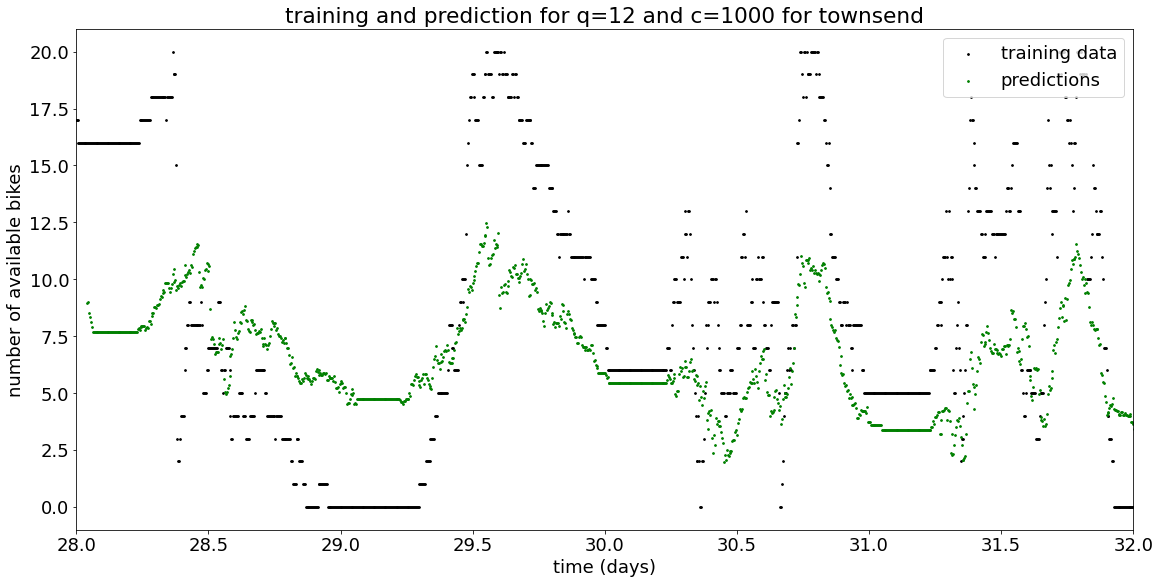

In [62]:
plt.rc('font', size=18); plt.rcParams['figure.constrained_layout.use'] = True
# read data. column 1 is date/time, col 6 is #bikes
newdf = pd.read_csv("df_townsend.csv", usecols = ['TIME','AVAILABLE BIKES',
                                                  'WEEKEND',"MONTH", 
                                                  "DAY_OF_WEEK", "HOUR", 
                                                  "MINUTE", "DAY", 
                                                  "BIKE STANDS", 
                                                  "AVAILABLE BIKE STANDS"], 
                          parse_dates=['TIME'])

print(newdf.columns)
start=pd.to_datetime('2020-02-01 00:05:02',format='%Y-%m-%d %H:%M:%S')
end=pd.to_datetime('2020-04-01 23:55:02',format='%Y-%m-%d %H:%M:%S')

# convert date/time to unix timestamp in sec
t_full=pd.array(pd.DatetimeIndex(newdf.iloc[:,0]).astype(np.int64))/1000000000
dt = t_full[1] - t_full[0]
# print(t_full)
print("data sampling interval is %d secs"%dt)

# extract data between start and end dates
t_start = pd.DatetimeIndex([start]).astype(np.int64)/1000000000
t_end = pd.DatetimeIndex([end]).astype(np.int64)/1000000000
t = np.extract( [(t_full >= t_start[0]) & (t_full <= t_end[0])] , t_full)
# convert timestamp to days
t=(t-t[0])/(60*60*24)
# print(t)
y = np.extract([(t_full >= t_start[0]) & (t_full <= t_end[0])], newdf.iloc[:,9]).astype(np.int64)
# plt.scatter(t,y)
# plt.show()

# plot extracted data
# plt.scatter(t,y, color='red', marker='.'); plt.show()

def test_preds(q,samples,lag,plot):
  #q−step ahead prediction
  stride=1
  XX=y[0:y.size-q-lag*samples:stride]
  
  weekendvals=newdf['WEEKEND'][0:y.size-q-lag*samples:stride]
  monthvals = newdf['MONTH'][0:y.size-q-lag*samples:stride]
  dayofweekvals = newdf['DAY_OF_WEEK'][0:y.size-q-lag*samples:stride]
  hourvals=newdf['HOUR'][0:y.size-q-lag*samples:stride]
  minutevals=newdf['MINUTE'][0:y.size-q-lag*samples:stride]
  dayvals=newdf['DAY'][0:y.size-q-lag*samples:stride]

  print("XX:");   print(XX.size);
  print("y:");   print(y.size);
  for i in range(1,lag):
    # add lag including number of samples perday, since we have a time stamp each day, if we want to get 5 mins earlier we might need yesterdays same time -5??

    X = y[i*samples:y.size-q-(lag-i) * samples : stride]
    XX=np.column_stack((XX,X))

  XX=np.column_stack((XX,weekendvals,monthvals,dayofweekvals,hourvals,
                      minutevals,dayvals))

  yy=y[lag*samples+q::stride]; tt=t[lag*samples+q::stride]
  train, test = train_test_split(np.arange(0,yy.size),test_size=0.2, shuffle=False)

  minC=100; minRMSE = 100
  cValues = [0.00001, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 1000] ## 0.0005 or 0.0001
  for c in cValues:
    model = Ridge(alpha=1/(2*c), fit_intercept=False).fit(XX[train], yy[train])
    print(model.intercept_, model.coef_)
    if plot:
      y_pred = model.predict(XX)
      print(type(t))
      print(type(y))
      plt.figure(figsize=(16,8))
      plt.scatter(t, y, color='black', s=3); 
      plt.scatter(tt, y_pred, color='red', s=3)
      plt.xlabel("time (days) "); plt.ylabel("number of available bikes")
      plt.legend(["training data","predictions"],loc='upper right')
      plt.title(f"Training and Predictions for q={q} and c={c} for townsend")
      day=math.floor(24*60*60/dt) # number of samples per day
      plt.xlim(((lag*samples+q)/day,(lag*samples+q)/day+2))
      print("score: " + str(model.score(XX[train], yy[train])))
      print("rmse: " + str(mean_squared_error(yy, y_pred, squared=False)))
      if (mean_squared_error(yy, y_pred, squared=False) < minRMSE):
        minC = c
        minRMSE = mean_squared_error(yy, y_pred, squared=False)

      plt.show()
  print("minimum c:" + str(minC))
  print(minRMSE)

# prediction using short−term trend
plot=True
print("q=2,samples=1,lag=3")
test_preds(q=2,samples=1,lag=3,plot=plot)
# prediction using daily seasonality
d=math.floor(24*60*60/dt) # number of samples per day (hr * mins). d=math.floor(24*60*60/dt)
print("q=6,samples=d,lag=3")
test_preds(q=6,samples=d,lag=3,plot=plot) # test_preds(q=d,samples=d,lag=3,plot=plot)
print("q=12,samples=d,lag=3")
test_preds(q=12,samples=d,lag=3,plot=plot)
# prediction using weekly seasonality
w=math.floor(7*24*60*60/dt) # number of samples per day # w=math.floor(7*24*60*60/dt) 
print("q=6,samples=w,lag=3")
test_preds(q=6,samples=w,lag=3,plot=plot)
print("q=12,samples=w,lag=3")
test_preds(q=12,samples=w,lag=3,plot=plot)
           

print("together 1")
# 1 

#putting it together
# for half an hour
q = 6
lag=3; stride=1
w=math.floor(7*24*60*60/dt) # number of samples per week
# len = y.size−w−lag*w−q
length_sample = y.size-w-lag*w-q
XX=y[q:q+length_sample:stride]

weekendvals=newdf['WEEKEND'][q:q+length_sample:stride]
monthvals = newdf['MONTH'][q:q+length_sample:stride]
dayofweekvals = newdf['DAY_OF_WEEK'][q:q+length_sample:stride]
hourvals=newdf['HOUR'][q:q+length_sample:stride]
minutevals=newdf['MINUTE'][q:q+length_sample:stride]
dayvals=newdf['DAY'][q:q+length_sample:stride]

for i in range(1,lag):
  X=y[i*w+q:i*w+q+length_sample:stride]
  XX=np.column_stack((XX,X))
d=math.floor(24*60*60/dt) # number of samples per day
for i in range(0,lag):
  X=y[i*d+q:i*d+q+length_sample:stride]
  XX=np.column_stack((XX,X))
for i in range(0,lag):
  X=y[i:i+length_sample:stride]
  XX=np.column_stack((XX,X))

XX=np.column_stack((XX,weekendvals,monthvals,dayofweekvals))

yy=y[lag*w+w+q:lag*w+w+q+length_sample:stride]
tt=t[lag*w+w+q:lag*w+w+q+length_sample:stride]
train, test = train_test_split(np.arange(0,yy.size),test_size=0.2)
#train = np.arange(0,yy.size)

model = Ridge(alpha=1/(2*1000), fit_intercept=False).fit(XX[train], yy[train])
print("score: " + str(model.score(XX[train], yy[train])))
print(model.intercept_, model.coef_)
if plot:
  y_pred = model.predict(XX)
  plt.figure(figsize=(16,8))
  plt.scatter(t, y, color='black', s=3);
  plt.scatter(tt, y_pred, color='red', s=3)
  plt.xlabel("time (days)")
  plt.ylabel("number of available bikes")
  plt.legend(["training data","predictions"],loc='upper right')
  plt.title(f"training and prediction for q={q} and c=1000 for townsend")
  day=math.floor(24*60*60/dt) # number of samples per day
  plt.xlim((4*7,4*7+4))
  print("rmse: " + str(mean_squared_error(yy, y_pred, squared=False)))
  plt.show()


print("together 2")
# 2

#putting it together
# for 1 hr
q = 12
lag=3; stride=1
w=math.floor(7*24*60*60/dt) # number of samples per week
# len = y.size−w−lag*w−q
length_sample = y.size-w-lag*w-q
XX=y[q:q+length_sample:stride]

weekendvals=newdf['WEEKEND'][q:q+length_sample:stride]
monthvals = newdf['MONTH'][q:q+length_sample:stride]
dayofweekvals = newdf['DAY_OF_WEEK'][q:q+length_sample:stride]
hourvals=newdf['HOUR'][q:q+length_sample:stride]
minutevals=newdf['MINUTE'][q:q+length_sample:stride]
dayvals=newdf['DAY'][q:q+length_sample:stride]

for i in range(1,lag):
  X=y[i*w+q:i*w+q+length_sample:stride]
  XX=np.column_stack((XX,X))
d=math.floor(24*60*60/dt) # number of samples per day
for i in range(0,lag):
  X=y[i*d+q:i*d+q+length_sample:stride]
  XX=np.column_stack((XX,X))
for i in range(0,lag):
  X=y[i:i+length_sample:stride]
  XX=np.column_stack((XX,X))

XX=np.column_stack((XX,weekendvals,monthvals,dayofweekvals))

yy=y[lag*w+w+q:lag*w+w+q+length_sample:stride]
tt=t[lag*w+w+q:lag*w+w+q+length_sample:stride]
train, test = train_test_split(np.arange(0,yy.size),test_size=0.2)
#train = np.arange(0,yy.size)
model = Ridge(alpha=1/(2*1000), fit_intercept=False).fit(XX[train], yy[train])
print("score: " + str(model.score(XX[train], yy[train])))
print(model.intercept_, model.coef_)
if plot:
  y_pred = model.predict(XX)
  plt.figure(figsize=(16,8))
  plt.scatter(t, y, color='black', s=3); plt.scatter(tt, y_pred, color='green', s=3)
  plt.xlabel("time (days)")
  plt.ylabel("number of available bikes")
  plt.title(f"training and prediction for q={q} and c=1000 for townsend")
  plt.legend(["training data","predictions"],loc='upper right')
  day=math.floor(24*60*60/dt) # number of samples per day
  plt.xlim((4*7,4*7+4))
  print("rmse: " + str(mean_squared_error(yy, y_pred, squared=False)))
  plt.show()

# Predictions for heuston

In [63]:
df2 = pd.read_csv("df_heuston.csv", usecols = ['TIME','AVAILABLE BIKES'], parse_dates=['TIME'])
df2.head()

TIME  AVAILABLE BIKES
0 2020-01-01 06:25:02                3
1 2020-01-01 06:30:02                3
2 2020-01-01 06:35:02                4
3 2020-01-01 06:40:03                4
4 2020-01-01 06:45:02                4

Index(['TIME', 'MONTH', 'DAY_OF_WEEK', 'WEEKEND', 'HOUR', 'MINUTE', 'DAY',
       'BIKE STANDS', 'AVAILABLE BIKE STANDS', 'AVAILABLE BIKES'],
      dtype='object')
data sampling interval is 300 secs
q=2,samples=1,lag=3
XX:
17409
y:
17414
0.0 [ 0.08275379  0.28819114  0.59960821  0.00457903  0.01069668 -0.01936985
  0.04949017  0.00493303  0.00232352]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.9708342436143267
rmse: 2.191965055660556


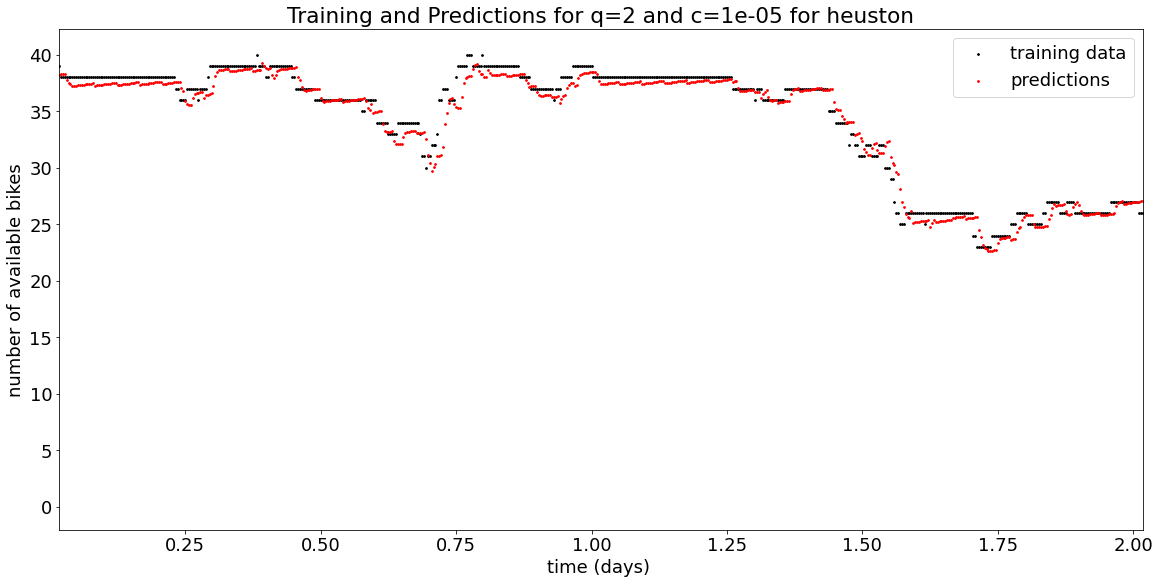

0.0 [-0.30156253  0.10697284  1.17103639  0.02901551  0.02274817 -0.03103379
  0.03865095  0.00553686  0.00118719]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.9770666191208641
rmse: 1.9538716501979079


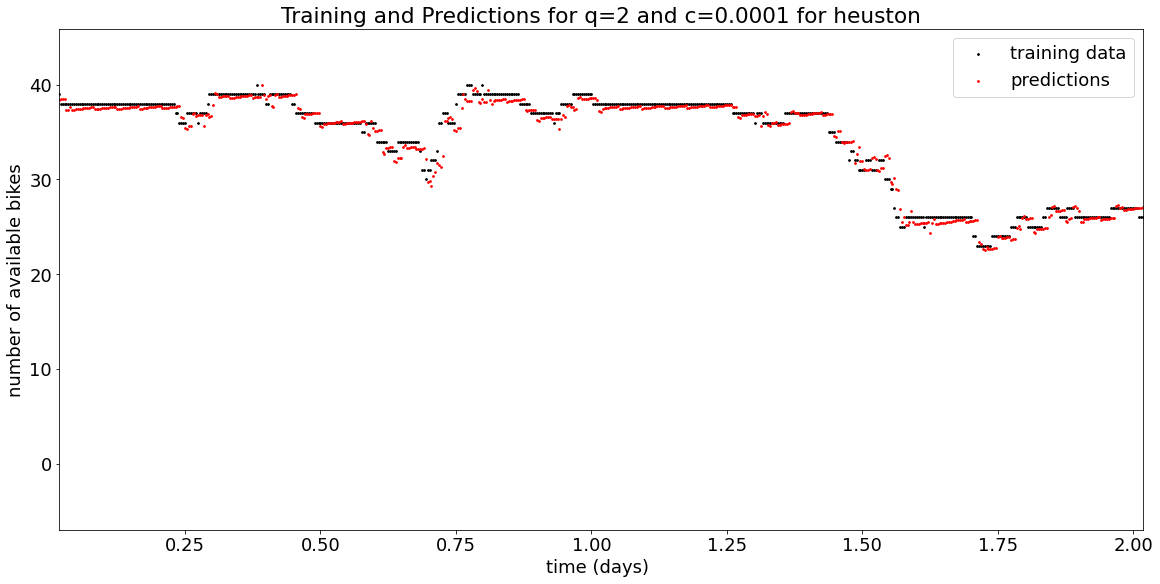

0.0 [-0.35412976 -0.07682719  1.40825313  0.08112648  0.02617256 -0.03256337
  0.03552468  0.00578428  0.00142721]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.9777168444046979
rmse: 1.9299837083292435


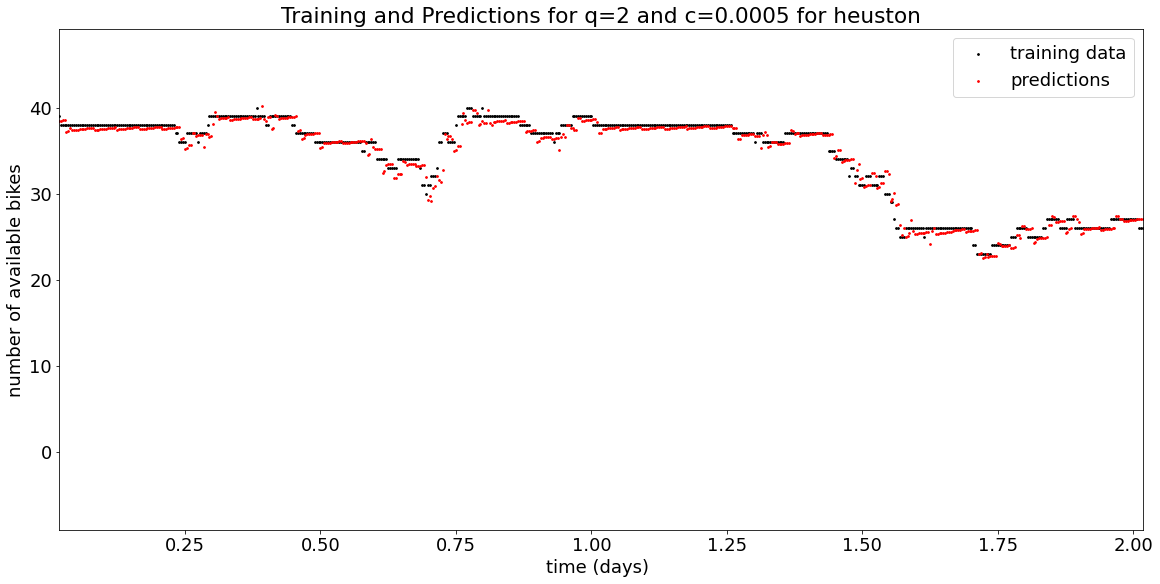

0.0 [-0.35268292 -0.12410907  1.45416329  0.10591743  0.02612255 -0.03299699
  0.03504682  0.00580987  0.00159238]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.9777566903347443
rmse: 1.928896115336935


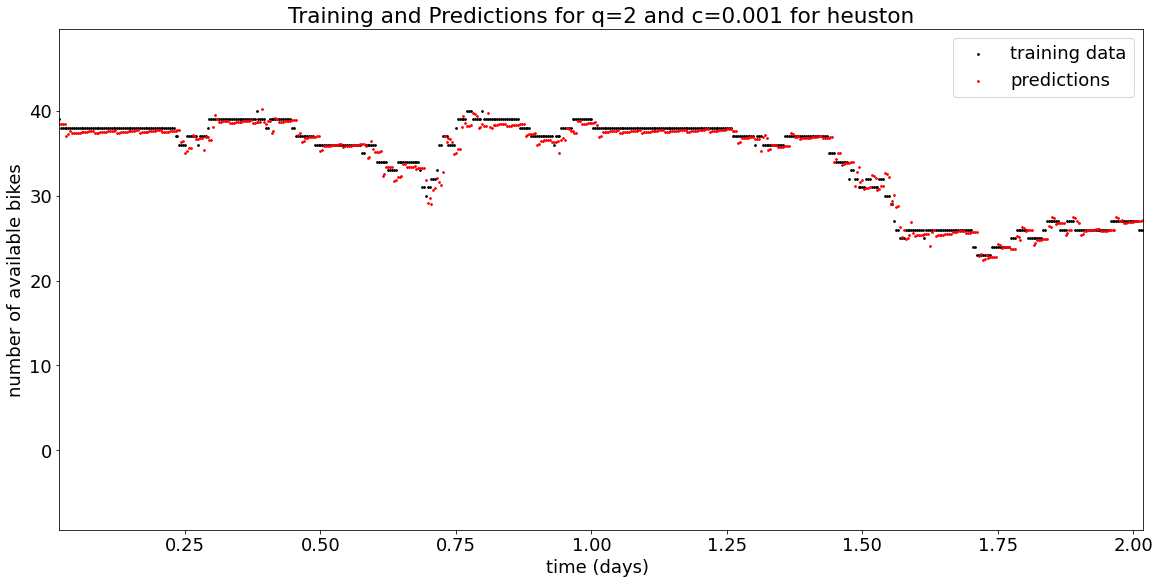

0.0 [-0.34797441 -0.17074615  1.49610254  0.14075225  0.02559681 -0.03356367
  0.03466029  0.00582493  0.00183848]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.9777722322289772
rmse: 1.9287578937852299


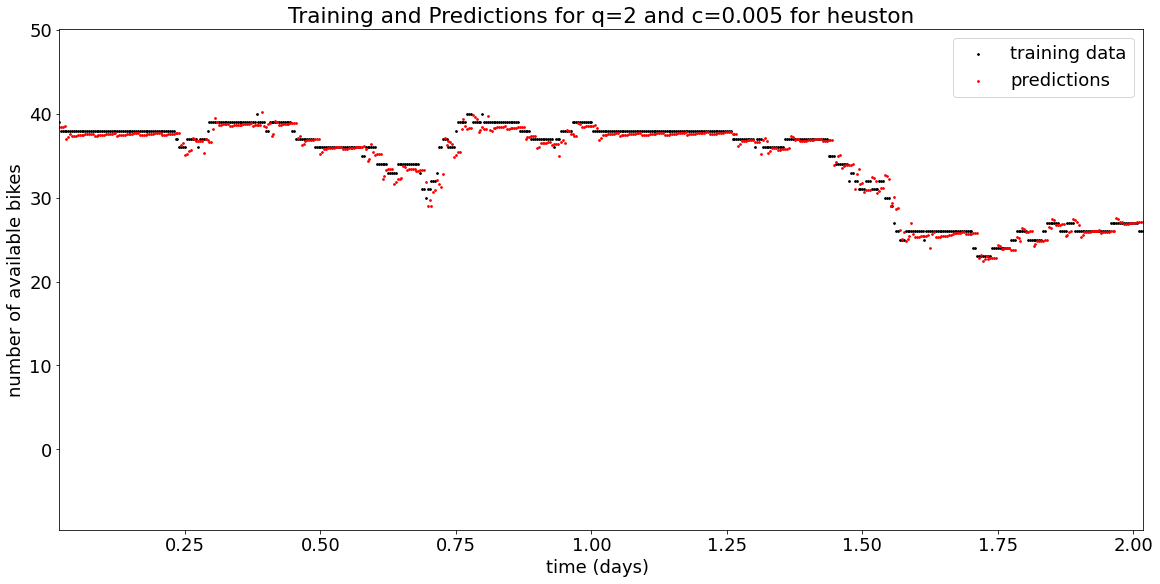

0.0 [-0.34710029 -0.17726255  1.50173985  0.1468309   0.02547456 -0.03366027
  0.03461277  0.00582624  0.00188242]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.9777727974995888
rmse: 1.9288014789688608


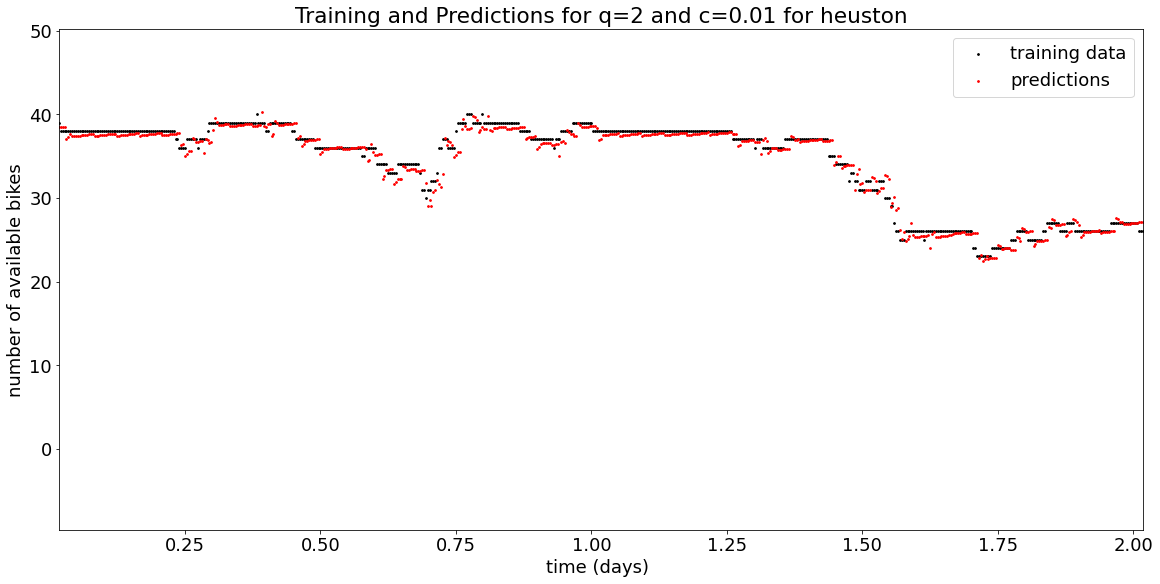

0.0 [-0.34634879 -0.18259961  1.50631992  0.15209358  0.02536363 -0.03374357
  0.03457506  0.00582716  0.00192063]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.9777729837537362
rmse: 1.92884797345742


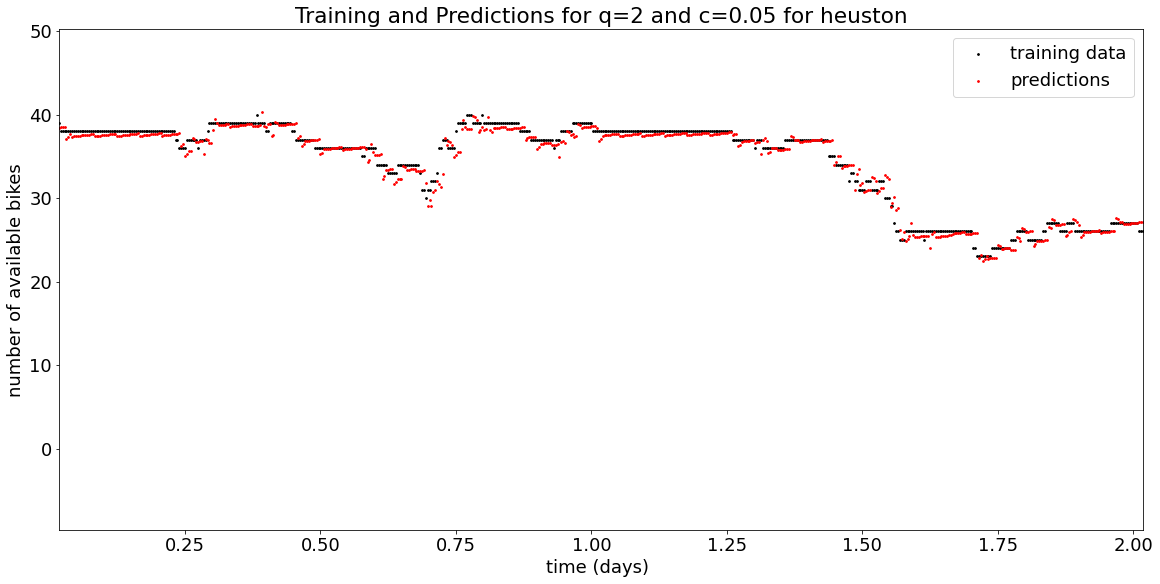

0.0 [-0.3462515  -0.18327469  1.50689692  0.15277859  0.02534887 -0.03375439
  0.03457036  0.00582727  0.00192562]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.9777729896839995
rmse: 1.9288545416821117


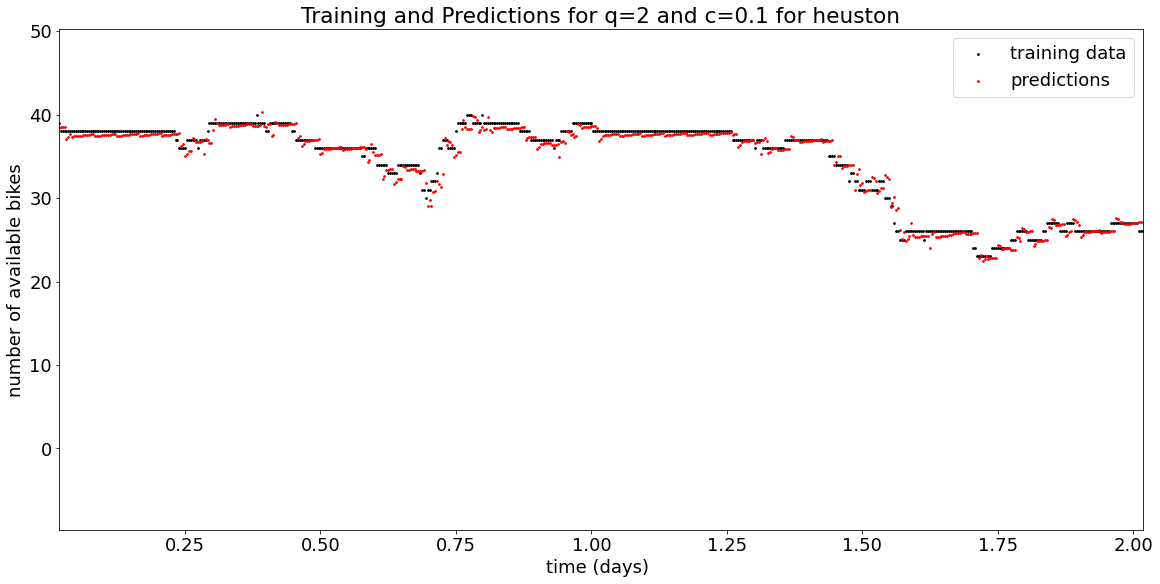

0.0 [-0.34617313 -0.18381603  1.50735924  0.15333114  0.02533691 -0.03376312
  0.03456662  0.00582736  0.00192964]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.9777729915875876
rmse: 1.9288599199083218


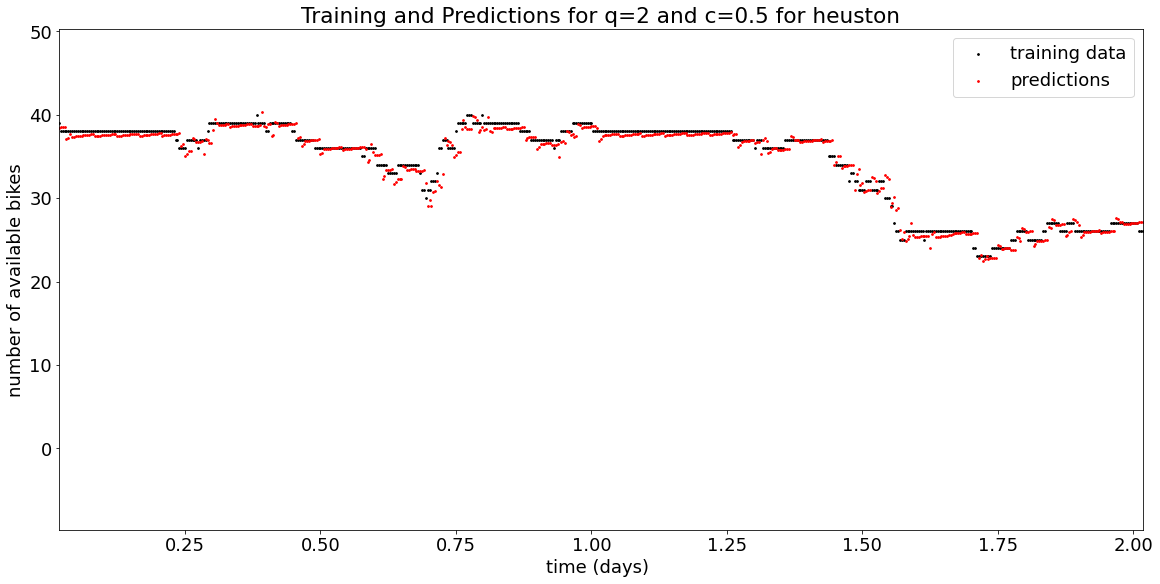

0.0 [-0.3461633  -0.18388378  1.50741707  0.1534005   0.02533541 -0.03376421
  0.03456615  0.00582737  0.00193015]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.977772991647189
rmse: 1.9288605999473365


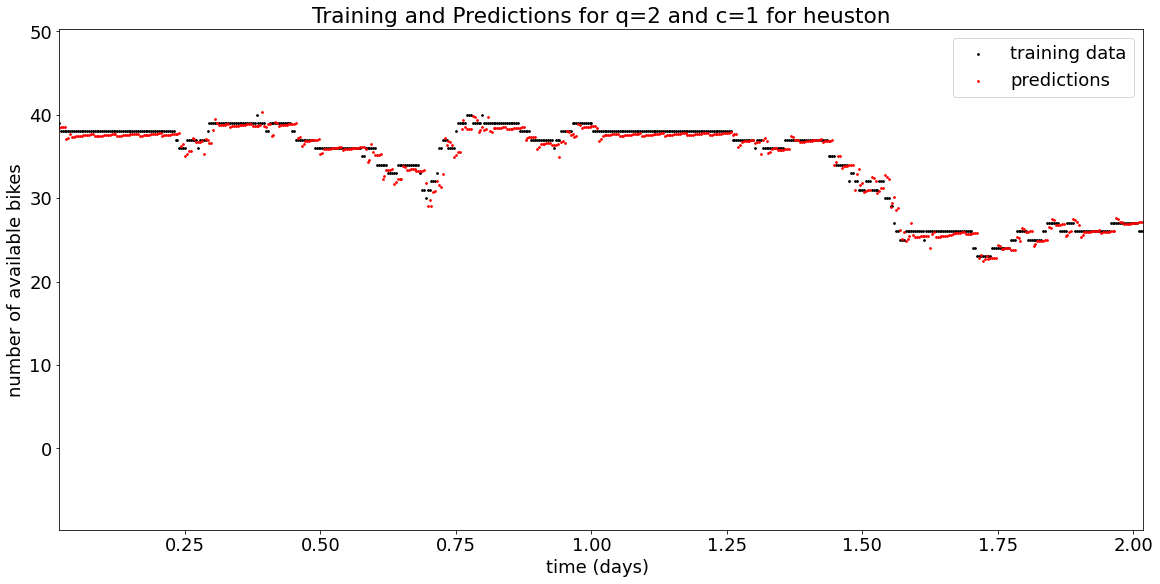

0.0 [-0.34615543 -0.18393799  1.50746335  0.15345603  0.02533421 -0.03376509
  0.03456577  0.00582737  0.00193055]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.9777729916662674
rmse: 1.928861145222994


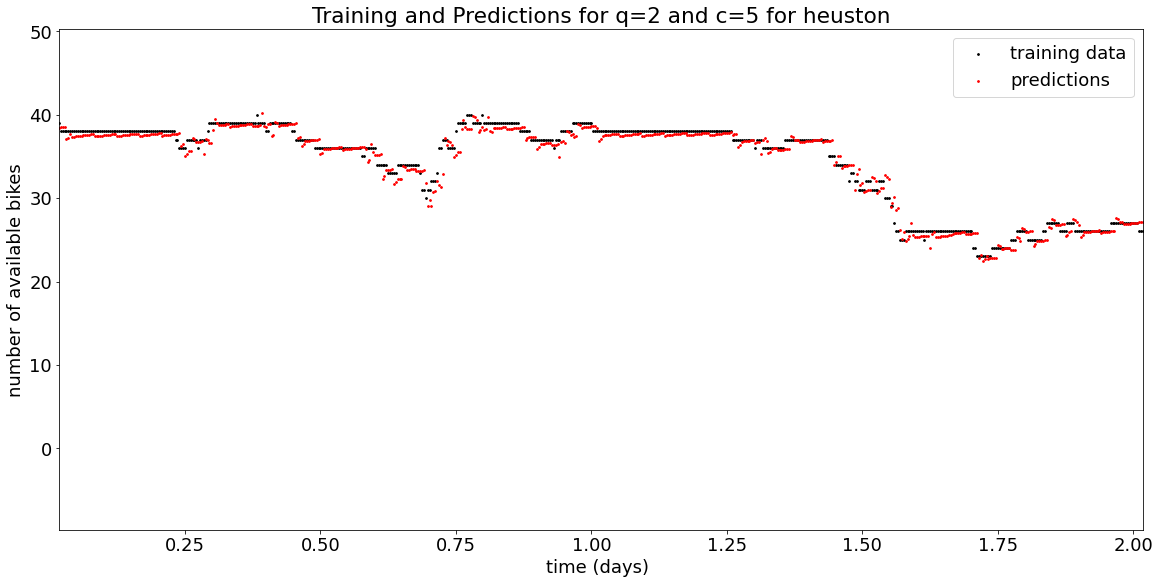

0.0 [-0.34615445 -0.18394477  1.50746913  0.15346297  0.02533405 -0.0337652
  0.03456573  0.00582738  0.0019306 ]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.9777729916668637
rmse: 1.92886121346026


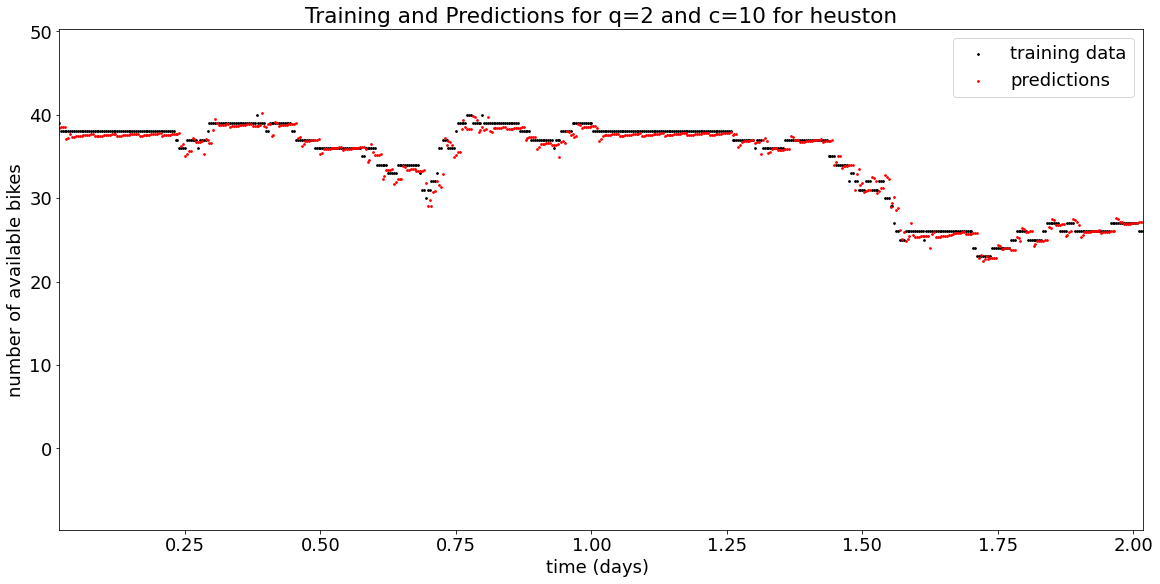

0.0 [-0.34615366 -0.18395019  1.50747376  0.15346853  0.02533393 -0.03376528
  0.03456569  0.00582738  0.00193064]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.9777729916670546
rmse: 1.9288612680625283


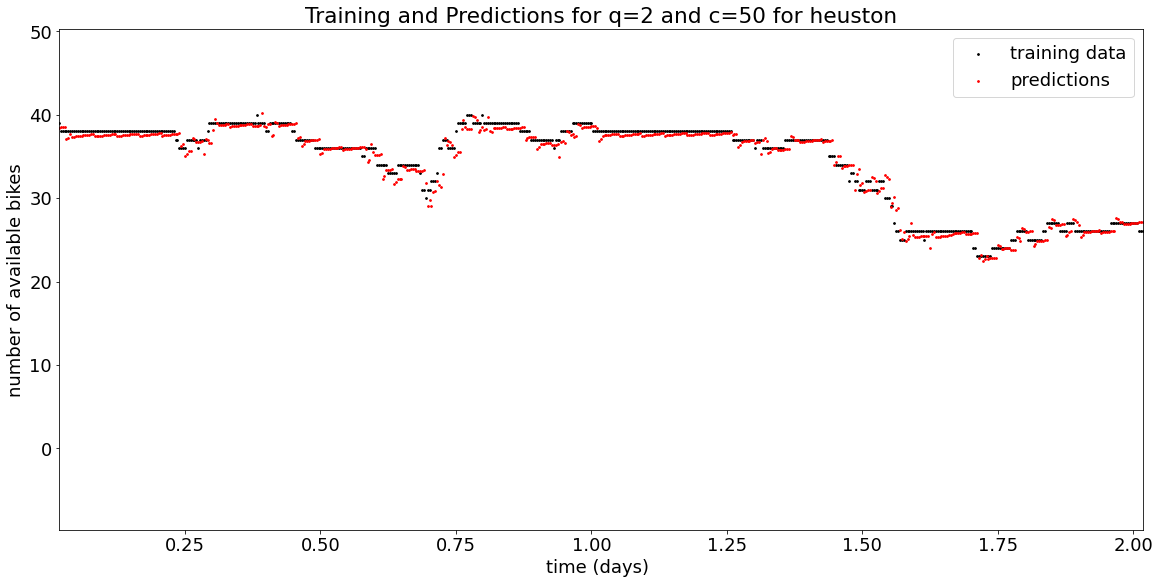

0.0 [-0.34615356 -0.18395087  1.50747434  0.15346922  0.02533392 -0.0337653
  0.03456568  0.00582738  0.00193065]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.9777729916670606
rmse: 1.9288612748885883


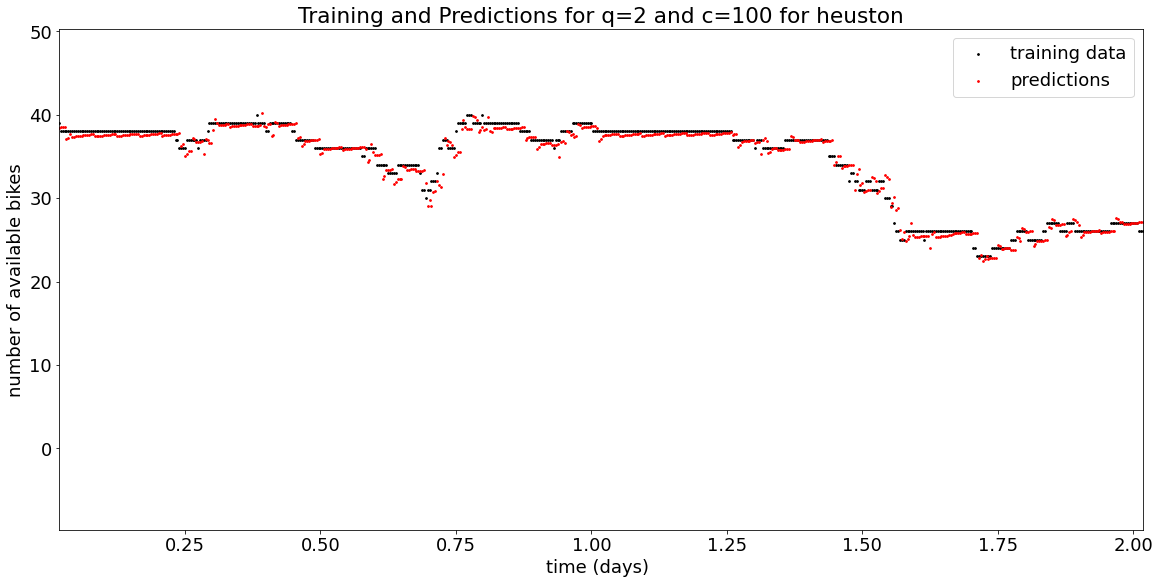

0.0 [-0.34615347 -0.18395148  1.50747486  0.15346984  0.02533391 -0.03376531
  0.03456568  0.00582738  0.00193065]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.9777729916670626
rmse: 1.928861281032196


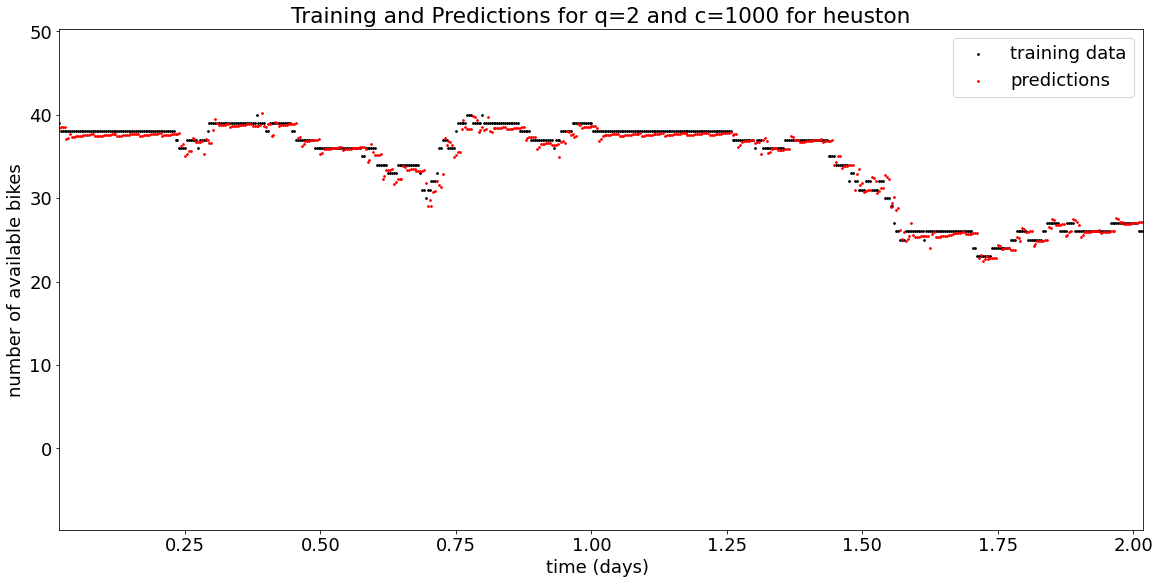

minimum c:0.005
1.9287578937852299
q=6,samples=d,lag=3
XX:
16544
y:
17414
0.0 [ 0.06361008 -0.0500277   0.6102564  -0.11404173  0.25475845  0.8914401
  0.3618345   0.04479524  0.01028482]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.41837149340274904
rmse: 9.9168691124728


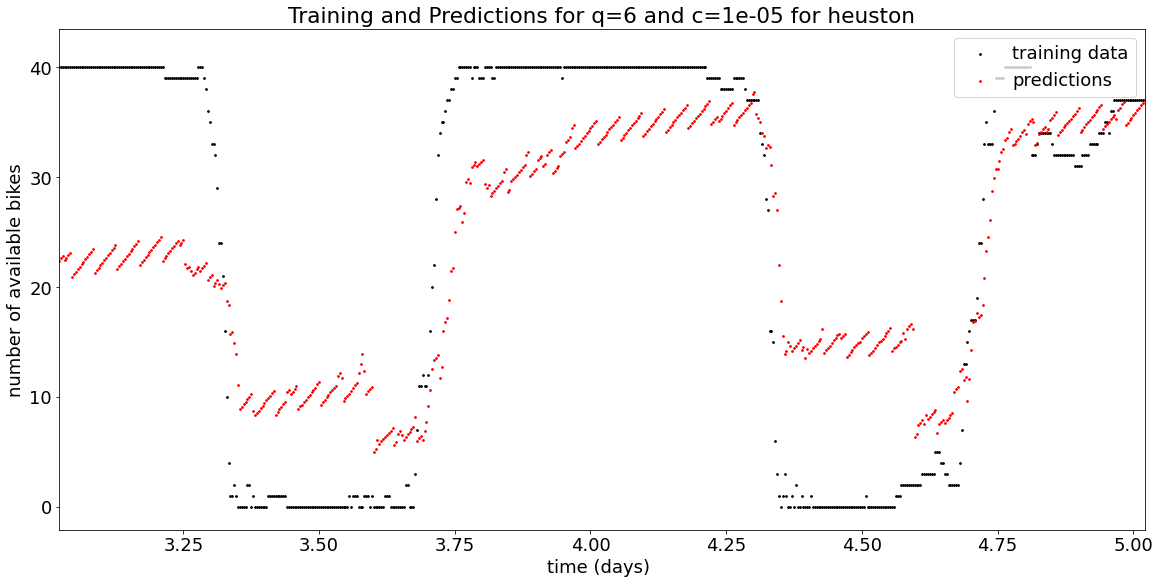

0.0 [ 0.05379519 -0.06112296  0.60834943 -1.1258837   0.64670308  1.40763777
  0.34591656  0.02163051 -0.02630755]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
score: 0.43564598947133626
rmse: 9.808742378944459


KeyboardInterrupt: ignored

In [64]:
plt.rc('font', size=18); plt.rcParams['figure.constrained_layout.use'] = True
# read data. column 1 is date/time, col 6 is #bikes
newdf = pd.read_csv("df_heuston.csv", usecols = ['TIME','AVAILABLE BIKES',
                                                  'WEEKEND',"MONTH", 
                                                  "DAY_OF_WEEK", "HOUR", 
                                                  "MINUTE", "DAY", 
                                                  "BIKE STANDS", 
                                                  "AVAILABLE BIKE STANDS"], 
                          parse_dates=['TIME'])

print(newdf.columns)
start=pd.to_datetime('2020-02-01 00:05:02',format='%Y-%m-%d %H:%M:%S')
end=pd.to_datetime('2020-04-01 23:55:02',format='%Y-%m-%d %H:%M:%S')

# convert date/time to unix timestamp in sec
t_full=pd.array(pd.DatetimeIndex(newdf.iloc[:,0]).astype(np.int64))/1000000000
dt = t_full[1] - t_full[0]
# print(t_full)
print("data sampling interval is %d secs"%dt)

# extract data between start and end dates
t_start = pd.DatetimeIndex([start]).astype(np.int64)/1000000000
t_end = pd.DatetimeIndex([end]).astype(np.int64)/1000000000
t = np.extract( [(t_full >= t_start[0]) & (t_full <= t_end[0])] , t_full)
# convert timestamp to days
t=(t-t[0])/(60*60*24)
# print(t)
y = np.extract([(t_full >= t_start[0]) & (t_full <= t_end[0])], newdf.iloc[:,9]).astype(np.int64)
# plt.scatter(t,y)
# plt.show()

# plot extracted data
# plt.scatter(t,y, color='red', marker='.'); plt.show()

def test_preds(q,samples,lag,plot):
  #q−step ahead prediction
  stride=1
  XX=y[0:y.size-q-lag*samples:stride]
  
  weekendvals=newdf['WEEKEND'][0:y.size-q-lag*samples:stride]
  monthvals = newdf['MONTH'][0:y.size-q-lag*samples:stride]
  dayofweekvals = newdf['DAY_OF_WEEK'][0:y.size-q-lag*samples:stride]
  hourvals=newdf['HOUR'][0:y.size-q-lag*samples:stride]
  minutevals=newdf['MINUTE'][0:y.size-q-lag*samples:stride]
  dayvals=newdf['DAY'][0:y.size-q-lag*samples:stride]

  print("XX:");   print(XX.size);
  print("y:");   print(y.size);
  for i in range(1,lag):
    # add lag including number of samples perday, since we have a time stamp each day, if we want to get 5 mins earlier we might need yesterdays same time -5??

    X = y[i*samples:y.size-q-(lag-i) * samples : stride]
    XX=np.column_stack((XX,X))

  XX=np.column_stack((XX,weekendvals,monthvals,dayofweekvals,hourvals,
                      minutevals,dayvals))

  yy=y[lag*samples+q::stride]; tt=t[lag*samples+q::stride]
  train, test = train_test_split(np.arange(0,yy.size),test_size=0.2, shuffle=False)
  
  minC=100; minRMSE = 100
  cValues = [0.00001, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 1000] ## 0.0005 or 0.0001
  for c in cValues:
    model = Ridge(alpha=1/(2*c), fit_intercept=False).fit(XX[train], yy[train])
    print(model.intercept_, model.coef_)
    if plot:
      y_pred = model.predict(XX)
      print(type(t))
      print(type(y))
      plt.figure(figsize=(16,8))
      plt.scatter(t, y, color='black', s=3); 
      plt.scatter(tt, y_pred, color='red', s=3)
      plt.xlabel("time (days) "); plt.ylabel("number of available bikes")
      plt.legend(["training data","predictions"],loc='upper right')
      plt.title(f"Training and Predictions for q={q} and c={c} for heuston")
      day=math.floor(24*60*60/dt) # number of samples per day
      plt.xlim(((lag*samples+q)/day,(lag*samples+q)/day+2))
      print("score: " + str(model.score(XX[train], yy[train])))
      print("rmse: " + str(mean_squared_error(yy, y_pred, squared=False)))
      if (mean_squared_error(yy, y_pred, squared=False) < minRMSE):
        minC = c
        minRMSE = mean_squared_error(yy, y_pred, squared=False)

      plt.show()
  print("minimum c:" + str(minC))
  print(minRMSE)

# prediction using short−term trend
plot=True
print("q=2,samples=1,lag=3")
test_preds(q=2,samples=1,lag=3,plot=plot)
# prediction using daily seasonality
d=math.floor(24*60*60/dt) # number of samples per day (hr * mins). d=math.floor(24*60*60/dt)
print("q=6,samples=d,lag=3")
test_preds(q=6,samples=d,lag=3,plot=plot) # test_preds(q=d,samples=d,lag=3,plot=plot)
print("q=12,samples=d,lag=3")
test_preds(q=12,samples=d,lag=3,plot=plot)
# prediction using weekly seasonality
w=math.floor(7*24*60*60/dt) # number of samples per day # w=math.floor(7*24*60*60/dt) 
print("q=6,samples=w,lag=3")
test_preds(q=6,samples=w,lag=3,plot=plot)
print("q=12,samples=w,lag=3")
test_preds(q=12,samples=w,lag=3,plot=plot)
           

print("together 1")
# 1 

#putting it together
# for half an hour
q = 6
lag=3; stride=1
w=math.floor(7*24*60*60/dt) # number of samples per week
# len = y.size−w−lag*w−q
length_sample = y.size-w-lag*w-q
XX=y[q:q+length_sample:stride]

weekendvals=newdf['WEEKEND'][q:q+length_sample:stride]
monthvals = newdf['MONTH'][q:q+length_sample:stride]
dayofweekvals = newdf['DAY_OF_WEEK'][q:q+length_sample:stride]
hourvals=newdf['HOUR'][q:q+length_sample:stride]
minutevals=newdf['MINUTE'][q:q+length_sample:stride]
dayvals=newdf['DAY'][q:q+length_sample:stride]

for i in range(1,lag):
  X=y[i*w+q:i*w+q+length_sample:stride]
  XX=np.column_stack((XX,X))
d=math.floor(24*60*60/dt) # number of samples per day
for i in range(0,lag):
  X=y[i*d+q:i*d+q+length_sample:stride]
  XX=np.column_stack((XX,X))
for i in range(0,lag):
  X=y[i:i+length_sample:stride]
  XX=np.column_stack((XX,X))

XX=np.column_stack((XX,weekendvals,monthvals))

yy=y[lag*w+w+q:lag*w+w+q+length_sample:stride]
tt=t[lag*w+w+q:lag*w+w+q+length_sample:stride]
train, test = train_test_split(np.arange(0,yy.size),test_size=0.2)
#train = np.arange(0,yy.size)
model = Ridge(alpha=1/(2*0.005), fit_intercept=False).fit(XX[train], yy[train])
print("score: " + str(model.score(XX[train], yy[train])))
print(model.intercept_, model.coef_)
if plot:
  y_pred = model.predict(XX)
  plt.figure(figsize=(16,8))
  plt.scatter(t, y, color='black', s=3);
  plt.scatter(tt, y_pred, color='red', s=3)
  plt.xlabel("time (days)")
  plt.ylabel("number of available bikes")
  plt.legend(["training data","predictions"],loc='upper right')
  plt.title(f"training and prediction for q={q} and c=0.005 for heuston")
  day=math.floor(24*60*60/dt) # number of samples per day
  plt.xlim((4*7,4*7+4))
  print("rmse: " + str(mean_squared_error(yy, y_pred, squared=False)))
  plt.show()


print("together 2")
# 2

#putting it together
# for 1 hr
q = 12
lag=3; stride=1
w=math.floor(7*24*60*60/dt) # number of samples per week
# len = y.size−w−lag*w−q
length_sample = y.size-w-lag*w-q
XX=y[q:q+length_sample:stride]

weekendvals=newdf['WEEKEND'][q:q+length_sample:stride]
monthvals = newdf['MONTH'][q:q+length_sample:stride]
dayofweekvals = newdf['DAY_OF_WEEK'][q:q+length_sample:stride]
hourvals=newdf['HOUR'][q:q+length_sample:stride]
minutevals=newdf['MINUTE'][q:q+length_sample:stride]
dayvals=newdf['DAY'][q:q+length_sample:stride]

for i in range(1,lag):
  X=y[i*w+q:i*w+q+length_sample:stride]
  XX=np.column_stack((XX,X))
d=math.floor(24*60*60/dt) # number of samples per day
for i in range(0,lag):
  X=y[i*d+q:i*d+q+length_sample:stride]
  XX=np.column_stack((XX,X))
for i in range(0,lag):
  X=y[i:i+length_sample:stride]
  XX=np.column_stack((XX,X))

XX=np.column_stack((XX,weekendvals,monthvals,dayofweekvals))

yy=y[lag*w+w+q:lag*w+w+q+length_sample:stride]
tt=t[lag*w+w+q:lag*w+w+q+length_sample:stride]
train, test = train_test_split(np.arange(0,yy.size),test_size=0.2)
model = Ridge(alpha=1/(2*0.005), fit_intercept=False).fit(XX[train], yy[train])
print("score: " + str(model.score(XX[train], yy[train])))
print(model.intercept_, model.coef_)
if plot:
  y_pred = model.predict(XX)
  plt.figure(figsize=(16,8))
  plt.scatter(t, y, color='black', s=3); plt.scatter(tt, y_pred, color='green', s=3)
  plt.xlabel("time (days)")
  plt.ylabel("number of available bikes")
  plt.title(f"training and prediction for q={q} and c=0.005 for heuston")
  plt.legend(["training data","predictions"],loc='upper right')
  day=math.floor(24*60*60/dt) # number of samples per day
  plt.xlim((4*7,4*7+4))
  print("rmse: " + str(mean_squared_error(yy, y_pred, squared=False)))
  plt.show()

# LSTM townsend
vanilla

## 10 mins ahead

In [ ]:
newdf = pd.read_csv("df_townsend.csv", usecols = ['TIME','AVAILABLE BIKES'], 
                          parse_dates=['TIME'])

In [ ]:
print(newdf)

In [ ]:
def test_preds1(q,dd,lag,plot):
  #q−step ahead prediction
  stride=1
  XX=y[0:y.size-q-lag*dd:stride]
  for i in range(1,lag):
    # add lag including number of samples perday, since we have a time stamp each day, if we want to get 5 mins earlier we might need yesterdays same time -5??

    X = y[i*dd:y.size-q-(lag-i) * dd : stride]
    XX=np.column_stack((XX,X))
  yy=y[lag*dd+q::stride]; tt=t[lag*dd+q::stride]
  print(XX)
  print(yy)
  print("XX:");   print(XX.size);
  print("y:");   print(yy.size);
  return XX,yy,tt

In [ ]:
start=pd.to_datetime('2020-02-01 00:05:02',format='%Y-%m-%d %H:%M:%S')
end=pd.to_datetime('2020-03-01 23:55:02',format='%Y-%m-%d %H:%M:%S')

# convert date/time to unix timestamp in sec
t_full=pd.array(pd.DatetimeIndex(newdf.iloc[:,0]).astype(np.int64))/1000000000
dt = t_full[1] - t_full[0]
print("data sampling interval is %d secs"%dt)

# extract data between start and end dates
t_start = pd.DatetimeIndex([start]).astype(np.int64)/1000000000
t_end = pd.DatetimeIndex([end]).astype(np.int64)/1000000000
t = np.extract( [(t_full >= t_start[0]) & (t_full <= t_end[0])] , t_full)
t=(t-t[0])/(60*60*24)
y = np.extract([(t_full >= t_start[0]) & (t_full <= t_end[0])], newdf.iloc[:,1]).astype(np.int64)

print("y:" + str(y.shape))
print("t:" + str(t.shape))

# q = 2 for 10 mins
x1,y1,tt = test_preds1(q=2,dd=1,lag=3,plot=True)

In [ ]:
x1.shape

In [ ]:
# univariate data preparation

def split_sequence(x_sequence, y_sequence, n_steps):
	X, y = list(), list()
	for i in range(len(x_sequence)+1):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(x_sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = x_sequence[i:end_ix], y_sequence[end_ix-1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(x1, y1, n_steps)
# summarize the data
# for i in range(len(X)):
# 	print(X[i], y[i])

In [ ]:
n_features = X.shape[2]

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

train, test = train_test_split(np.arange(0,y1.size-1),test_size=0.2, shuffle=False)

# samples = length of X, nsteps=3, nfeatures = 3,
# reshape from [samples, timesteps] into [samples, timesteps, features]

# fit model
model.fit(X[train], y[train], epochs=100, verbose=2)

In [ ]:
pred = []
for i in X[test-1]:
  i = i.reshape((1, n_steps, n_features))
  ypred = model.predict(i, verbose=0)
  pred.append(ypred[0][0])
  # print(ypred[0][0])

In [ ]:
start=pd.to_datetime('2020-02-01 00:05:02',format='%Y-%m-%d %H:%M:%S')
end=pd.to_datetime('2020-03-01 23:55:02',format='%Y-%m-%d %H:%M:%S')

# convert date/time to unix timestamp in sec
t_full=pd.array(pd.DatetimeIndex(newdf.iloc[:,0]).astype(np.int64))/1000000000
dt = t_full[1] - t_full[0]
print("data sampling interval is %d secs"%dt)

# extract data between start and end dates
t_start = pd.DatetimeIndex([start]).astype(np.int64)/1000000000
t_end = pd.DatetimeIndex([end]).astype(np.int64)/1000000000
t = np.extract( [(t_full >= t_start[0]) & (t_full <= t_end[0])] , t_full)
t=(t-t[0])/(60*60*24)
y = np.extract([(t_full >= t_start[0]) & (t_full <= t_end[0])], newdf.iloc[:,1]).astype(np.int64)

print("y:" + str(y.shape))
print("t:" + str(t.shape))

# q = 2 for 10 mins
x1,y1,tt = test_preds1(q=2,dd=1,lag=3,plot=True)

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(t, y, color='black'); 
plt.plot(t[test], pred, color='red')
plt.xlabel("time (days)"); plt.ylabel("number of available bikes")
plt.legend(["training data","predictions"],loc='upper right')
plt.title("training and predictions for 10 minutes in the future using LSTM for townsend")
plt.xlim(20, 30)
plt.show()

In [ ]:
mean_squared_error(y[test], pred, squared=False)

## 30 mins ahead

In [ ]:
start=pd.to_datetime('2020-02-01 00:05:02',format='%Y-%m-%d %H:%M:%S')
end=pd.to_datetime('2020-03-01 23:55:02',format='%Y-%m-%d %H:%M:%S')

# convert date/time to unix timestamp in sec
t_full=pd.array(pd.DatetimeIndex(newdf.iloc[:,0]).astype(np.int64))/1000000000
dt = t_full[1] - t_full[0]
print("data sampling interval is %d secs"%dt)

# extract data between start and end dates
t_start = pd.DatetimeIndex([start]).astype(np.int64)/1000000000
t_end = pd.DatetimeIndex([end]).astype(np.int64)/1000000000
t = np.extract( [(t_full >= t_start[0]) & (t_full <= t_end[0])] , t_full)
t=(t-t[0])/(60*60*24)
y = np.extract([(t_full >= t_start[0]) & (t_full <= t_end[0])], newdf.iloc[:,1]).astype(np.int64)

print("y:" + str(y.shape))
print("t:" + str(t.shape))

# q = 6 for 30 mins
d=1#math.floor(24*60*60/dt) # number of samples per day
x2,y2,tt2 = test_preds1(q=6,dd=d,lag=3,plot=True)

In [ ]:
n_steps = 3
# split into samples
X, y = split_sequence(x2, y2, n_steps)

n_features = X.shape[2]

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

train, test = train_test_split(np.arange(0,y2.size-1),test_size=0.2, shuffle=False)

# samples = length of X, nsteps=3, nfeatures = 3,
# reshape from [samples, timesteps] into [samples, timesteps, features]

# fit model
model.fit(X[train], y[train], epochs=100, verbose=2)

In [ ]:
pred = []
for i in X[test-1]:
  i = i.reshape((1, n_steps, n_features))
  ypred = model.predict(i, verbose=0)
  pred.append(ypred[0][0])

In [ ]:
start=pd.to_datetime('2020-02-01 00:05:02',format='%Y-%m-%d %H:%M:%S')
end=pd.to_datetime('2020-03-01 23:55:02',format='%Y-%m-%d %H:%M:%S')

# convert date/time to unix timestamp in sec
t_full=pd.array(pd.DatetimeIndex(newdf.iloc[:,0]).astype(np.int64))/1000000000
dt = t_full[1] - t_full[0]
print("data sampling interval is %d secs"%dt)

# extract data between start and end dates
t_start = pd.DatetimeIndex([start]).astype(np.int64)/1000000000
t_end = pd.DatetimeIndex([end]).astype(np.int64)/1000000000
t = np.extract( [(t_full >= t_start[0]) & (t_full <= t_end[0])] , t_full)
t=(t-t[0])/(60*60*24)
y = np.extract([(t_full >= t_start[0]) & (t_full <= t_end[0])], newdf.iloc[:,1]).astype(np.int64)

print("y:" + str(y.shape))
print("t:" + str(t.shape))

# q = 6 for 30 mins
d=1#math.floor(24*60*60/dt) # number of samples per day
x2,y2,tt2 = test_preds1(q=6,dd=d,lag=3,plot=True)

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(t, y, color='black'); 
plt.plot(t[test], pred, color='red')
plt.xlabel("time (days)"); plt.ylabel("number of available bikes")
plt.legend(["training data","predictions"],loc='upper right')
plt.title("training and predictions for 30 minutes in the future using LSTM for townsend")
plt.xlim(20, 30)
plt.show()

print(mean_squared_error(y[test], pred, squared=False))

## 1hr ahead


In [ ]:
start=pd.to_datetime('2020-02-01 00:05:02',format='%Y-%m-%d %H:%M:%S')
end=pd.to_datetime('2020-03-01 23:55:02',format='%Y-%m-%d %H:%M:%S')

# convert date/time to unix timestamp in sec
t_full=pd.array(pd.DatetimeIndex(newdf.iloc[:,0]).astype(np.int64))/1000000000
dt = t_full[1] - t_full[0]
print("data sampling interval is %d secs"%dt)

# extract data between start and end dates
t_start = pd.DatetimeIndex([start]).astype(np.int64)/1000000000
t_end = pd.DatetimeIndex([end]).astype(np.int64)/1000000000
t = np.extract( [(t_full >= t_start[0]) & (t_full <= t_end[0])] , t_full)
t=(t-t[0])/(60*60*24)
y = np.extract([(t_full >= t_start[0]) & (t_full <= t_end[0])], newdf.iloc[:,1]).astype(np.int64)

print("y:" + str(y.shape))
print("t:" + str(t.shape))

# q = 12 for 60 mins

w=math.floor(24*60*60/dt) # number of samples per day # w=math.floor(7*24*60*60/dt) 
x3,y3,tt3 = test_preds1(q=12,dd=w,lag=3,plot=plot)

In [ ]:
n_steps = 3
# split into samples
X, y = split_sequence(x3, y3, n_steps)

n_features = X.shape[2]

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

train, test = train_test_split(np.arange(0,y3.size-1),test_size=0.2, shuffle=False)

# samples = length of X, nsteps=3, nfeatures = 3,
# reshape from [samples, timesteps] into [samples, timesteps, features]

# fit model
model.fit(X[train], y[train], epochs=100, verbose=2)

In [ ]:
pred = []
for i in X[test-1]:
  i = i.reshape((1, n_steps, n_features))
  ypred = model.predict(i, verbose=0)
  pred.append(ypred[0][0])

In [ ]:
start=pd.to_datetime('2020-02-01 00:05:02',format='%Y-%m-%d %H:%M:%S')
end=pd.to_datetime('2020-03-01 23:55:02',format='%Y-%m-%d %H:%M:%S')

# convert date/time to unix timestamp in sec
t_full=pd.array(pd.DatetimeIndex(newdf.iloc[:,0]).astype(np.int64))/1000000000
dt = t_full[1] - t_full[0]
print("data sampling interval is %d secs"%dt)

# extract data between start and end dates
t_start = pd.DatetimeIndex([start]).astype(np.int64)/1000000000
t_end = pd.DatetimeIndex([end]).astype(np.int64)/1000000000
t = np.extract( [(t_full >= t_start[0]) & (t_full <= t_end[0])] , t_full)
t=(t-t[0])/(60*60*24)
y = np.extract([(t_full >= t_start[0]) & (t_full <= t_end[0])], newdf.iloc[:,1]).astype(np.int64)

print("y:" + str(y.shape))
print("t:" + str(t.shape))

# q = 12 for 60 mins

w=math.floor(24*60*60/dt) # number of samples per day # w=math.floor(7*24*60*60/dt) 
x3,y3,tt3 = test_preds1(q=12,dd=w,lag=3,plot=plot)

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(t, y, color='black'); 
plt.plot(t[test], pred, color='red')
plt.xlabel("time (days)"); plt.ylabel("number of available bikes")
plt.legend(["training data","predictions"],loc='upper right')
plt.title("training and predictions for 1 hour in the future using LSTM for townsend")
plt.xlim(20, 30)
plt.show()

print(mean_squared_error(y[test], pred, squared=False))

# LSTM heuston

## 10 mins ahead

In [ ]:
newdf = pd.read_csv("df_heuston.csv", usecols = ['TIME','AVAILABLE BIKES'], 
                          parse_dates=['TIME'])

In [ ]:
print(newdf)

In [ ]:
start=pd.to_datetime('2020-02-01 00:05:02',format='%Y-%m-%d %H:%M:%S')
end=pd.to_datetime('2020-03-01 23:55:02',format='%Y-%m-%d %H:%M:%S')

# convert date/time to unix timestamp in sec
t_full=pd.array(pd.DatetimeIndex(newdf.iloc[:,0]).astype(np.int64))/1000000000
dt = t_full[1] - t_full[0]
print("data sampling interval is %d secs"%dt)

# extract data between start and end dates
t_start = pd.DatetimeIndex([start]).astype(np.int64)/1000000000
t_end = pd.DatetimeIndex([end]).astype(np.int64)/1000000000
t = np.extract( [(t_full >= t_start[0]) & (t_full <= t_end[0])] , t_full)
t=(t-t[0])/(60*60*24)
y = np.extract([(t_full >= t_start[0]) & (t_full <= t_end[0])], newdf.iloc[:,1]).astype(np.int64)

print("y:" + str(y.shape))
print("t:" + str(t.shape))

# q = 2 for 10 mins
x1,y1,tt = test_preds1(q=2,dd=1,lag=3,plot=True)

In [ ]:
# univariate data preparation

def split_sequence(x_sequence, y_sequence, n_steps):
	X, y = list(), list()
	for i in range(len(x_sequence)+1):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(x_sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = x_sequence[i:end_ix], y_sequence[end_ix-1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(x1, y1, n_steps)
# summarize the data
# for i in range(len(X)):
# 	print(X[i], y[i])

In [ ]:
n_features = X.shape[2]

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

train, test = train_test_split(np.arange(0,y1.size-1),test_size=0.2, shuffle=False)

# samples = length of X, nsteps=3, nfeatures = 3,
# reshape from [samples, timesteps] into [samples, timesteps, features]

# fit model
model.fit(X[train], y[train], epochs=100, verbose=2)

In [ ]:
pred = []
for i in X[test-1]:
  i = i.reshape((1, n_steps, n_features))
  ypred = model.predict(i, verbose=0)
  pred.append(ypred[0][0])
  # print(ypred[0][0])

In [ ]:
start=pd.to_datetime('2020-02-01 00:05:02',format='%Y-%m-%d %H:%M:%S')
end=pd.to_datetime('2020-03-01 23:55:02',format='%Y-%m-%d %H:%M:%S')

# convert date/time to unix timestamp in sec
t_full=pd.array(pd.DatetimeIndex(newdf.iloc[:,0]).astype(np.int64))/1000000000
dt = t_full[1] - t_full[0]
print("data sampling interval is %d secs"%dt)

# extract data between start and end dates
t_start = pd.DatetimeIndex([start]).astype(np.int64)/1000000000
t_end = pd.DatetimeIndex([end]).astype(np.int64)/1000000000
t = np.extract( [(t_full >= t_start[0]) & (t_full <= t_end[0])] , t_full)
t=(t-t[0])/(60*60*24)
y = np.extract([(t_full >= t_start[0]) & (t_full <= t_end[0])], newdf.iloc[:,1]).astype(np.int64)

print("y:" + str(y.shape))
print("t:" + str(t.shape))

# q = 2 for 10 mins
x1,y1,tt = test_preds1(q=2,dd=1,lag=3,plot=True)

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(t, y, color='black'); 
plt.plot(t[test], pred, color='green')
plt.xlabel("time (days)"); plt.ylabel("number of available bikes")
plt.legend(["training data","predictions"],loc='upper right')
plt.title("training and predictions for 10 minutes in the future using LSTM for Heuston Bridge")
plt.xlim(20, 30)
plt.show()

In [ ]:
mean_squared_error(y[test], pred, squared=False)

## 30 mins ahead

In [ ]:
start=pd.to_datetime('2020-02-01 00:05:02',format='%Y-%m-%d %H:%M:%S')
end=pd.to_datetime('2020-03-01 23:55:02',format='%Y-%m-%d %H:%M:%S')

# convert date/time to unix timestamp in sec
t_full=pd.array(pd.DatetimeIndex(newdf.iloc[:,0]).astype(np.int64))/1000000000
dt = t_full[1] - t_full[0]
print("data sampling interval is %d secs"%dt)

# extract data between start and end dates
t_start = pd.DatetimeIndex([start]).astype(np.int64)/1000000000
t_end = pd.DatetimeIndex([end]).astype(np.int64)/1000000000
t = np.extract( [(t_full >= t_start[0]) & (t_full <= t_end[0])] , t_full)
t=(t-t[0])/(60*60*24)
y = np.extract([(t_full >= t_start[0]) & (t_full <= t_end[0])], newdf.iloc[:,1]).astype(np.int64)

print("y:" + str(y.shape))
print("t:" + str(t.shape))

# q = 6 for 30 mins
d=1#math.floor(24*60*60/dt) # number of samples per day
x2,y2,tt2 = test_preds1(q=6,dd=d,lag=3,plot=True)

In [ ]:
n_steps = 3
# split into samples
X, y = split_sequence(x2, y2, n_steps)

n_features = X.shape[2]

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

train, test = train_test_split(np.arange(0,y2.size-1),test_size=0.2, shuffle=False)

# samples = length of X, nsteps=3, nfeatures = 3,
# reshape from [samples, timesteps] into [samples, timesteps, features]

# fit model
model.fit(X[train], y[train], epochs=100, verbose=2)

In [ ]:
pred = []
for i in X[test-1]:
  i = i.reshape((1, n_steps, n_features))
  ypred = model.predict(i, verbose=0)
  pred.append(ypred[0][0])

In [ ]:
start=pd.to_datetime('2020-02-01 00:05:02',format='%Y-%m-%d %H:%M:%S')
end=pd.to_datetime('2020-03-01 23:55:02',format='%Y-%m-%d %H:%M:%S')

# convert date/time to unix timestamp in sec
t_full=pd.array(pd.DatetimeIndex(newdf.iloc[:,0]).astype(np.int64))/1000000000
dt = t_full[1] - t_full[0]
print("data sampling interval is %d secs"%dt)

# extract data between start and end dates
t_start = pd.DatetimeIndex([start]).astype(np.int64)/1000000000
t_end = pd.DatetimeIndex([end]).astype(np.int64)/1000000000
t = np.extract( [(t_full >= t_start[0]) & (t_full <= t_end[0])] , t_full)
t=(t-t[0])/(60*60*24)
y = np.extract([(t_full >= t_start[0]) & (t_full <= t_end[0])], newdf.iloc[:,1]).astype(np.int64)

print("y:" + str(y.shape))
print("t:" + str(t.shape))

# q = 6 for 30 mins
d=1#math.floor(24*60*60/dt) # number of samples per day
x2,y2,tt2 = test_preds1(q=6,dd=d,lag=3,plot=True)

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(t, y, color='black'); 
plt.plot(t[test], pred, color='red')
plt.xlabel("time (days)"); plt.ylabel("number of available bikes")
plt.legend(["training data","predictions"],loc='upper right')
plt.title("training and predictions for 30 minutes in the future using LSTM for Heuston Bridge")
plt.xlim(20, 30)
plt.show()

print(mean_squared_error(y[test], pred, squared=False))

## 1 hour ahead

In [ ]:
start=pd.to_datetime('2020-02-01 00:05:02',format='%Y-%m-%d %H:%M:%S')
end=pd.to_datetime('2020-03-01 23:55:02',format='%Y-%m-%d %H:%M:%S')

# convert date/time to unix timestamp in sec
t_full=pd.array(pd.DatetimeIndex(newdf.iloc[:,0]).astype(np.int64))/1000000000
dt = t_full[1] - t_full[0]
print("data sampling interval is %d secs"%dt)

# extract data between start and end dates
t_start = pd.DatetimeIndex([start]).astype(np.int64)/1000000000
t_end = pd.DatetimeIndex([end]).astype(np.int64)/1000000000
t = np.extract( [(t_full >= t_start[0]) & (t_full <= t_end[0])] , t_full)
t=(t-t[0])/(60*60*24)
y = np.extract([(t_full >= t_start[0]) & (t_full <= t_end[0])], newdf.iloc[:,1]).astype(np.int64)

print("y:" + str(y.shape))
print("t:" + str(t.shape))

# q = 12 for 60 mins

w=math.floor(24*60*60/dt) # number of samples per day # w=math.floor(7*24*60*60/dt) 
x3,y3,tt3 = test_preds1(q=12,dd=w,lag=3,plot=plot)

In [ ]:
n_steps = 3
# split into samples
X, y = split_sequence(x3, y3, n_steps)

n_features = X.shape[2]

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

train, test = train_test_split(np.arange(0,y3.size-1),test_size=0.2, shuffle=False)

# samples = length of X, nsteps=3, nfeatures = 3,
# reshape from [samples, timesteps] into [samples, timesteps, features]

# fit model
model.fit(X[train], y[train], epochs=100, verbose=2)

In [ ]:
pred = []
for i in X[test-1]:
  i = i.reshape((1, n_steps, n_features))
  ypred = model.predict(i, verbose=0)
  pred.append(ypred[0][0])

In [ ]:
start=pd.to_datetime('2020-02-01 00:05:02',format='%Y-%m-%d %H:%M:%S')
end=pd.to_datetime('2020-03-01 23:55:02',format='%Y-%m-%d %H:%M:%S')

# convert date/time to unix timestamp in sec
t_full=pd.array(pd.DatetimeIndex(newdf.iloc[:,0]).astype(np.int64))/1000000000
dt = t_full[1] - t_full[0]
print("data sampling interval is %d secs"%dt)

# extract data between start and end dates
t_start = pd.DatetimeIndex([start]).astype(np.int64)/1000000000
t_end = pd.DatetimeIndex([end]).astype(np.int64)/1000000000
t = np.extract( [(t_full >= t_start[0]) & (t_full <= t_end[0])] , t_full)
t=(t-t[0])/(60*60*24)
y = np.extract([(t_full >= t_start[0]) & (t_full <= t_end[0])], newdf.iloc[:,1]).astype(np.int64)

print("y:" + str(y.shape))
print("t:" + str(t.shape))

# q = 12 for 60 mins

w=math.floor(24*60*60/dt) # number of samples per day # w=math.floor(7*24*60*60/dt) 
x3,y3,tt3 = test_preds1(q=12,dd=w,lag=3,plot=plot)

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(t, y, color='black'); 
plt.plot(t[test], pred, color='red')
plt.xlabel("time (days)"); plt.ylabel("number of available bikes")
plt.legend(["training data","predictions"],loc='upper right')
plt.title("training and predictions for 1 hour in the future using LSTM for Heuston Bridge")
plt.xlim(20, 30)
plt.show()

print(mean_squared_error(y[test], pred, squared=False))

# baseline

In [ ]:
# baseline model - Naive Approach

newdf = pd.read_csv("df_heuston.csv", usecols = ['TIME','AVAILABLE BIKES'], 
                          parse_dates=['TIME'])
dd= np.asarray(data_train.bikes)
ypred = data_valid.copy()

ypred['naive_forecast'] = dd[len(dd)-1]
print(ypred)
plt.figure(figsize=(12,8))
plt.plot(data_train.index, data_train['bikes'], label='Train')
plt.plot(data_valid.index,data_valid['bikes'], label='Valid')
plt.plot(ypred.index,ypred['naive_forecast'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Baseline model for station GrandCanal Dock - Naive Forecast")
plt.show()


error = sqrt(mean_squared_error(data_valid.bikes, ypred.naive_forecast))
print(error)